In [8]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from scipy.stats import skew, kurtosis
import scipy.stats as stats
import statistics
from itertools import product
import re
import pickle

In [9]:
#compute the first four momenta of the measures
years = range(2010, 2021)
labels = ['eu', 'gl', 'bc']
all_identifiers = list(years) + labels
#---------------------------------------for clus, bce, hub, aut----------------------------------------------
results = []

for identifier in all_identifiers:
    # Load parquet files and .npy file
    clus_df = pd.read_parquet(f'clus_{identifier}.parquet')
    hub_aut_df = pd.read_parquet(f'hub_aut_{identifier}.parquet')
    bc_df = pd.read_parquet(f'dfz_s_{identifier}_bc.parquet')
    
    # Clustering coefficient stats
    clus_values = clus_df['Clustering_Coefficient']
    clus_stats = [
        clus_values.mean(),
        clus_values.std(),
        skew(clus_values),
        kurtosis(clus_values)
    ]
    
    # Random walk betweenness stats
    bc_values =  bc_df['betweenness']
    bc_stats = [
        bc_values.mean(),
        bc_values.std(),
        skew(bc_values),
        kurtosis(bc_values)
    ]
    
    # Hub and Authority scores stats
    hub_values = hub_aut_df['hub_score']
    aut_values = hub_aut_df['authority_score']
    
    hub_stats = [
        hub_values.mean(),
        hub_values.std(),
        skew(hub_values),
        kurtosis(hub_values)
    ]
    
    aut_stats = [
        aut_values.mean(),
        aut_values.std(),
        skew(aut_values),
        kurtosis(aut_values)
    ]
    
    # Combine all stats
    all_stats = clus_stats + bc_stats + hub_stats + aut_stats
    results.append(all_stats)

# Create MultiIndex columns
columns = pd.MultiIndex.from_tuples([
    ('Clus', 'Mean'),
    ('Clus', 'STD'),
    ('Clus', 'Skewness'),
    ('Clus', 'Kurtosis'),
    ('Bc', 'Mean'),
    ('Bc', 'STD'),
    ('Bc', 'Skewness'),
    ('Bc', 'Kurtosis'),
    ('Hub', 'Mean'),
    ('Hub', 'STD'),
    ('Hub', 'Skewness'),
    ('Hub', 'Kurtosis'),
    ('Aut', 'Mean'),
    ('Aut', 'STD'),
    ('Aut', 'Skewness'),
    ('Aut', 'Kurtosis'),
])

# Create the DataFrame
Stat_measures = pd.DataFrame(results, index=all_identifiers, columns=columns)


#for------------------weights, instr, outstr------------------------------------------------------------------
results2 = []

for identifier in all_identifiers:
    df = pd.read_parquet(f'dfz_{identifier}.parquet')

     # --- Weights: flatten the matrix ---
    weights = df.values.flatten()
    
    weight_stats = [
        np.mean(weights),
        np.std(weights),
        skew(weights),
        kurtosis(weights)
    ]
    
    # --- Out-strength (sum of each row) ---
    out_strength = df.sum(axis=1).values
    
    out_strength_stats = [
        np.mean(out_strength),
        np.std(out_strength),
        skew(out_strength),
        kurtosis(out_strength)
    ]
    
    # --- In-strength (sum of each column) ---
    in_strength = df.sum(axis=0).values
    
    in_strength_stats = [
        np.mean(in_strength),
        np.std(in_strength),
        skew(in_strength),
        kurtosis(in_strength)
    ]
    
    # Combine stats
    all_stats = weight_stats + out_strength_stats + in_strength_stats
    results2.append(all_stats)

# Create MultiIndex for columns
columns = pd.MultiIndex.from_tuples([
    ('Weights', 'Mean'),
    ('Weights', 'STD'),
    ('Weights', 'Skewness'),
    ('Weights', 'Kurtosis'),
    ('Out-Strength', 'Mean'),
    ('Out-Strength', 'STD'),
    ('Out-Strength', 'Skewness'),
    ('Out-Strength', 'Kurtosis'),
    ('In-Strength', 'Mean'),
    ('In-Strength', 'STD'),
    ('In-Strength', 'Skewness'),
    ('In-Strength', 'Kurtosis')
])

# Create the final DataFrame
Stat_measures2 = pd.DataFrame(results2, index=all_identifiers, columns=columns)


In [10]:
Stat_measures = pd.concat([Stat_measures, Stat_measures2], axis=1)
Stat_measures.index = Stat_measures.index.astype(str)
print(Stat_measures)

          Clus                                        Bc                       \
          Mean       STD  Skewness    Kurtosis      Mean       STD   Skewness   
2010  0.000043  0.000115  6.451332   53.634791  0.004140  0.022331  13.538299   
2011  0.000041  0.000110  6.888690   62.765315  0.004142  0.022532  13.841430   
2012  0.000040  0.000112  7.478378   77.120743  0.004169  0.022957  13.750595   
2013  0.000039  0.000109  7.451721   75.907610  0.004180  0.023000  13.560836   
2014  0.000037  0.000106  7.577373   78.445852  0.004243  0.023078  13.199938   
2015  0.000037  0.000107  7.856579   85.163195  0.004250  0.022931  13.130257   
2016  0.000036  0.000107  7.969087   86.466395  0.004256  0.022804  12.974910   
2017  0.000033  0.000099  8.324830   95.774828  0.004197  0.022661  13.403036   
2018  0.000031  0.000094  8.457422   98.724045  0.004166  0.022400  13.495295   
2019  0.000031  0.000092  8.327044   95.186402  0.004199  0.022594  13.413110   
2020  0.000032  0.000095  8.

In [11]:
# Select reference row and comparison rows
row_2020 = Stat_measures.loc['2020']
row_eu = Stat_measures.loc['eu']
row_gl = Stat_measures.loc['gl']
row_bc = Stat_measures.loc['bc']

# Calculate relative differences
rel_diff_eu = (row_eu - row_2020) / row_2020
rel_diff_gl = (row_gl - row_2020) / row_2020
rel_diff_bc = (row_bc - row_2020) / row_2020

# Append the new rows to the DataFrame
Stat_measures.loc['rel_diff_eu'] = rel_diff_eu
Stat_measures.loc['rel_diff_gl'] = rel_diff_gl
Stat_measures.loc['rel_diff_bc'] = rel_diff_bc

In [12]:
#Compute the mean of each statistical measure momenta in the null model 
# 1. Ensure index is string for consistent slicing
#Stat_measures.index = Stat_measures.index.astype(str)

# 2. Select rows 2010–2020
years = [str(y) for y in range(2010, 2021)]
year_data = Stat_measures.loc[years]

# 3. Compute column-wise mean
avg_row = year_data.mean(axis=0)

# 4. Create new DataFrame row
avg_df = pd.DataFrame([avg_row], index=['avg_null'])

#compute average relative  absolute growth of each statistical measure momenta in the null model
# 1. Compute relative absolute difference between consecutive years
abs_diff = (year_data.diff().abs())/ year_data.shift(1)

# 2. Drop the first row (NaN due to no previous year)
abs_diff = abs_diff.drop(index=years[0])

# 3. Compute average of those differences
avg_abs_diff_row = abs_diff.mean(axis=0)

# 4. Create new DataFrame row
avg_abs_df = pd.DataFrame([avg_abs_diff_row], index=['avg_rel_increm'])

# 5. Insert into original DataFrame in the right position (after '2020')
# Reconstruct with proper row order
before = Stat_measures.loc[:'2020']
after = Stat_measures.loc['eu':]  # includes 'eu', 'gl', 'bc'
Stat_measures = pd.concat([before, avg_df, avg_abs_df, after])

print(Stat_measures)

                    Clus                                        Bc            \
                    Mean       STD  Skewness    Kurtosis      Mean       STD   
2010            0.000043  0.000115  6.451332   53.634791  0.004140  0.022331   
2011            0.000041  0.000110  6.888690   62.765315  0.004142  0.022532   
2012            0.000040  0.000112  7.478378   77.120743  0.004169  0.022957   
2013            0.000039  0.000109  7.451721   75.907610  0.004180  0.023000   
2014            0.000037  0.000106  7.577373   78.445852  0.004243  0.023078   
2015            0.000037  0.000107  7.856579   85.163195  0.004250  0.022931   
2016            0.000036  0.000107  7.969087   86.466395  0.004256  0.022804   
2017            0.000033  0.000099  8.324830   95.774828  0.004197  0.022661   
2018            0.000031  0.000094  8.457422   98.724045  0.004166  0.022400   
2019            0.000031  0.000092  8.327044   95.186402  0.004199  0.022594   
2020            0.000032  0.000095  8.58

In [86]:
Stat_measures.index = Stat_measures.index.astype(str)
Stat_measures.to_parquet('Stat_measures.parquet', index=True)

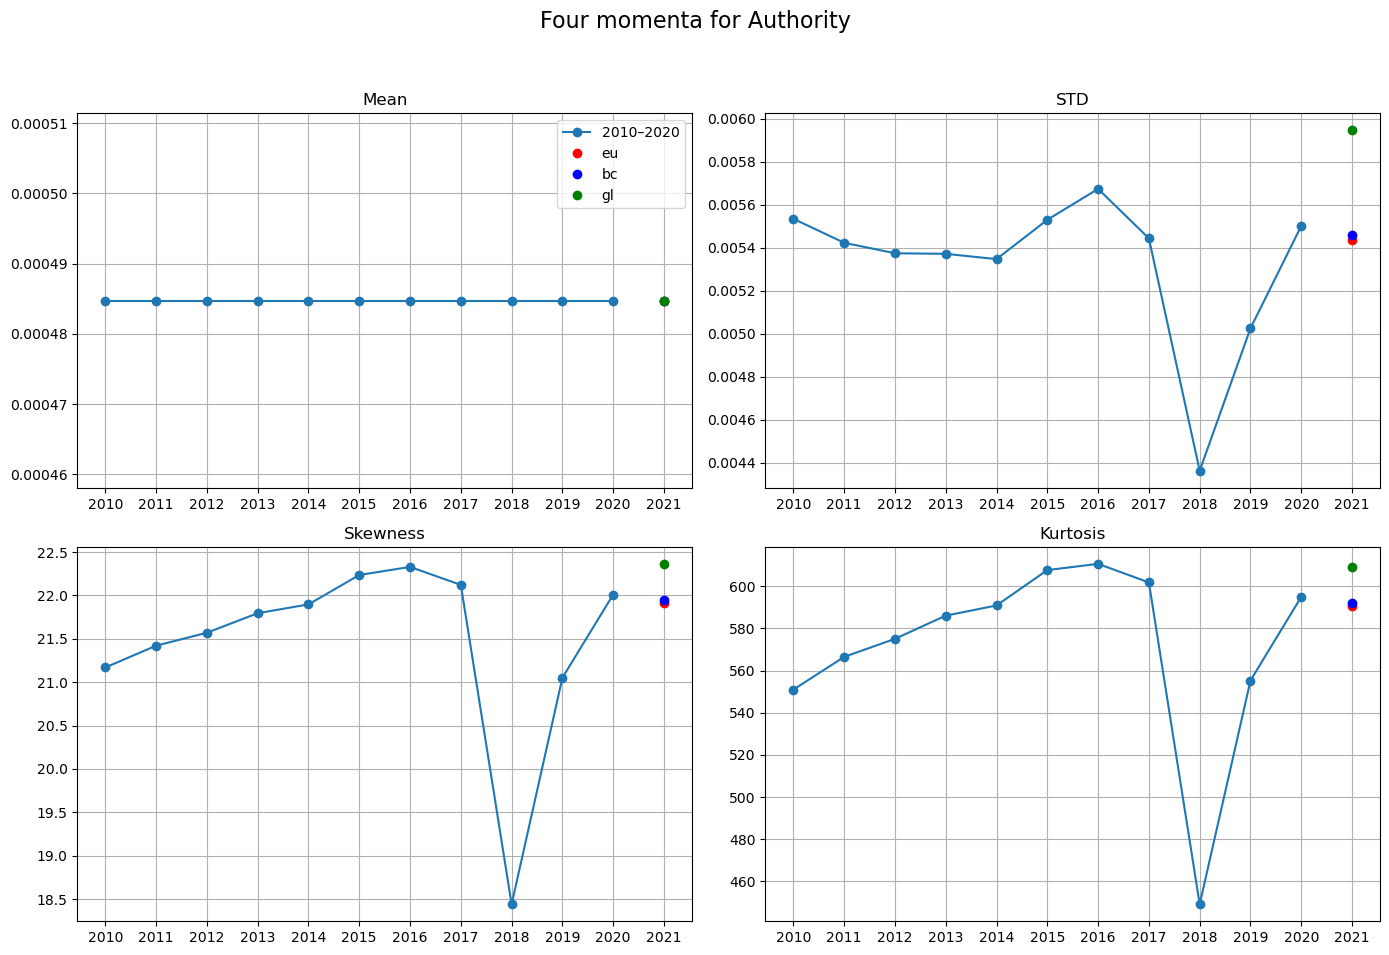

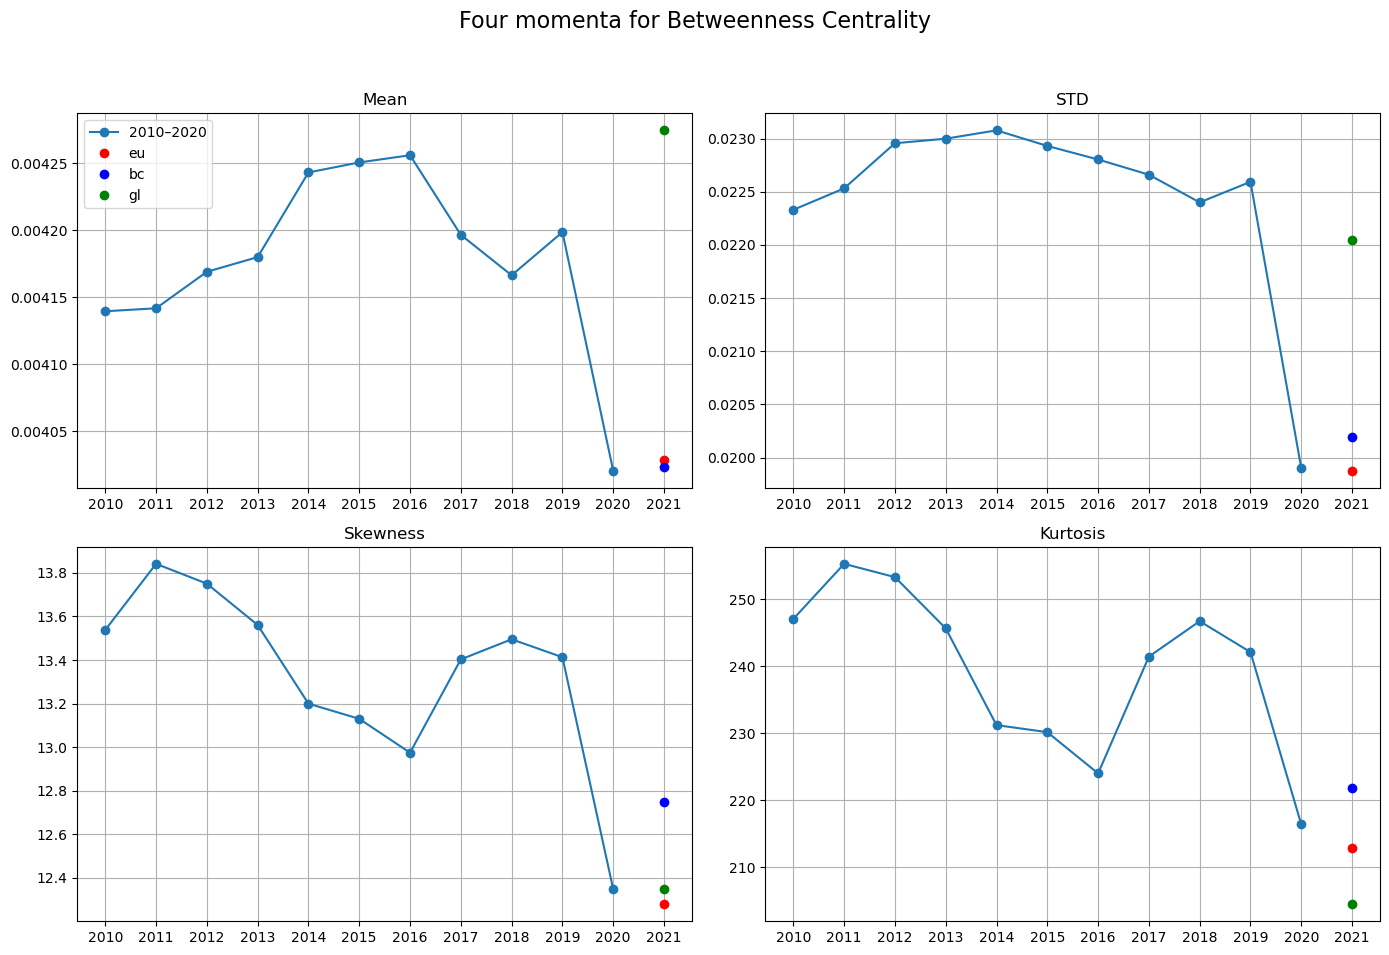

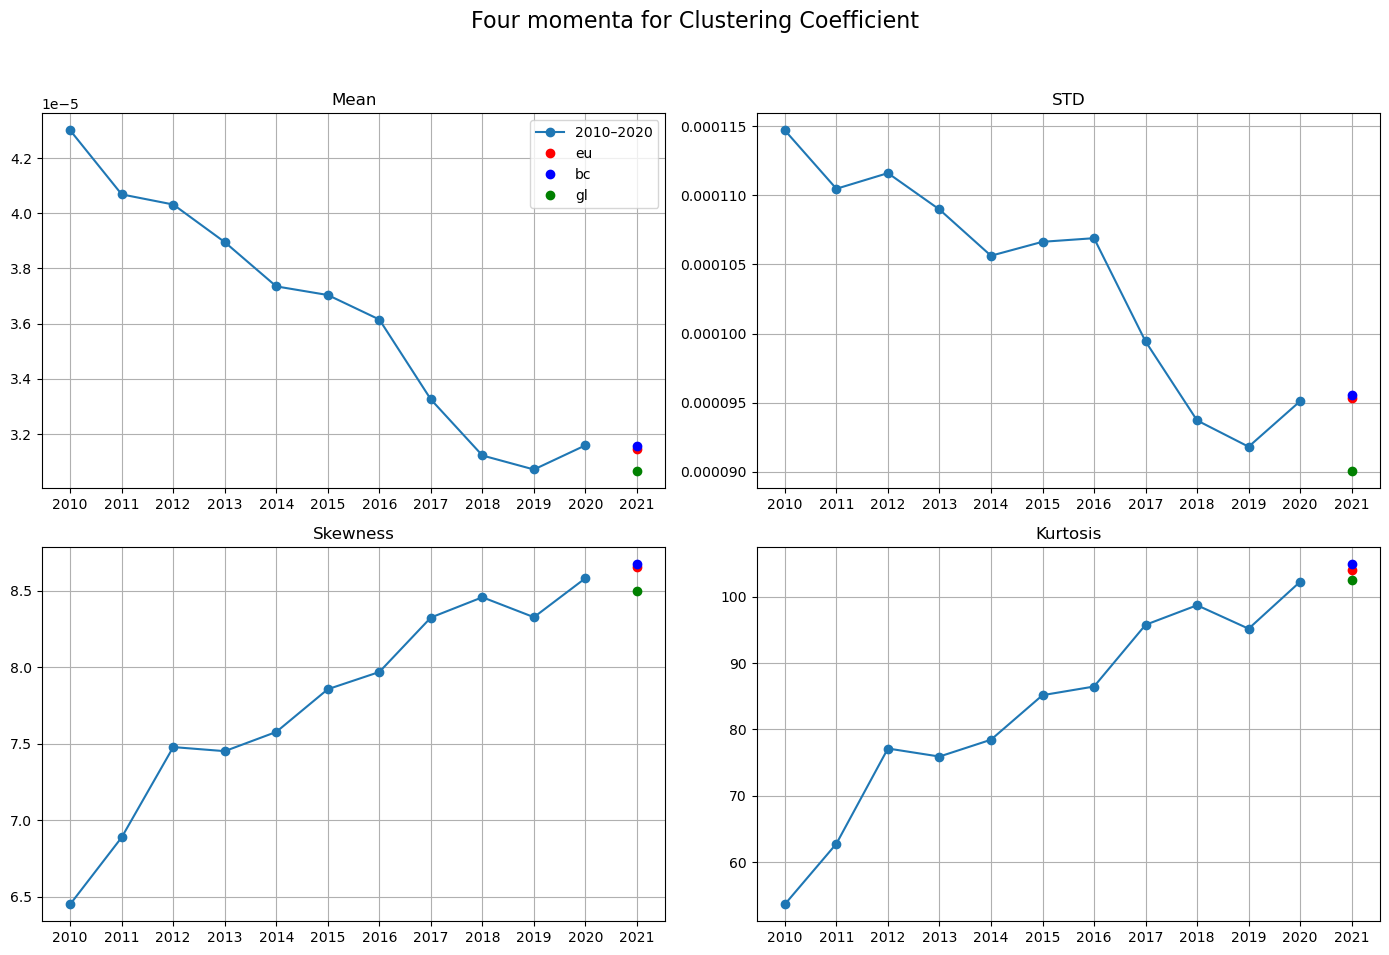

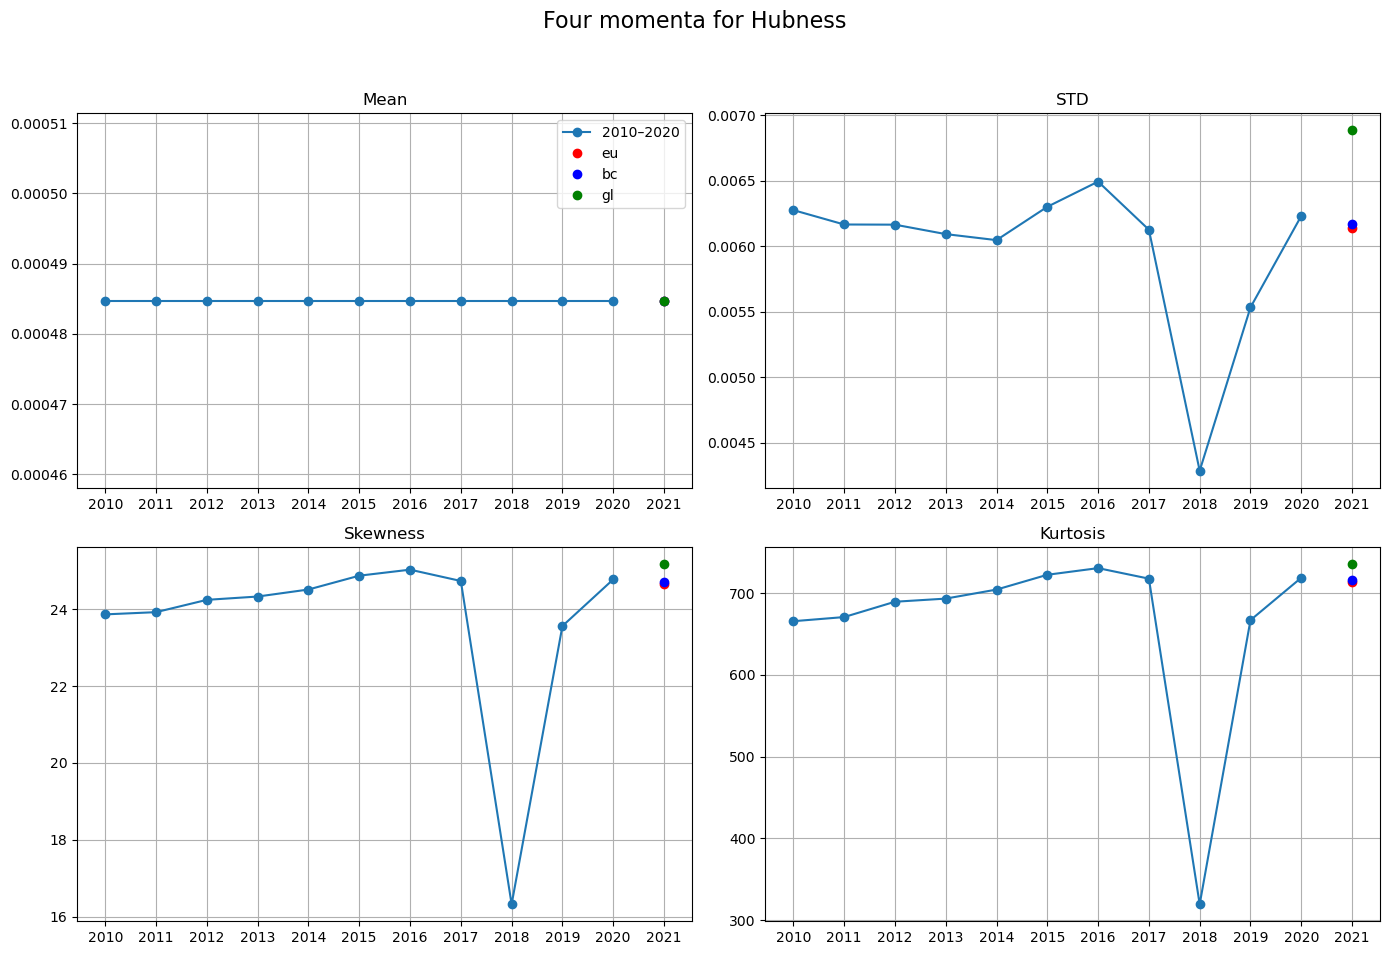

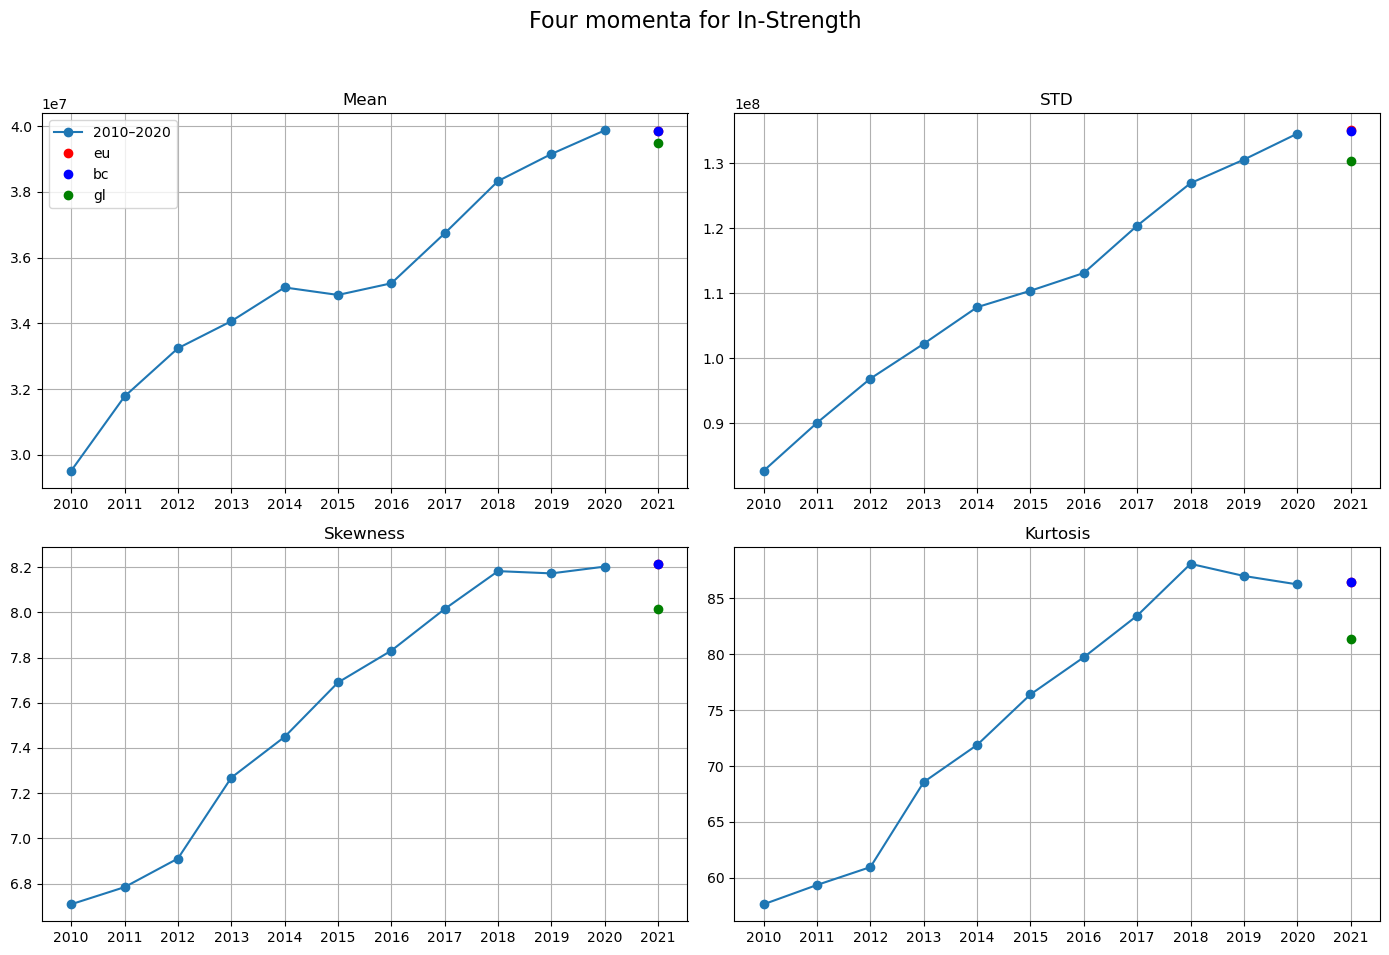

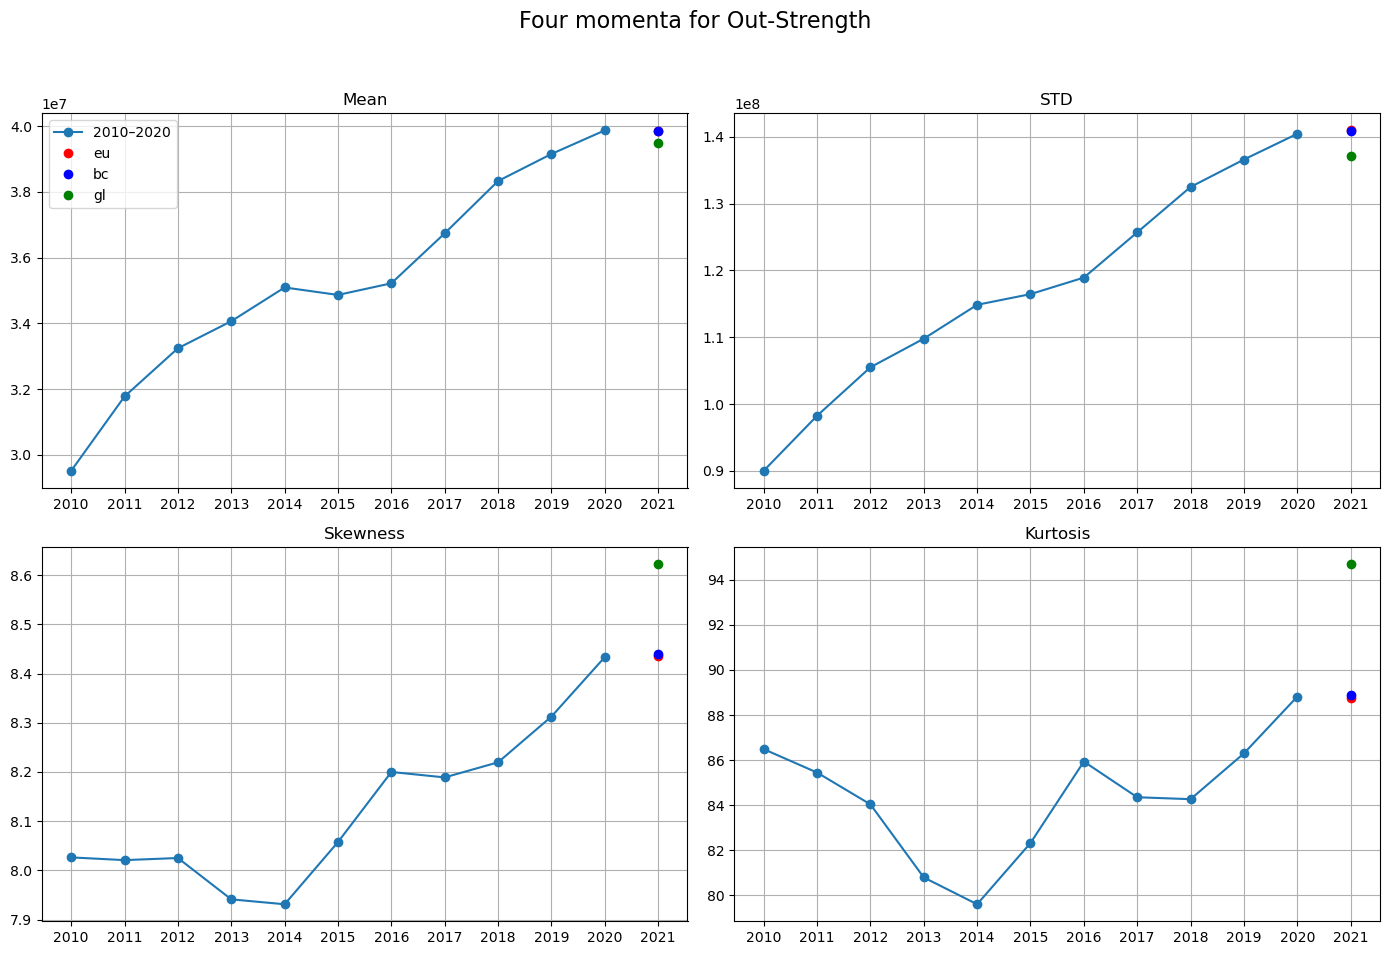

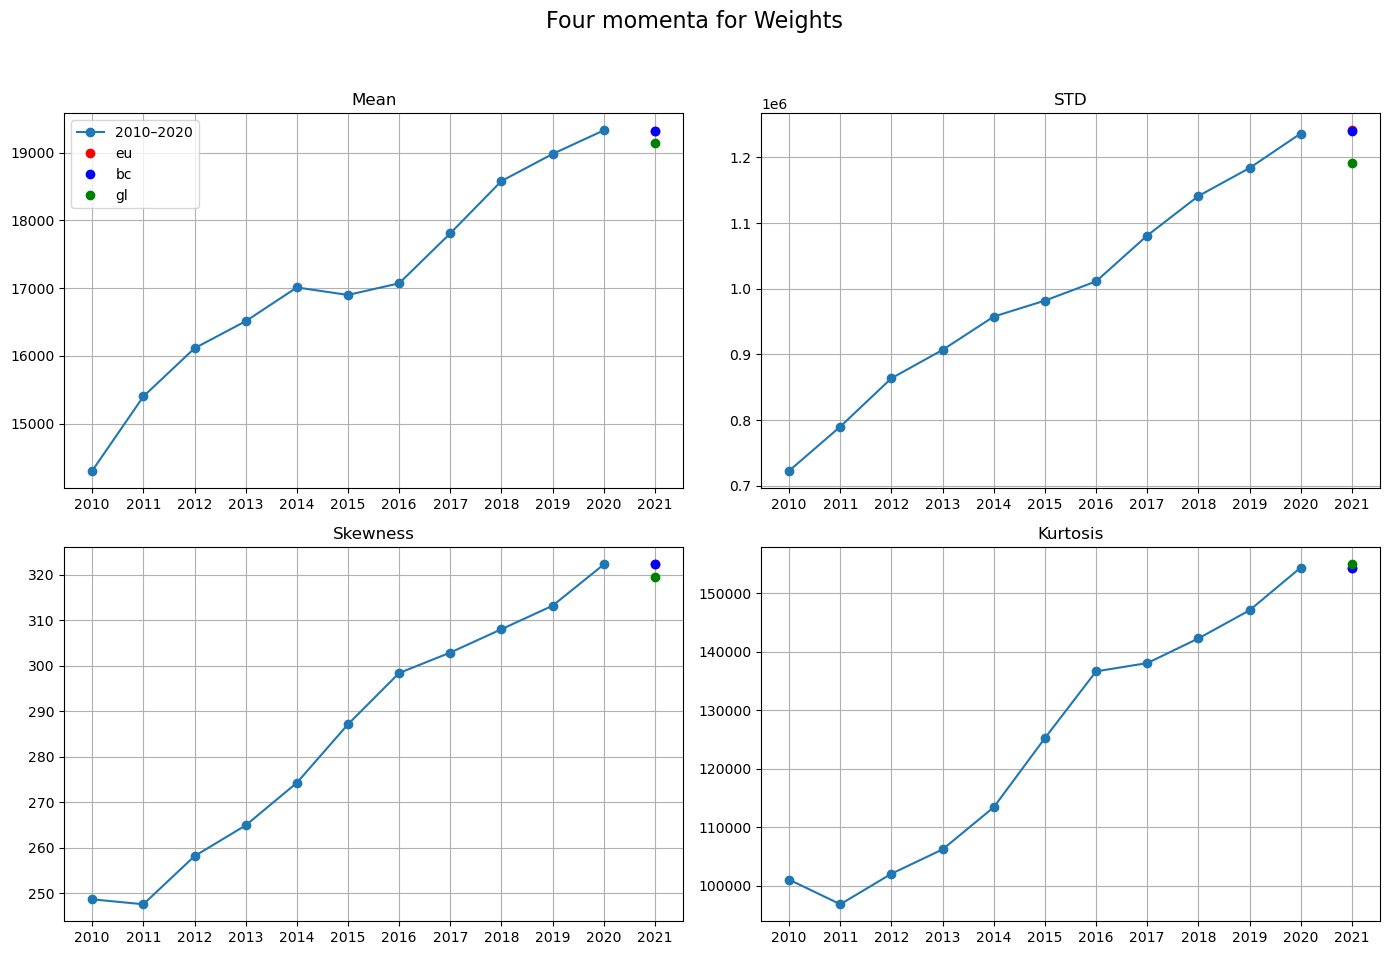

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your parquet file
df = pd.read_parquet('Stat_measures.parquet')

# Ensure index is of string type for consistency
df.index = df.index.astype(str)

# Define time range and special rows
years = [str(y) for y in range(2010, 2021)]
special_cases = ['eu', 'bc', 'gl']
x_special = 2021
colors = {'eu': 'red', 'bc': 'blue', 'gl': 'green'}
measures = ['Mean', 'STD', 'Skewness', 'Kurtosis']
name = {'Clus': 'Clustering Coefficient', 'Bc': 'Betweenness Centrality', 'Hub': 'Hubness', 'Aut': 'Authority',
        'In-Strength': 'In-Strength', 'Out-Strength': 'Out-Strength', 'Weights': 'Weights' }

# Extract top-level column categories
column_groups = df.columns.levels[0]

# Generate plots
for group in column_groups:
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Four momenta for {name[group]}", fontsize=16)
    axs = axs.flatten()

    for i, measure in enumerate(measures):
        ax = axs[i]

        # Historical data (2010–2020)
        y_values = df.loc[years, (group, measure)].astype(float)
        ax.plot(range(2010, 2021), y_values, marker='o', label='2010–2020')

        # Special cases at 2021
        for case in special_cases:
            y = df.loc[case, (group, measure)]
            ax.plot(x_special, y, 'o', color=colors[case], label=case)

        ax.set_title(measure)
        ax.set_xticks(list(range(2010, 2022)))
        ax.grid(True)
        if i == 0:
            ax.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f"{group}_stat_measures.png")
    plt.show()


In [14]:
Z = {}
weights = {}
in_strength = {}
out_strength = {}

for year in all_identifiers:
    Z[year] = pd.read_parquet(f'dfz_{year}.parquet')
    weights[year] = Z[year].values.flatten() 
    in_strength[year] = Z[year].sum(axis=0).values
    out_strength[year] = Z[year].sum(axis=1).values


In [48]:
Z_s = {}
weights_s = {}
in_strength_s = {}
out_strength_s = {}
for year in all_identifiers:
    Z_s[year] = pd.read_parquet(f'dfz_s_{year}.parquet')
    weights_s[year] = Z_s[year].values.flatten() 
    in_strength_s[year] = Z_s[year].sum(axis=0).values
    out_strength_s[year] = Z_s[year].sum(axis=1).values


In [50]:
G_s = {}
for year in all_identifiers:
    G_s[year] = nx.from_pandas_adjacency(Z_s[year], create_using=nx.DiGraph)


In [15]:
clus = {}
hub_aut= {}
bce = {}
for year in all_identifiers:
    clus[year] = pd.read_parquet(f'clus_{year}.parquet') #Clus key for the values column: 'Clustering_Coefficient'
    hub_aut[year] = pd.read_parquet(f'hub_aut_{year}.parquet') #Hub(aut) key for the values column: 'hub(authority)_score'
    bce[year] = pd.read_parquet(f'dfz_s_{year}_bc.parquet') #Bce key for the the values column: 'betweenness'





In [ ]:
Spars_degree_measures = {}

# For years 2010–2020
for year in range(2010, 2021):
    df = pd.DataFrame({
        'in_degree': dict(G_s[year].in_degree()),
        'out_degree': dict(G_s[year].out_degree()),
        'avg_neigh_in_deg': nx.average_neighbor_degree(G_s[year], source='in', target='in'),
        'avg_neigh_out_deg': nx.average_neighbor_degree(G_s[year], source='out', target='out')
    })
    Spars_degree_measures[year] = df

# For additional models: 'eu', 'gl', 'bc' (assuming labels = ['eu', 'gl', 'bc'])
for model in labels:
    df = pd.DataFrame({
        'in_degree': dict(G_s[model].in_degree()),
        'out_degree': dict(G_s[model].out_degree()),
        'avg_neigh_in_deg': nx.average_neighbor_degree(G_s[model], source='in', target='in'),
        'avg_neigh_out_deg': nx.average_neighbor_degree(G_s[model], source='out', target='out')
    })
    Spars_degree_measures[model] = df

print(Spars_degree_measures)

In [ ]:
with open('Spars_degree_measures.pkl', 'wb') as f:
    pickle.dump(Spars_degree_measures, f)

with open('Spars_degree_measures.pkl', 'rb') as f:
    Spars_degree_measures = pickle.load(f)


In [49]:
#Define function to compute the average conditional probabilities (with logarithmic values)
def log_average_conditional(data_dict, num_bins=70, title='', output_prefix='output'):
    all_values = []
    for year_data in data_dict.values():
        vals = np.array(year_data)
        vals = vals[vals > 0]  # 🔹 Remove zero or negative values
        vals = np.log10(vals)    # 🔹 Now it's safe to log
        all_values.append(vals)
    all_values = np.concatenate(all_values)

 # 🔸 2. Bin edges
    bin_edges = np.linspace(np.min(all_values), np.max(all_values), num_bins + 1)

    # 🔸 3. Compute conditional matrices for each year-pair
    conditional_stack = []
    years = sorted(data_dict.keys())

    for y1, y2 in zip(years[:-1], years[1:]):
        x_vals = np.array(data_dict[y1])
        y_vals = np.array(data_dict[y2])

        mask = (x_vals > 0) & (y_vals > 0)
        x_log = np.log10(x_vals[mask])
        y_log = np.log10(y_vals[mask])

        joint_hist, _, _ = np.histogram2d(x_log, y_log, bins=[bin_edges, bin_edges])
        joint_prob = joint_hist / np.sum(joint_hist)

        # Marginal for x (year T)
        marginal_x = np.sum(joint_prob, axis=1)

        conditional_prob = np.zeros_like(joint_prob)
        for i in range(marginal_x.shape[0]):
            if marginal_x[i] > 0:
                conditional_prob[i, :] = joint_prob[i, :] / marginal_x[i]
                row_sum = conditional_prob[i, :].sum()
                if row_sum > 0:
                    conditional_prob[i, :] /= row_sum

        conditional_stack.append(conditional_prob)

    # 🔸 4. Average conditional
    average_conditional = np.mean(conditional_stack, axis=0)
    row_sums = np.sum(average_conditional, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    average_conditional = average_conditional / row_sums

    # 🔸 5. Plot
    # 🔹 Override plotting range if requested
    plot_edges = bin_edges

    X, Y = np.meshgrid(bin_edges, bin_edges)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X, Y, average_conditional.T, cmap='plasma')

    # 🔹 Add green line on the main diagonal
    min_val = min(plot_edges[0], plot_edges[0])
    max_val = max(plot_edges[-1], plot_edges[-1])
    plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='-', linewidth=1.5, label='y = x')
    
    plt.xlabel('log(Value) at year T')
    plt.ylabel('log(Value) at year T+1')
    plt.colorbar(label='Avg. Conditional Density P(y|x)')
    plt.title(f'Average Conditional Density:{title}')
    png_path = f"{output_prefix}.png"
    plt.savefig(png_path, dpi=300)
    plt.show()
    plt.close()

    # 🔸 6. Save to Parquet
    # Convert matrix to DataFrame with bin labels
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df = pd.DataFrame(average_conditional, columns=bin_centers, index=bin_centers)
    df.index.name = 'log(Value at year T)'
    df.columns.name = 'log(Value at year T+1)'

    parquet_path = f"{output_prefix}.parquet"
    df.to_parquet(parquet_path)

    print(f"Saved PNG: {png_path}")
    print(f"Saved Parquet: {parquet_path}")

    


    







    

In [48]:
#Define function to compute the average conditional probabilities
def average_conditional(data_dict, num_bins=70, title='', output_prefix='output', plot_value_max=None):
    all_values = []
    for year_data in data_dict.values():
        vals = np.array(year_data)
        all_values.append(vals)
    all_values = np.concatenate(all_values)

 # 🔸 2. Bin edges
    bin_edges = np.linspace(np.min(all_values), np.max(all_values), num_bins + 1)

    # 🔸 3. Compute conditional matrices for each year-pair
    conditional_stack = []
    years = sorted(data_dict.keys())

    for y1, y2 in zip(years[:-1], years[1:]):
        x_vals = np.array(data_dict[y1])
        y_vals = np.array(data_dict[y2])

        joint_hist, _, _ = np.histogram2d(x_vals, y_vals, bins=[bin_edges, bin_edges])
        joint_prob = joint_hist / np.sum(joint_hist)

        # Marginal for x (year T)
        marginal_x = np.sum(joint_prob, axis=1)

        conditional_prob = np.zeros_like(joint_prob)
        for i in range(marginal_x.shape[0]):
            if marginal_x[i] > 0:
                conditional_prob[i, :] = joint_prob[i, :] / marginal_x[i]
                row_sums = conditional_prob.sum(axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1  # avoid division by zero
                conditional_prob = conditional_prob / row_sums

        conditional_stack.append(conditional_prob)

    # 🔸 4. Average conditional
    average_conditional = np.mean(conditional_stack, axis=0)
    row_sums = np.sum(average_conditional, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    average_conditional = average_conditional / row_sums

    # 🔸 5. Plot
    # 🔹 Override plotting range if requested
    plot_edges = bin_edges
    if plot_value_max is not None:
        plot_edges = np.linspace(0, plot_value_max, num_bins + 1)

    X, Y = np.meshgrid(plot_edges, plot_edges)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X, Y, average_conditional.T, cmap='plasma', shading='auto')
    # 🔹 Add green line on the main diagonal
    min_val = min(plot_edges[0], plot_edges[0])
    max_val = max(plot_edges[-1], plot_edges[-1])
    plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='-', linewidth=1.5, label='y = x')
    plt.xlabel('Value at year T')
    plt.ylabel('Value at year T+1')
    plt.colorbar(label='Avg. Conditional Density P(y|x)')
    plt.title(f'Average Conditional Density:{title}')
    png_path = f"{output_prefix}.png"
    plt.savefig(png_path, dpi=300)
    plt.show()
    plt.close()

    # 🔸 6. Save to Parquet
    # Convert matrix to DataFrame with bin labels
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df = pd.DataFrame(average_conditional, columns=bin_centers, index=bin_centers)
    df.index.name = 'Value at year T'
    df.columns.name = 'Value at year T+1'

    parquet_path = f"{output_prefix}.parquet"
    df.to_parquet(parquet_path)

    print(f"Saved PNG: {png_path}")
    print(f"Saved Parquet: {parquet_path}")

In [62]:
#Define function to compute the average conditional probabilities (with symlog values). Useful for BCE
def symlog_average_conditional(data_dict, num_bins=70, title='', output_prefix='output', linthresh=1e-2):
    # 🔹 1. Collect all values (including zeros) to define global bin edges
    all_values = []
    for year_data in data_dict.values():
        vals = np.array(year_data)
        all_values.append(vals)
    all_values = np.concatenate(all_values)

    # 🔸 2. Bin edges over full range
    bin_edges = np.linspace(np.min(all_values), np.max(all_values), num_bins + 1)

    # 🔸 3. Compute conditional matrices for each year-pair
    conditional_stack = []
    years = sorted(data_dict.keys())

    for y1, y2 in zip(years[:-1], years[1:]):
        x_vals = np.array(data_dict[y1])
        y_vals = np.array(data_dict[y2])

        # Mask finite values only (to avoid NaNs or inf)
        mask = np.isfinite(x_vals) & np.isfinite(y_vals)
        x_vals = x_vals[mask]
        y_vals = y_vals[mask]

        joint_hist, _, _ = np.histogram2d(x_vals, y_vals, bins=[bin_edges, bin_edges])
        joint_prob = joint_hist / np.sum(joint_hist)

        marginal_x = np.sum(joint_prob, axis=1)

        conditional_prob = np.zeros_like(joint_prob)
        for i in range(marginal_x.shape[0]):
            if marginal_x[i] > 0:
                conditional_prob[i, :] = joint_prob[i, :] / marginal_x[i]

        conditional_stack.append(conditional_prob)

    # 🔸 4. Average conditional
    average_conditional = np.mean(conditional_stack, axis=0)
    row_sums = np.sum(average_conditional, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    average_conditional = average_conditional / row_sums

    # 🔸 5. Plot with symlog scale
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    X, Y = np.meshgrid(bin_centers, bin_centers)

    plt.figure(figsize=(8, 6))
    pcm = plt.pcolormesh(X, Y, average_conditional.T, cmap='plasma', shading='auto')
    plt.xscale('symlog', linthresh=linthresh)
    plt.yscale('symlog', linthresh=linthresh)
    plt.xlabel('Symlog(Value at year T)')
    plt.ylabel('Symlog(Value at year T+1)')
    plt.colorbar(pcm, label='Avg. Conditional Density P(y|x)')
    plt.title(f'Average Conditional Density: {title}')
    plt.tight_layout()
    png_path = f"{output_prefix}.png"
    plt.savefig(png_path, dpi=300)
    plt.show()
    plt.close()

    # 🔸 6. Save to Parquet with bin centers
    df = pd.DataFrame(average_conditional, columns=bin_centers, index=bin_centers)
    df.index.name = 'Value at year T'
    df.columns.name = 'Value at year T+1'

    parquet_path = f"{output_prefix}.parquet"
    df.to_parquet(parquet_path)

    print(f"Saved PNG: {png_path}")
    print(f"Saved Parquet: {parquet_path}")

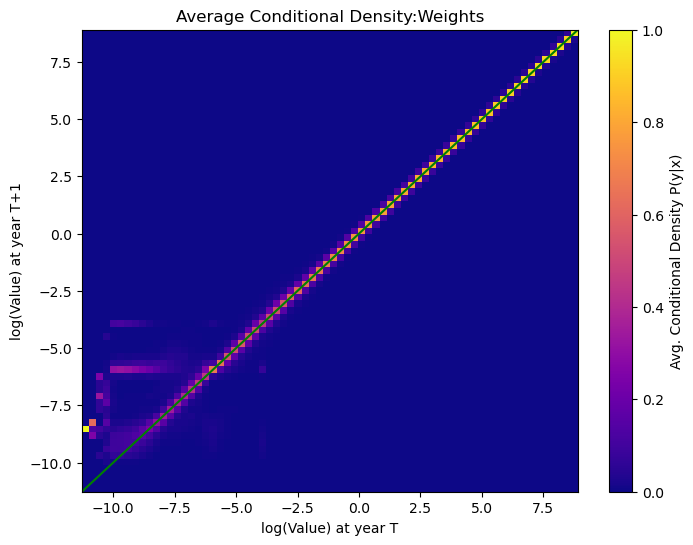

Saved PNG: avg_condit_weights.png
Saved Parquet: avg_condit_weights.parquet


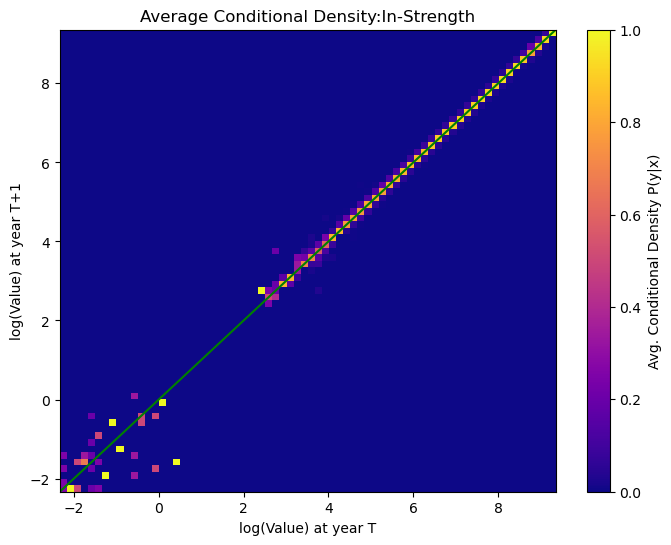

Saved PNG: avg_condit_in.png
Saved Parquet: avg_condit_in.parquet


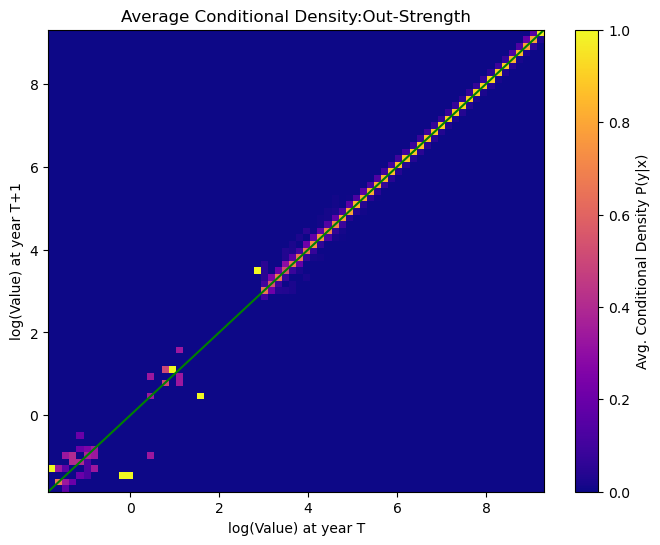

Saved PNG: avg_condit_out.png
Saved Parquet: avg_condit_out.parquet


In [50]:
log_average_conditional(weights, title='Weights', output_prefix='avg_condit_weights')
log_average_conditional(in_strength, title='In-Strength', output_prefix='avg_condit_in')
log_average_conditional(out_strength, title='Out-Strength', output_prefix='avg_condit_out')

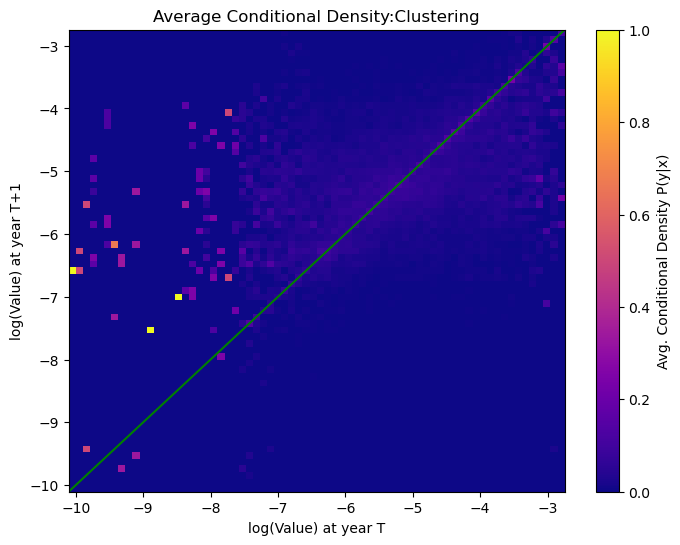

Saved PNG: avg_condit_clus.png
Saved Parquet: avg_condit_clus.parquet


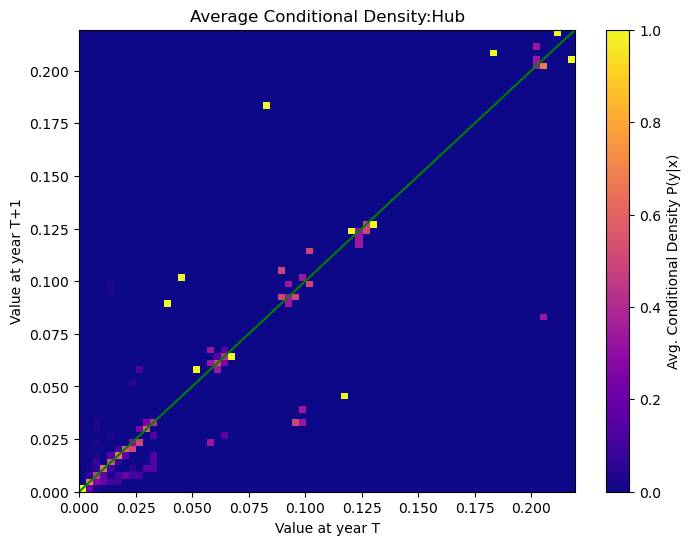

Saved PNG: avg_condit_hub.png
Saved Parquet: avg_condit_hub.parquet


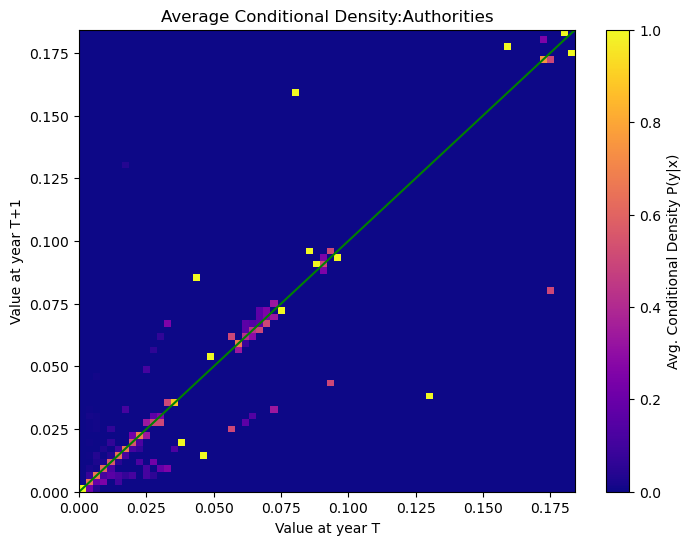

Saved PNG: avg_condit_aut.png
Saved Parquet: avg_condit_aut.parquet


In [51]:
log_average_conditional(clus_values, title='Clustering', output_prefix='avg_condit_clus')
average_conditional(hub_values, title='Hub', output_prefix='avg_condit_hub')
average_conditional(aut_values, title='Authorities', output_prefix='avg_condit_aut')

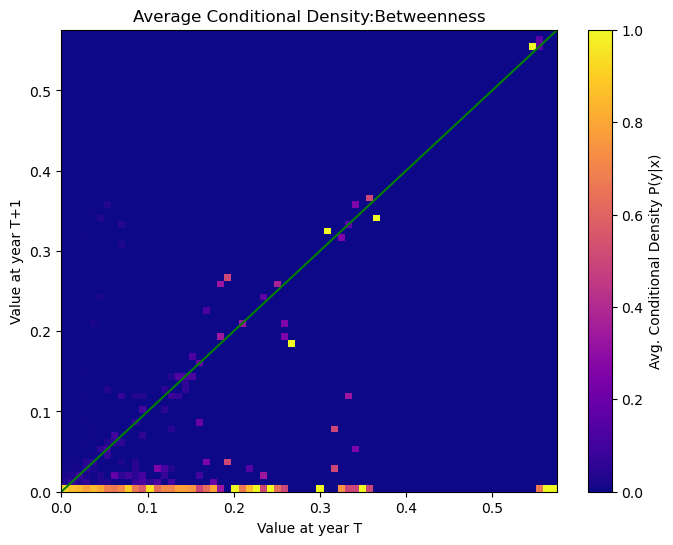

Saved PNG: avg_condit_bc.png
Saved Parquet: avg_condit_bc.parquet


In [52]:
average_conditional(bce_values, title='Betweenness', output_prefix='avg_condit_bc')

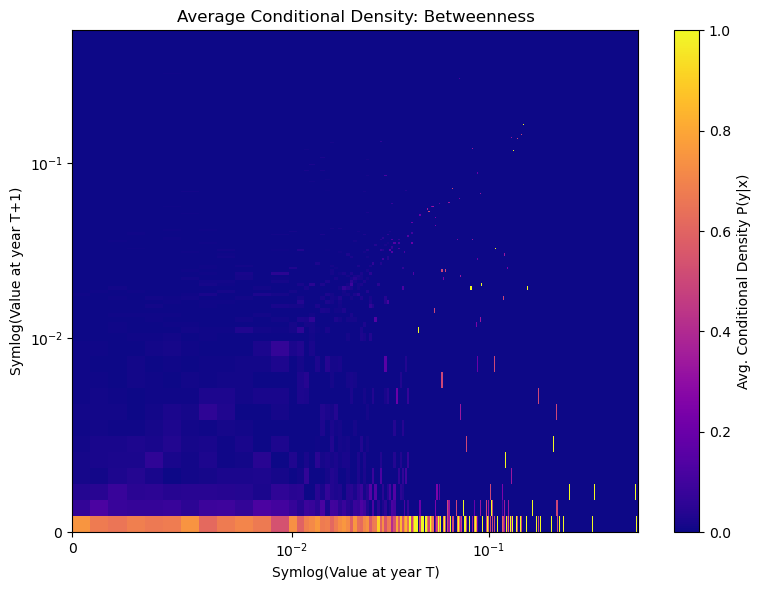

Saved PNG: symlog_avg_condit_bc.png
Saved Parquet: symlog_avg_condit_bc.parquet


In [64]:
symlog_average_conditional(bce_values, 700, title='Betweenness', output_prefix='symlog_avg_condit_bc')

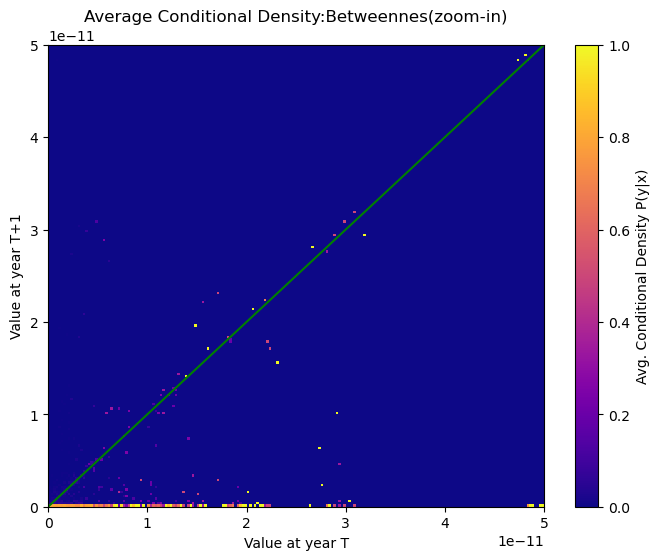

Saved PNG: avg_condit_limit_bc.png
Saved Parquet: avg_condit_limit_bc.parquet


In [60]:
average_conditional(bce_values, num_bins= 200,  title='Betweennes(zoom-in)', output_prefix='avg_condit_limit_bc', plot_value_max=0.00000000005)

In [95]:
#transition probability
years = list(range(2010, 2021))
#K = 10       # Number of quantile classes
#tau = 1      # Time lag
#omega = 1    # Window around diagonal

def quantile_class(series, K):
    ranked = series.rank(method='average')
    return pd.qcut(ranked, q=K, labels=False, duplicates='drop')

def compute_transition_matrix(dict, name='', K=100, tau=1):
    counts = np.zeros((K, K))
    for t in range(tau, len(years)):
        year_t = years[t]
        year_t_tau = years[t - tau]

        x_t = dict[year_t][name]
        x_t_tau = dict[year_t_tau][name]

        qc_t = quantile_class(x_t, K)
        qc_t_tau = quantile_class(x_t_tau, K)

        for i, j in zip(qc_t_tau, qc_t):
            counts[int(i), int(j)] += 1
    #with pd.option_context('display.max_rows', None):
        #print( qc_t)
  
    # Normalize to get transition probabilities
    with np.errstate(divide='ignore', invalid='ignore'):
        P = counts / counts.sum(axis=1, keepdims=True)
        P[np.isnan(P)] = 0  # Replace NaNs from 0/0 with 0
    return P

def compute_M_tau_omega(P, K=100, omega=1):
    return (1 / K) * sum(
        P[h, l]
        for h, l in product(range(K), repeat=2)
        if abs(h - l) <= omega
    )
        

In [101]:
clus_trans_matrix = compute_transition_matrix(clus, name='Clustering_Coefficient', K=100, tau=1)
M_clus = compute_M_tau_omega(clus_trans_matrix, K=100, omega=50)
print(M_clus)

0.860321428571491


In [199]:
clus_trans_matrix2 = compute_transition_matrix(clus, name='Clustering_Coefficient', K=5, tau=1)
M_clus2 = compute_M_tau_omega(clus_trans_matrix2, K=5, omega=1)
print(M_clus2)

0.6812756529302523


In [93]:
bce_trans_matrix = compute_transition_matrix(bce, name='betweenness', K=100, tau=1)
bce_M = compute_M_tau_omega(bce_trans_matrix, K=100, omega=100)
print(bce_M)

AUS_AGRagr    19
AUS_AGRfor     0
AUS_AGRfis     0
AUS_ENRcoa    16
AUS_ENRoil     0
AUS_ENRgas    21
AUS_MIN+      40
AUS_MANfoo     5
AUS_MANtex     0
AUS_MANwoo    12
AUS_MANpap     0
AUS_MANpri     0
AUS_MANche     0
AUS_MANpha     0
AUS_MANpla     0
AUS_MANmin     0
AUS_MANmet     9
AUS_MANfmp     0
AUS_MANmac     0
AUS_MANmot     0
AUS_MANtra     0
AUS_MANrep     0
AUS_MANcom     0
AUS_MANele     0
AUS_MANfur     0
AUS_ENRele     6
AUS_WATwat     0
AUS_WATwst     0
AUS_CNS+      42
AUS_TRDmot    36
AUS_TRAinl    15
AUS_TRAwat     7
AUS_TRAair     0
AUS_TRAwar     0
AUS_TRApos     0
AUS_FD+       15
AUS_COMpub    12
AUS_COMvid     9
AUS_COMcom     0
AUS_FINser    31
AUS_RES+      37
AUS_PROleg    26
AUS_ADM+      32
AUS_PUB+       8
AUS_EDU+       0
AUS_HEA+      14
AUS_ART+       0
AUS_EXT+       0
CHE_MANpha    37
CHN_MANfoo    33
CHN_MANtex    31
CHN_MANwoo     3
CHN_MANpap    29
CHN_MANche    32
CHN_MANpha    38
CHN_MANpla    37
CHN_MANfmp    36
CHN_MANmac    43
CHN_MANtra    

In [92]:
hub_trans_matrix = compute_transition_matrix(hub_aut, name='hub_score', K=100, tau=1)
hub_M = compute_M_tau_omega(hub_trans_matrix, K=100, omega=1)
print(hub_M)

0       80
1       35
2       71
3       79
4       67
5       66
6       95
7       84
8       42
9       54
10      61
11      44
12      47
13      73
14      56
15      59
16      90
17      64
18      53
19      52
20      67
21      11
22      70
23      45
24      53
25      44
26      32
27      36
28      78
29      87
30      63
31      60
32      70
33      68
34      58
35      41
36      53
37      55
38      68
39      86
40      56
41      84
42      69
43      44
44      28
45      28
46      35
47      31
48      23
49      19
50       4
51      20
52      44
53      37
54      28
55      61
56      40
57      59
58      58
59      35
60      63
61      69
62      62
63      68
64      75
65      74
66      80
67      77
68      61
69      17
70      71
71      73
72      65
73      26
74      20
75      14
76      46
77      78
78      67
79      30
80      39
81      69
82      42
83      33
84      44
85      34
86      67
87      77
88      39
89      82
90      55

In [85]:
aut_trans_matrix = compute_transition_matrix(hub_aut, name='authority_score', K=100, tau=1)
aut_M = compute_M_tau_omega(aut_trans_matrix, K=100, omega=1)
print(aut_M)

0.6876190476190478


In [221]:
nodes = clus[2020]['Node']
in_strength_with_node = {}
for year in years:
    in_strength_with_node[year] = pd.DataFrame({
    'Node': nodes,
    'in_strength': in_strength[year]
    })

out_strength_with_node = {}
for year in years:
    out_strength_with_node[year] = pd.DataFrame({
    'Node': nodes,
    'out_strength': out_strength[year]
    })
in_strength_with_node = {}
for year in years:
    in_strength_with_node[year] = pd.DataFrame({
    'Node': nodes,
    'in_strength': in_strength[year]
    })

out_strength_with_node = {}
for year in years:
    out_strength_with_node[year] = pd.DataFrame({
    'Node': nodes,
    'out_strength': out_strength[year]
    })



In [222]:
in_trans_matrix = compute_transition_matrix(in_strength_with_node, name='in_strength', K=100, tau=1)
in_M = compute_M_tau_omega(in_trans_matrix, K=100, omega=1)
print(in_M)

0.9359357142857154


In [223]:
out_trans_matrix = compute_transition_matrix(out_strength_with_node, name='out_strength', K=100, tau=1)
out_M = compute_M_tau_omega(out_trans_matrix, K=100, omega=1)
print(out_M)

0.9381071428571437


In [230]:

M = pd.DataFrame({
    'Statistics': ['clus', 'bce', 'hub', 'aut', 'in', 'out' ],
     'M(τ=1, ω=1, K=100)': [M_clus, bce_M, hub_M, aut_M, in_M, out_M]
    })
print(M)

M.to_parquet('M_values.parquet')

  Statistics  M(τ=1, ω=1, K=100)
0       clus            0.108462
1         bc            0.045421
2        hub            0.720755
3        aut            0.687619
4         in            0.935936
5        out            0.938107


In [10]:
#def correl coeff function to handle the whole dictionaries

def correl_coeff(array, my_dict, values='', title=''):
    results = {
        'year': [],
        title: []
    }

    for label in all_identifiers:
        dict_values = np.array(my_dict[label][values])
        correlation = np.corrcoef(dict_values, array[label])[0, 1]
        results['year'].append(label)
        results[title].append(correlation)

    return pd.DataFrame(results)
 

In [12]:
corr_in_clus = correl_coeff(in_strength, clus, values = 'Clustering_Coefficient', title= 'In vs Clus')
corr_out_clus = correl_coeff(out_strength, clus, values = 'Clustering_Coefficient', title= 'Out vs Clus')
corr_in_bce = correl_coeff(in_strength, bce, values = 'betweenness', title= 'In vs Bce')
corr_out_bce = correl_coeff(out_strength, bce, values = 'betweenness', title= 'Out vs Bce')

corr_in_clus.set_index('year', inplace=True)
corr_out_clus.set_index('year', inplace=True)
corr_in_bce.set_index('year', inplace=True)
corr_out_bce.set_index('year', inplace=True)

correlation = pd.concat([corr_in_clus, corr_out_clus, corr_in_bce, corr_out_bce], axis=1)
print(correlation)

correlation.index = correlation.index.astype(str)
correlation.to_parquet('Correlation.parquet')

      In vs Clus  Out vs Clus  In vs Bce  Out vs Bce
year                                                
2010    0.003114    -0.001925   0.003918    0.015822
2011   -0.037255    -0.030723   0.000974   -0.003404
2012   -0.013947     0.003790   0.001092   -0.001056
2013   -0.010542    -0.011619   0.005485   -0.005164
2014   -0.027272    -0.018547   0.005371   -0.002606
2015   -0.018356    -0.021496  -0.010851   -0.012036
2016   -0.001191     0.005755  -0.015026   -0.007103
2017   -0.023490    -0.019245  -0.011034   -0.006548
2018   -0.030459    -0.028982  -0.009409   -0.008051
2019   -0.011906    -0.021965  -0.012190   -0.009051
2020   -0.017449    -0.019117  -0.007311   -0.007832
eu     -0.027947    -0.031325   0.038003   -0.016582
gl     -0.022794    -0.022165  -0.011619   -0.012189
bc     -0.028221    -0.026574  -0.008723   -0.006464


In [53]:
#compute the correl coeff from the sparse matrix
corr_in_spar_clus = correl_coeff(in_strength_s, clus, values = 'Clustering_Coefficient', title= 'In(spar) vs Clus')
corr_out_spar_clus = correl_coeff(out_strength_s, clus, values = 'Clustering_Coefficient', title= 'Out(spar) vs Clus')
corr_in_spar_bce = correl_coeff(in_strength_s, bce, values = 'betweenness', title= 'In(spar) vs Bce')
corr_out_spar_bce = correl_coeff(out_strength_s, bce, values = 'betweenness', title= 'Out(spar) vs Bce')

corr_in_spar_clus.set_index('year', inplace=True)
corr_out_spar_clus.set_index('year', inplace=True)
corr_in_spar_bce.set_index('year', inplace=True)
corr_out_spar_bce.set_index('year', inplace=True)

correlation_spar_1 = pd.concat([corr_in_spar_clus, corr_out_spar_clus, corr_in_spar_bce, corr_out_spar_bce], axis=1)
print(correlation_spar_1)

#compute average nearest in-neighbors in-strength and average nearest out-neighbors out-strength
Aver_in_nn_in = {}
Aver_out_nn_out = {}
for label in all_identifiers:
    #average nearest in-neighbors (nodes pointing to that node) in-strength
    Aver_in_nn_in[label] = nx.average_neighbor_degree(G_s[label], weight='weight', source='in', target='in')
    # Convert dictionary to DataFrame
    Aver_in_nn_in[label] = pd.DataFrame.from_dict(Aver_in_nn_in[label], orient='index', columns=['Average_NN_In_Strength'])
    Aver_in_nn_in[label].reset_index(inplace=True)
    Aver_in_nn_in[label].columns = ['Node', 'Average_NN_In_Strength']
    
    #average nearest out-neighbors (nodes pointed by that node) out-strength
    Aver_out_nn_out[label] = nx.average_neighbor_degree(G_s[label], weight='weight', source='out', target='out')
    # Convert dictionary to DataFrame
    Aver_out_nn_out[label] = pd.DataFrame.from_dict(Aver_out_nn_out[label] , orient='index', columns=['Average_NN_Out_Strength'])
    Aver_out_nn_out[label] .reset_index(inplace=True)
    Aver_out_nn_out[label] .columns = ['Node', 'Average_NN_Out_Strength']

corr_in_spar_ann_in = correl_coeff(in_strength_s, Aver_in_nn_in, values = 'Average_NN_In_Strength', title= 'In(spar) vs ANN_In')
corr_out_spar_ann_out = correl_coeff(out_strength_s, Aver_out_nn_out, values = 'Average_NN_Out_Strength', title= 'Out(spar) vs ANN_Out')

corr_in_spar_ann_in.set_index('year', inplace=True)
corr_out_spar_ann_out.set_index('year', inplace=True)

correlation_spar = pd.concat([correlation_spar_1, corr_in_spar_ann_in, corr_out_spar_ann_out], axis=1)
print(correlation_spar)

correlation_spar.index = correlation_spar.index.astype(str)
correlation_spar.to_parquet('Correlation_spar.parquet')

      In(spar) vs Clus  Out(spar) vs Clus  In(spar) vs Bce  Out(spar) vs Bce  \
year                                                                           
2010          0.507077           0.419547         0.498098          0.567063   
2011          0.514506           0.414325         0.498276          0.581345   
2012          0.522357           0.404659         0.506637          0.588394   
2013          0.526359           0.422113         0.504234          0.584768   
2014          0.525021           0.422192         0.498626          0.582316   
2015          0.531152           0.429762         0.494155          0.564738   
2016          0.536893           0.439536         0.491288          0.561035   
2017          0.536753           0.421506         0.488887          0.568397   
2018          0.536783           0.413472         0.484983          0.570962   
2019          0.531304           0.416568         0.485434          0.568598   
2020          0.532718           0.41682

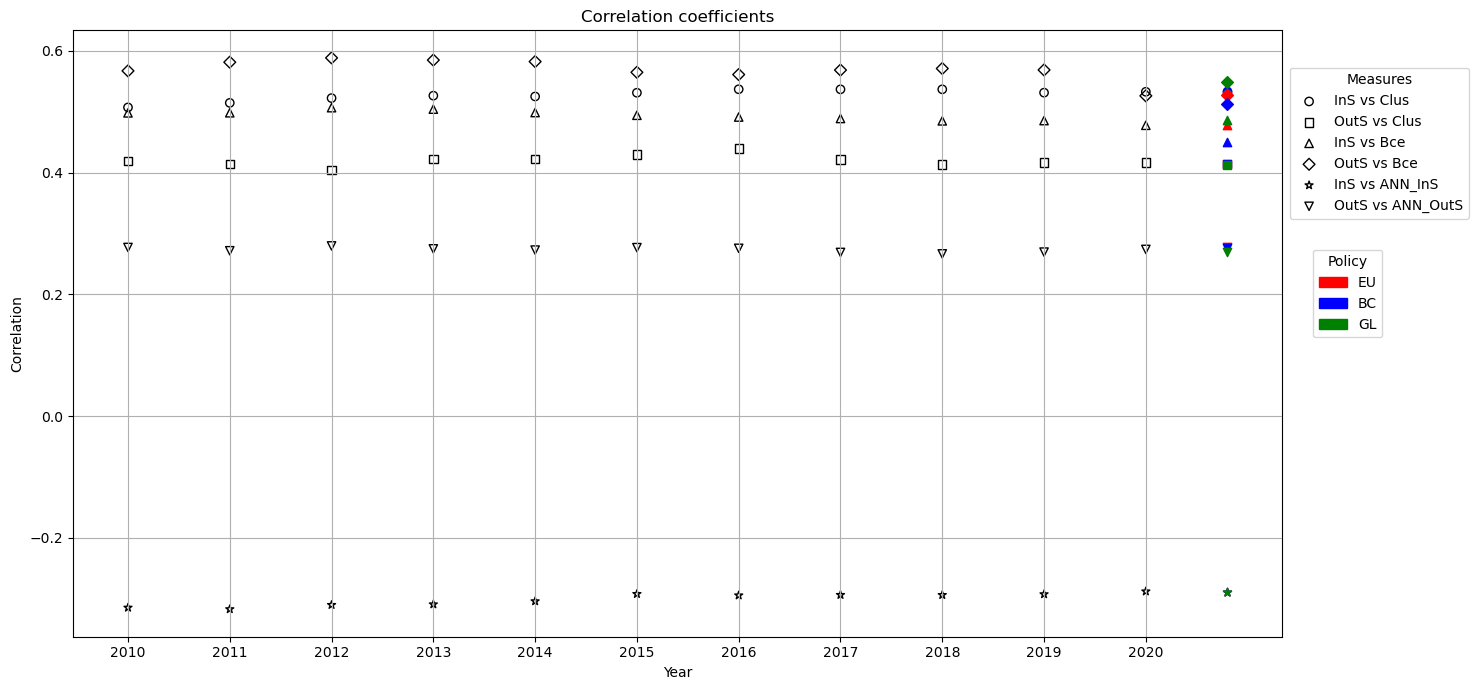

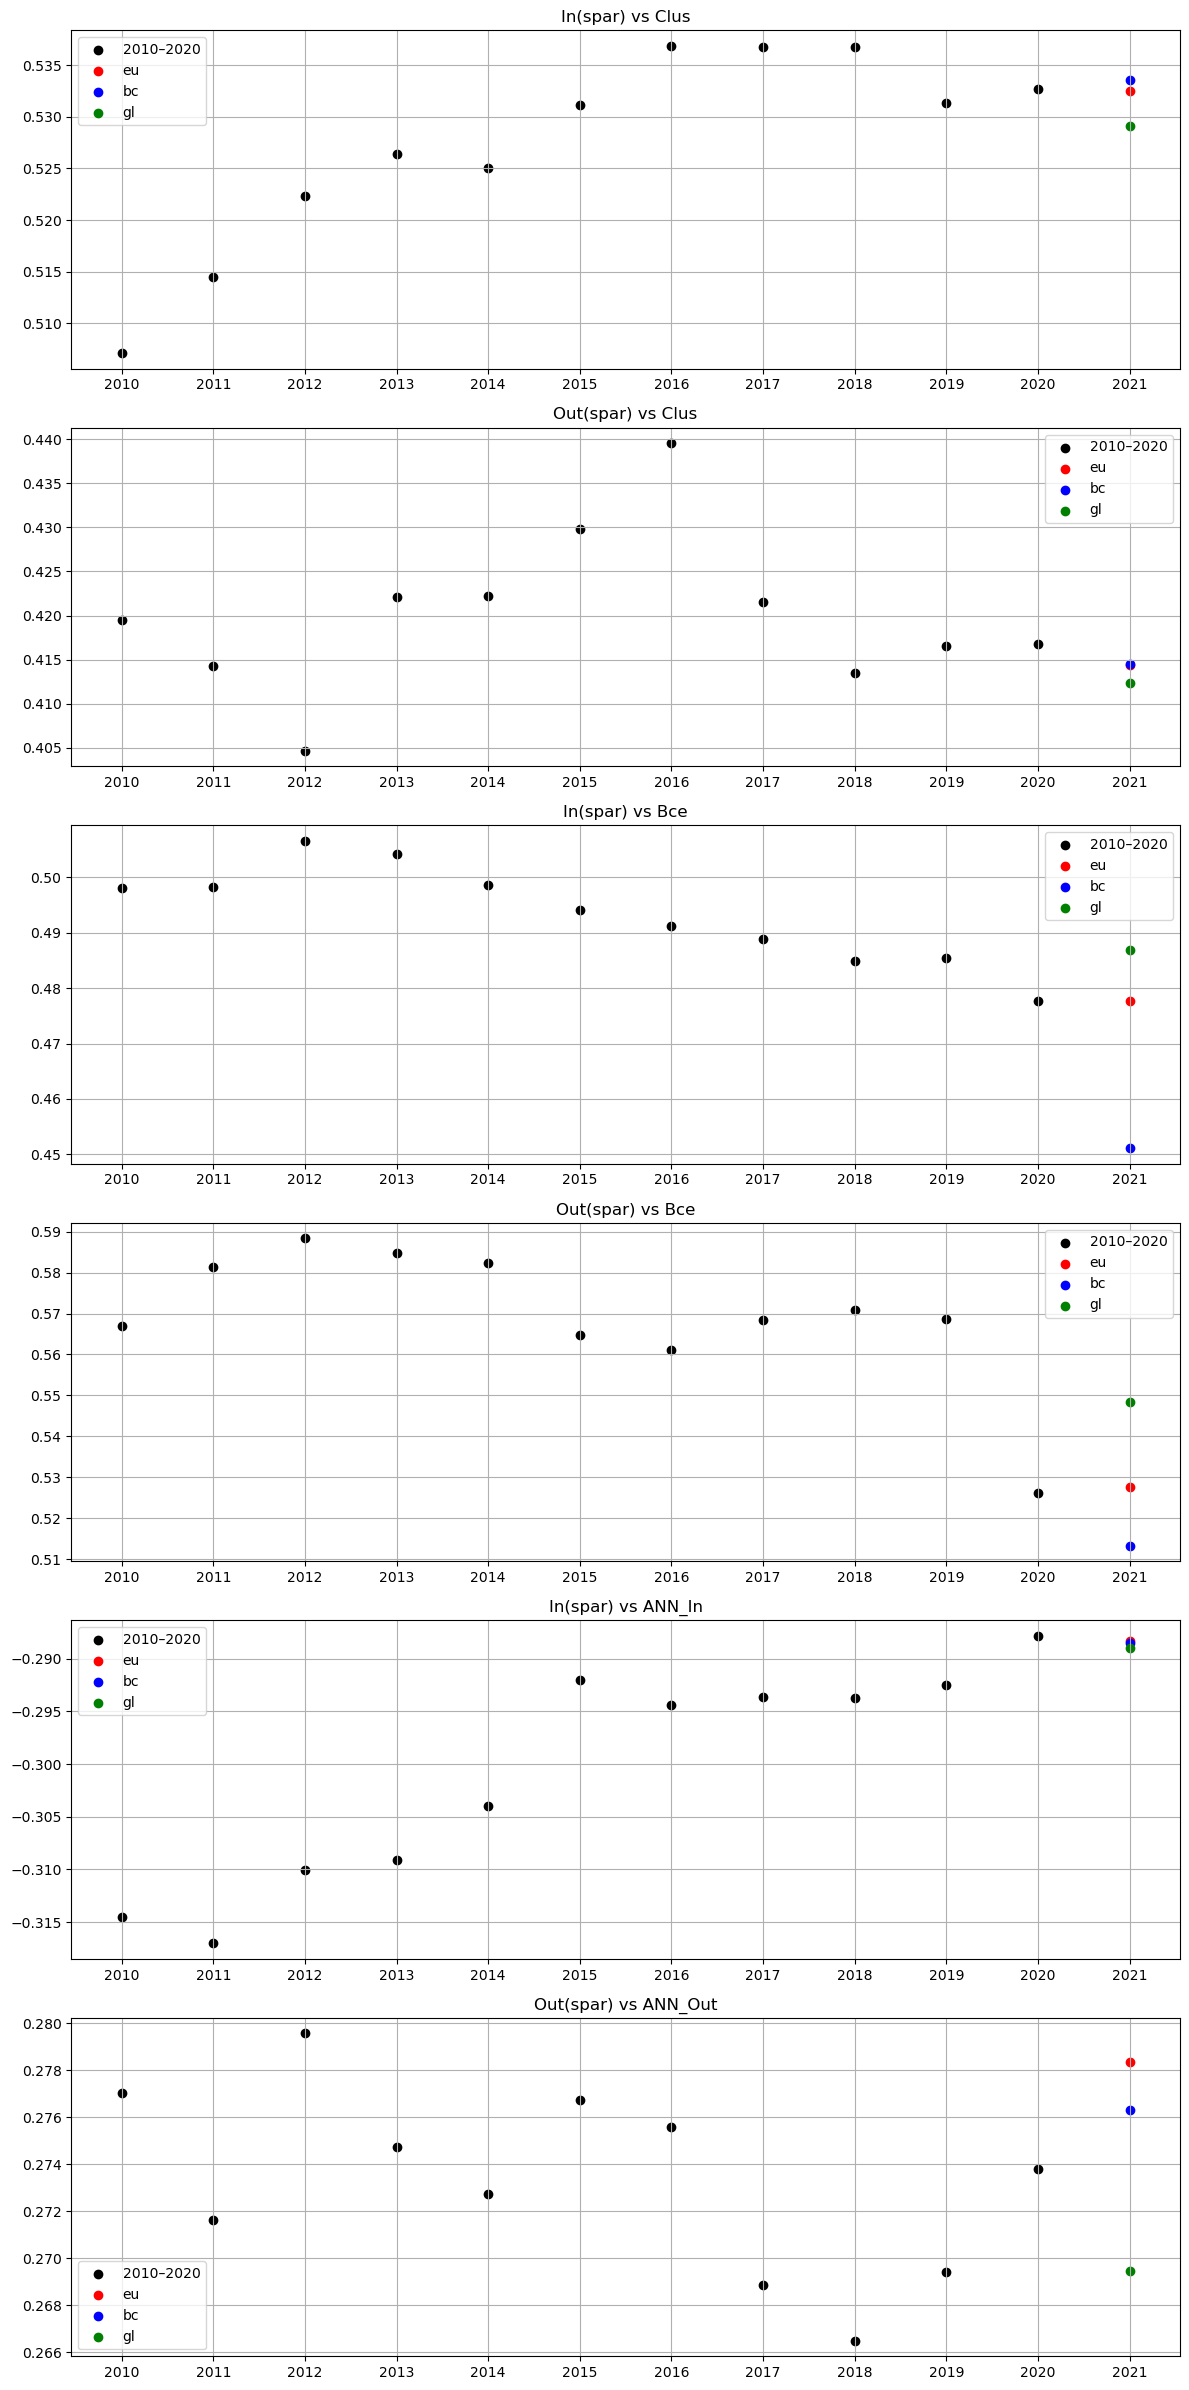

In [57]:
correlation_spar.index = correlation_spar.index.astype(str)
import matplotlib.patches as mpatches

# Setup
years = [str(y) for y in range(2010, 2021)]
special_cases = ['eu', 'bc', 'gl']
colors = {'eu': 'red', 'bc': 'blue', 'gl': 'green'}
policy_x = 2020.8  # All policies at the same x-position
markers = ['o', 's', '^', 'D', '*', 'v', 'p', 'P']

def clean_label(label):
    label = label.replace('(spar) ', 'S ')
    part1 = label.split(' vs ')[0].strip()
    part2 = label.split(' vs ')[1].strip()
    
    # Add 's' if part2 starts with "ANN"
    if part2.startswith("ANN"):
        part2 += 'S'
    
    return f"{part1} vs {part2}"

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 7))
plotted_labels = set()

for i, column in enumerate(correlation_spar.columns):
    marker = markers[i % len(markers)]
    base_label = clean_label(column)

    # Plot main data: 2010–2020
    ax.scatter(
        [int(y) for y in years],
        correlation_spar.loc[years, column],
        marker=marker,
        edgecolors='black',
        facecolors='none'
    )

    # Add to legend only once
    if base_label not in plotted_labels:
        ax.scatter([], [], label=base_label, marker=marker, edgecolors='black', facecolors='none')
        plotted_labels.add(base_label)

    # Plot all special cases at the same x-position
    for case in special_cases:
        ax.scatter(
            policy_x,
            correlation_spar.loc[case, column],
            color=colors[case],
            marker=marker
        )

# === Legends ===
handles1, labels1 = ax.get_legend_handles_labels()
legend1 = ax.legend(handles=handles1, title="Measures", loc='upper right',
    bbox_to_anchor=(1.16, 0.95) )

color_patches = [
    mpatches.Patch(color=color, label=case.upper())
    for case, color in colors.items()
]
legend2 = ax.legend(handles=color_patches, title="Policy", loc='upper left', bbox_to_anchor=(1.02, 0.65))
ax.add_artist(legend1)

# === Final Formatting ===
ax.set_title("Correlation coefficients")
ax.set_xlabel("Year")
ax.set_ylabel("Correlation")
ax.set_xticks(list(range(2010, 2021)))  # No 2021
ax.grid(True)

fig.tight_layout()
fig.savefig("correlations_all_with_policy.png", bbox_inches='tight')
plt.show()



# === Plot 2: One subplot per measure ===
n_measures = len(correlation_spar.columns)
fig, axs = plt.subplots(n_measures, 1, figsize=(12, 4 * n_measures))

# Ensure axs is always iterable
if n_measures == 1:
    axs = [axs]

for i, (column, ax) in enumerate(zip(correlation_spar.columns, axs)):
    # Regular years
    ax.scatter(
        [int(y) for y in years],
        correlation_spar.loc[years, column],
        marker='o',
        color='black',
        label='2010–2020'
    )
    # Special cases
    for case in special_cases:
        ax.scatter(
            2021,
            correlation_spar.loc[case, column],
            color=colors[case],
            marker='o',
            label=case
        )

    ax.set_title(column)
    ax.set_xticks(list(range(2010, 2022)))
    ax.grid(True)
    ax.legend()

fig.tight_layout()
fig.savefig('correlations_single.png')
plt.show()

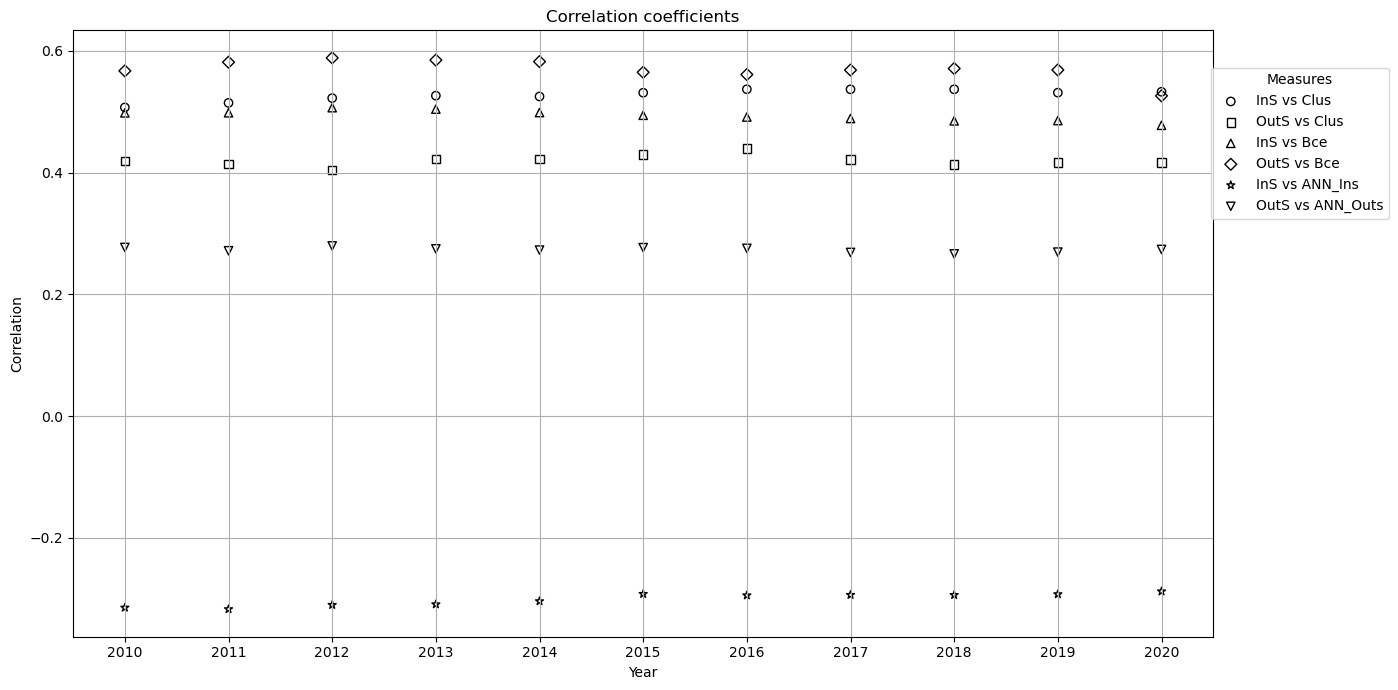

In [58]:
# Setup
years = [str(y) for y in range(2010, 2021)]
markers = ['o', 's', '^', 'D', '*', 'v', 'p', 'P']

def clean_label(label):
    label = label.replace('(spar) ', 'S ')
    part1 = label.split(' vs ')[0].strip()
    part2 = label.split(' vs ')[1].strip()
    
    # Add 's' if part2 starts with "ANN"
    if part2.startswith("ANN"):
        part2 += 's'
    
    return f"{part1} vs {part2}"

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 7))
plotted_labels = set()

for i, column in enumerate(correlation_spar.columns):
    marker = markers[i % len(markers)]
    base_label = clean_label(column)

    # Plot main data: 2010–2020
    ax.scatter(
        [int(y) for y in years],
        correlation_spar.loc[years, column],
        marker=marker,
        edgecolors='black',
        facecolors='none'
    )

    # Add to legend only once
    if base_label not in plotted_labels:
        ax.scatter([], [], label=base_label, marker=marker, edgecolors='black', facecolors='none')
        plotted_labels.add(base_label)
        

# === Legends ===
handles1, labels1 = ax.get_legend_handles_labels()
legend1 = ax.legend(handles=handles1, title="Measures", loc='upper right',
    bbox_to_anchor=(1.16, 0.95) )

# === Final Formatting ===
ax.set_title("Correlation coefficients")
ax.set_xlabel("Year")
ax.set_ylabel("Correlation")
ax.set_xticks(list(range(2010, 2021))) 
ax.grid(True)

fig.tight_layout()
fig.savefig("correlations_all.png", bbox_inches='tight')
plt.show()


In [11]:
In_strength = {
    year: pd.DataFrame({
        'Node': clus[year]['Node'],
        'In_Strength': in_strength[year]
    })
    for year in in_strength if year in clus
}

print(In_strength)

{2010:             Node   In_Strength
0     AUS_AGRagr  2.961852e+07
1     AUS_AGRfor  3.057586e+06
2     AUS_AGRfis  3.971734e+06
3     AUS_ENRcoa  1.261337e+07
4     AUS_ENRoil  1.335683e+07
...          ...           ...
2058    TUR_HEA+  1.597041e+07
2059  TUR_MANrep  7.371920e+07
2060  TUR_COMvid  6.222810e+08
2061  TUR_COMcom  1.708028e+07
2062  TUR_PROleg  1.159660e+07

[2063 rows x 2 columns], 2011:             Node   In_Strength
0     AUS_AGRagr  3.197079e+07
1     AUS_AGRfor  2.713224e+06
2     AUS_AGRfis  4.250081e+06
3     AUS_ENRcoa  1.361418e+07
4     AUS_ENRoil  1.445215e+07
...          ...           ...
2058    TUR_HEA+  1.733099e+07
2059  TUR_COMvid  8.110913e+07
2060  TUR_COMcom  6.726420e+08
2061  TUR_PROleg  1.834153e+07
2062    USA_CNS+  1.264244e+07

[2063 rows x 2 columns], 2012:             Node   In_Strength
0     AUS_AGRagr  3.414624e+07
1     AUS_AGRfor  2.140813e+06
2     AUS_AGRfis  4.232439e+06
3     AUS_ENRcoa  1.465307e+07
4     AUS_ENRoil  1.501121e+07

In [ ]:
In_strength = {
    year: pd.DataFrame({
        'Node': clus[year]['Node'],
        'In_Strength': in_strength[year]
    })
    for year in in_strength if year in clus
}

print(In_strength)

Out_strength = {
    year: pd.DataFrame({
        'Node': clus[year]['Node'],
        'Out_strength': out_strength[year]
    })
    for year in out_strength if year in clus
}

print(Out_strength)

In [20]:
def sum_by_country_auto(data_dict):
    """
    Sums values by 3-letter country codes (from node names) in a dictionary of DataFrames.

    Assumes:
    - Each DataFrame has exactly one column of values (other than the node names).
    - Node names are either in a 'Node' column or the index.
    """
    result = {}
    for year, df in data_dict.items():
        df = df.copy()

        # Get node names from 'Node' column if it exists, else use index
        if 'Node' in df.columns:
            node_names = df['Node']
        elif df.index.name == 'Node' or df.index.dtype == object:
            node_names = df.index.to_series()
        else:
            raise KeyError(f"'Node' column not found in DataFrame for year {year}, and index is not node names.")

        # Extract 3-letter country code
        df['Country'] = node_names.str[:3]

        # Identify the value column (exclude 'Node' and 'Country')
        value_cols = [col for col in df.columns if col not in ['Node', 'Country']]
        if len(value_cols) != 1:
            raise ValueError(f"Expected 1 value column in year {year}, found {len(value_cols)}: {value_cols}")

        value_col = value_cols[0]

        # Group by country and sum
        country_sum = df.groupby('Country')[value_col].sum()
        result[year] = country_sum

    return result


In [13]:
hub = {}
aut = {}

for year, df in hub_aut.items():
    df = df.copy()
    df.set_index('node', inplace=True)
    hub[year] = df[['hub_score']]
    aut[year] = df[['authority_score']]

In [22]:
In_strength_c = sum_by_country_auto(In_strength)
Out_strength_c = sum_by_country_auto(Out_strength)
clus_c = sum_by_country_auto(clus)
bce_c = sum_by_country_auto(bce)
hub_c = sum_by_country_auto(hub)
aut_c = sum_by_country_auto(aut)


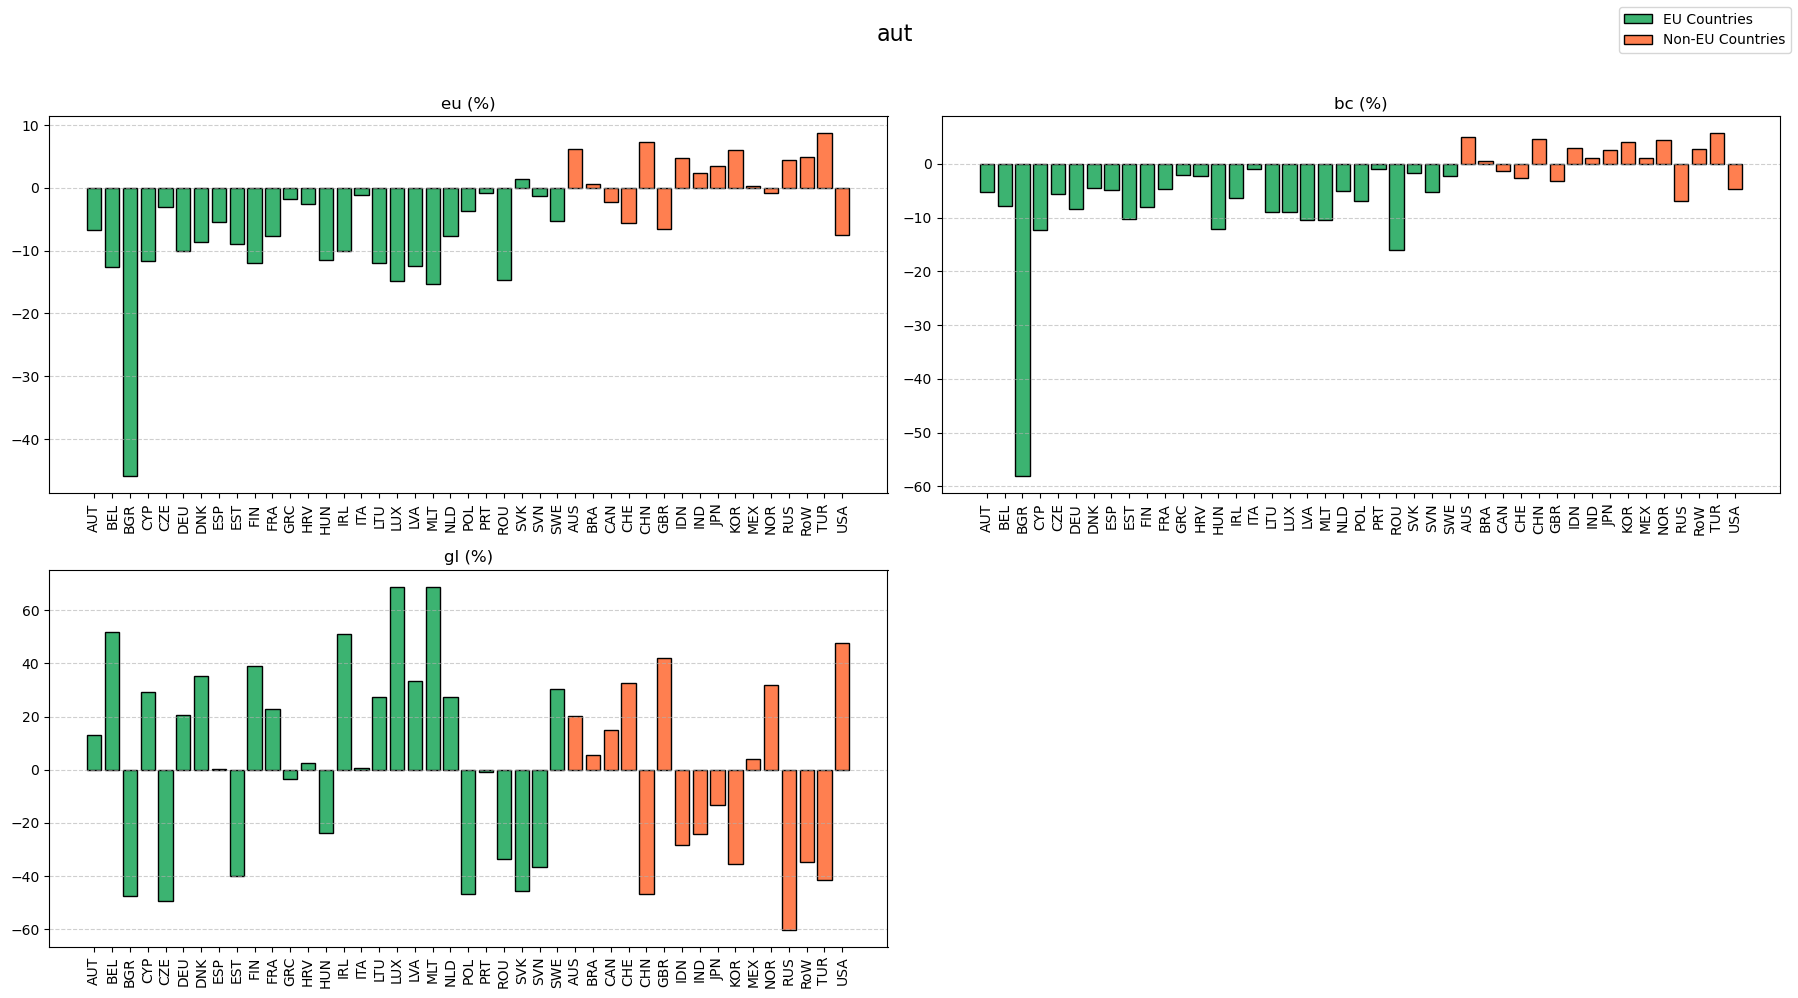

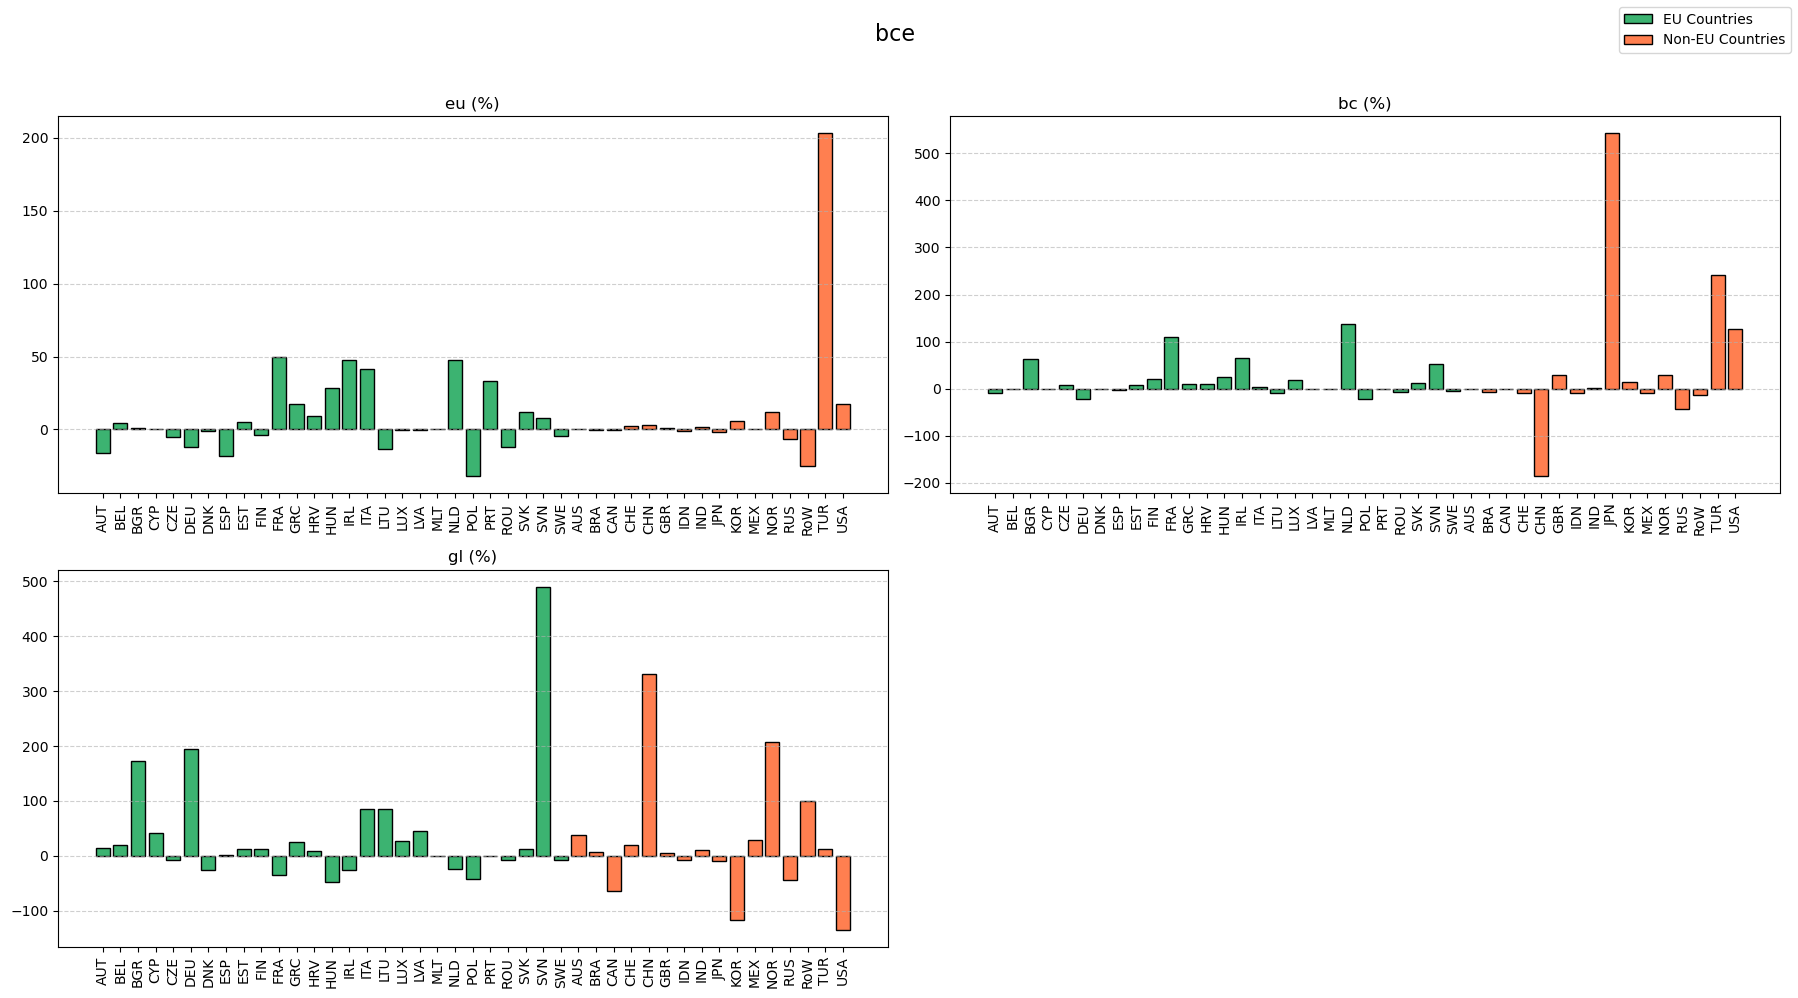

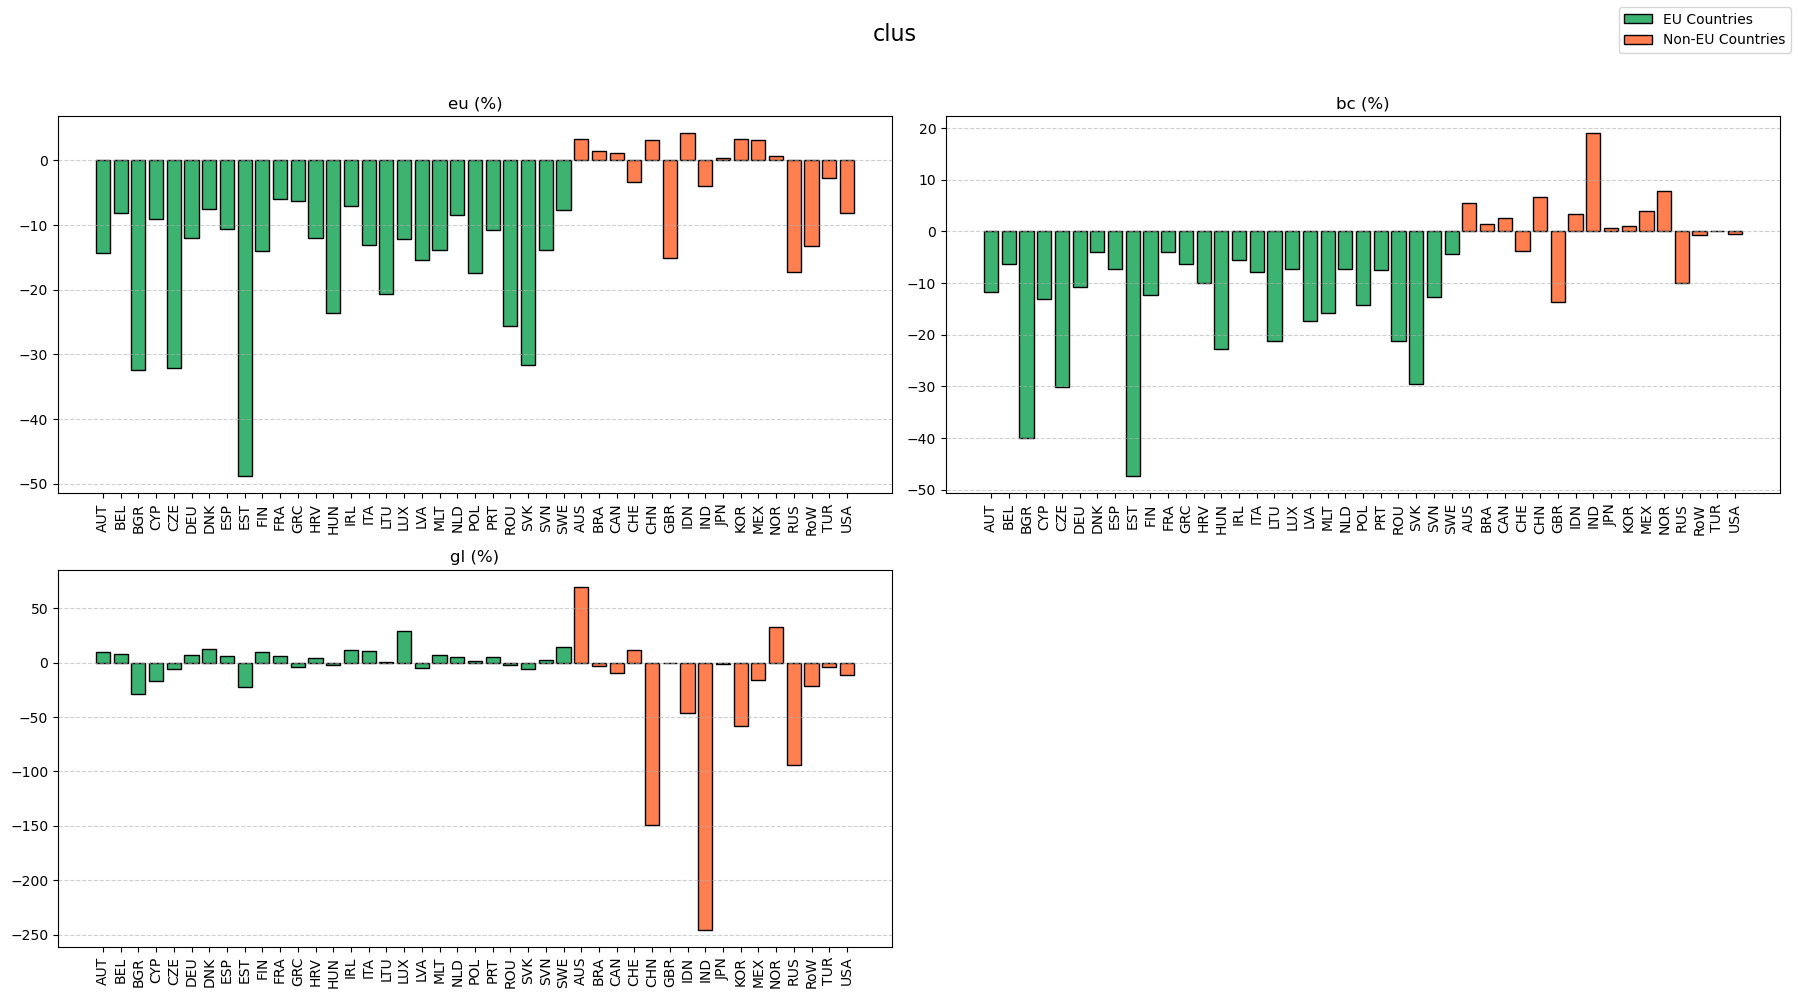

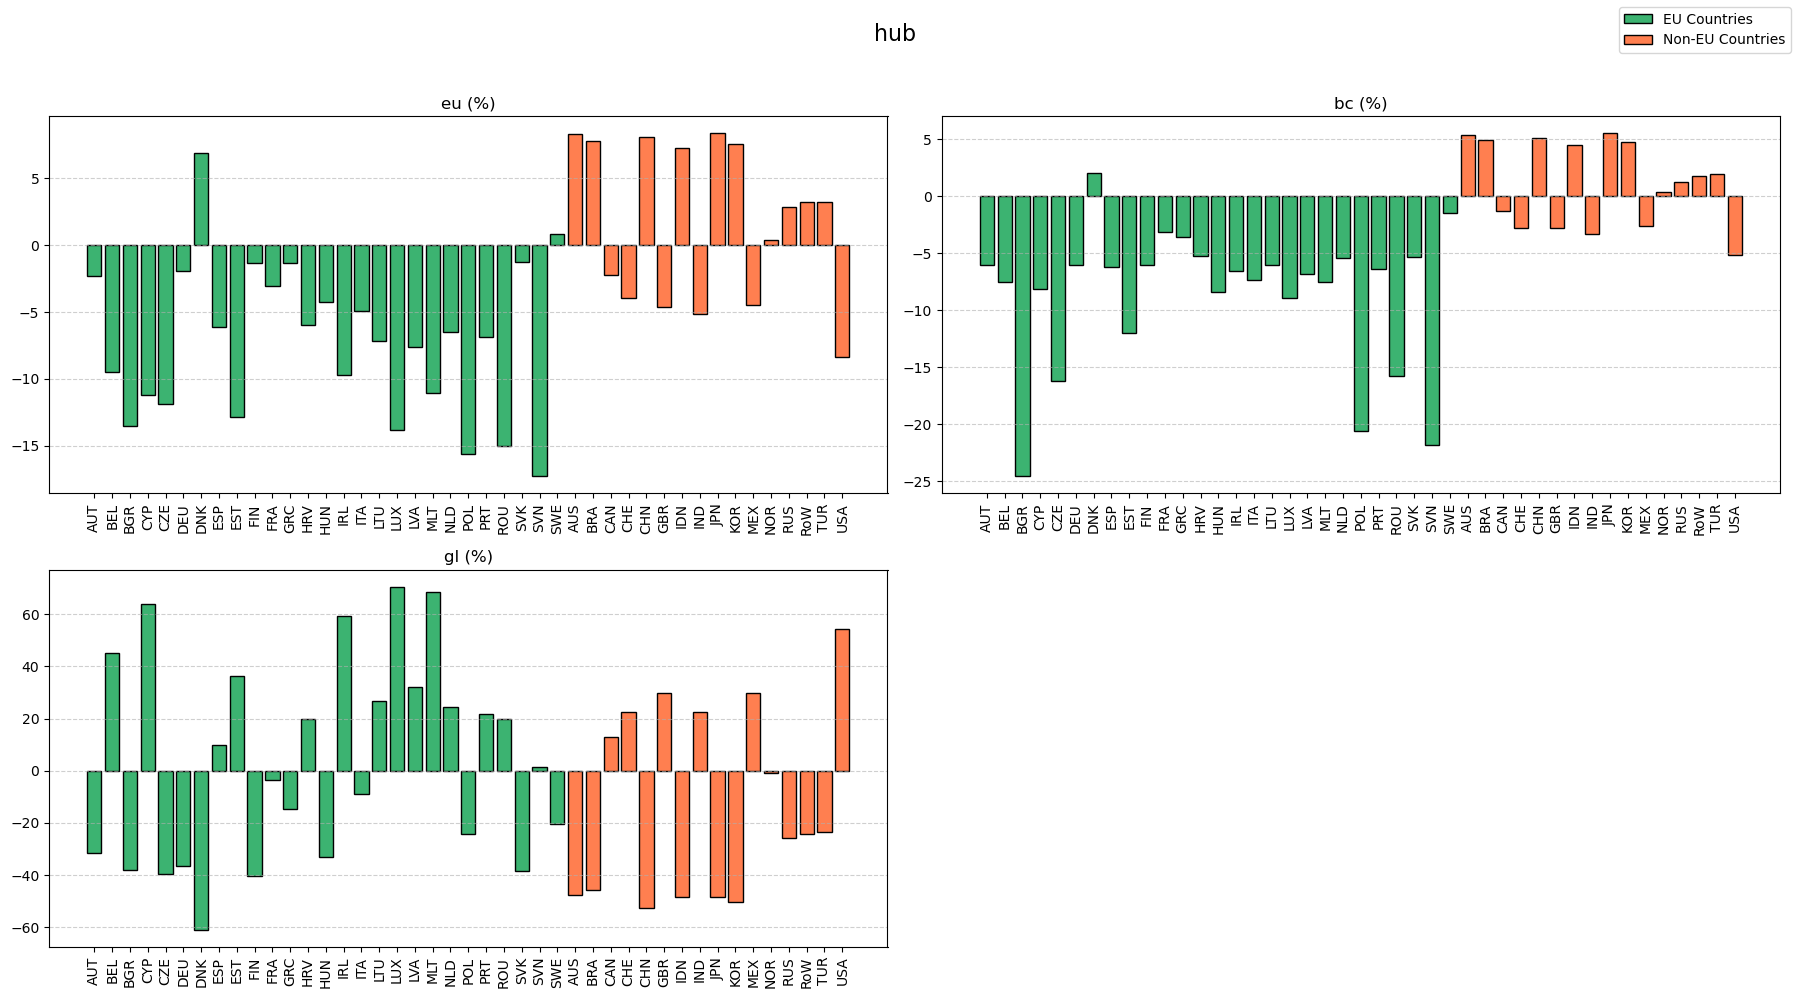

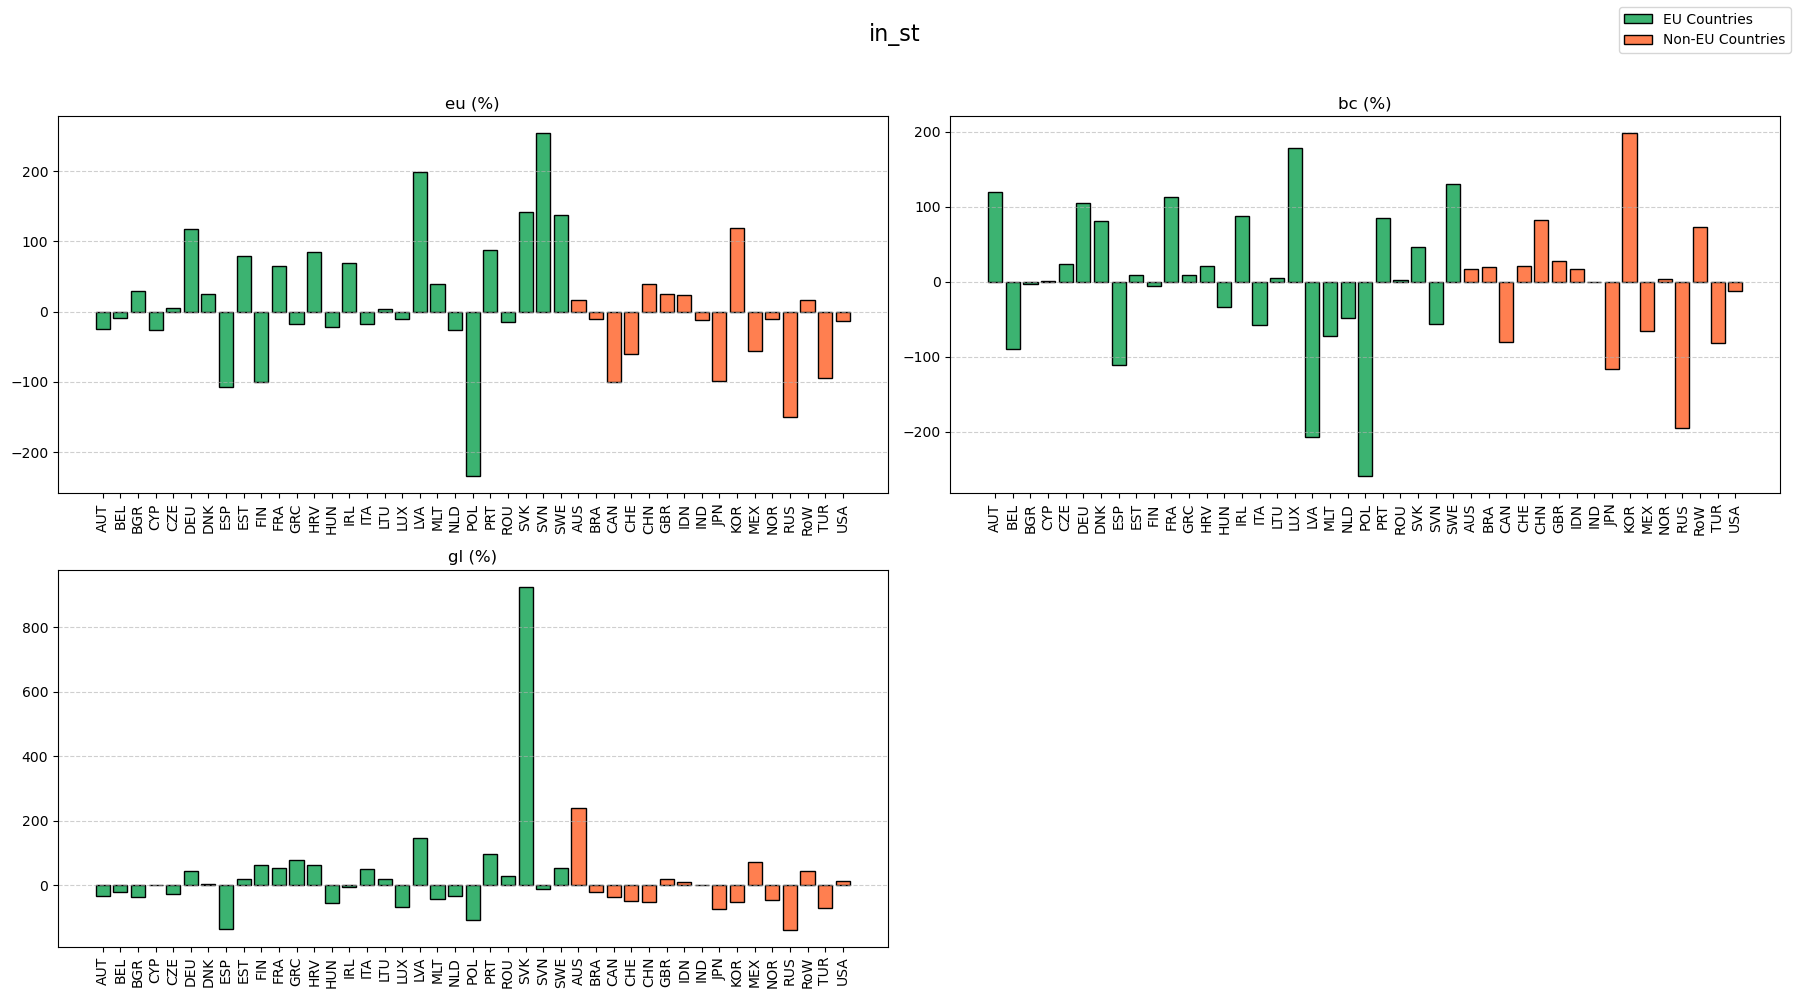

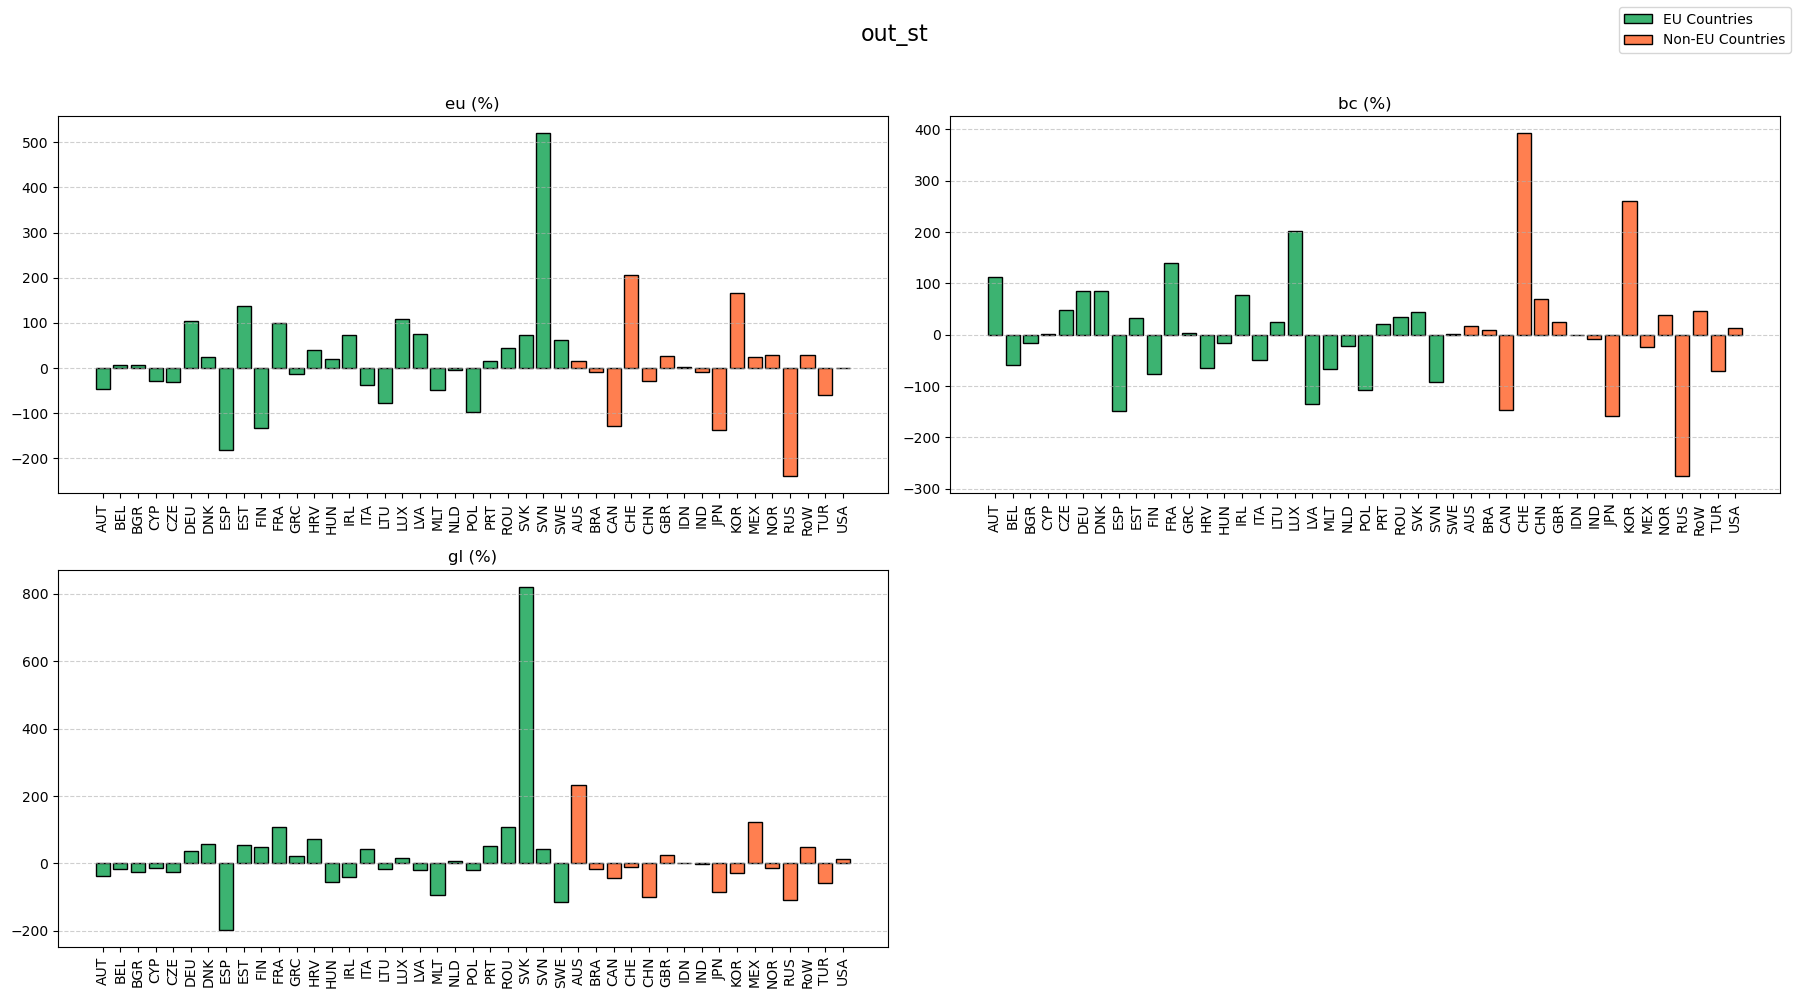

In [221]:

#compute the diff between the node measures of each country between 2020 and policy, divided by std (for country)
eu_countries = {
    'AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA',
    'GRC', 'HRV', 'HUN', 'IRL', 'ITA', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD',
    'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE'
}
metrics = {
    "clus": clus_c,
    "hub": hub_c,
    "aut": aut_c,
    "in_st": In_strength_c,
    "out_st": Out_strength_c,
    "bce": bce_c,
}

results = {}

for metric_name, metric_data in metrics.items():
    # Extract time series (2010–2020) and scenario snapshots ('eu', 'gl', 'bc')
    year_series = {year: metric_data[year] for year in range(2010, 2021)}
    df_years = pd.DataFrame(year_series)  # shape: (countries, years)

    std = df_years.std(axis=1)
    val_2020 = df_years[2020]

    # Get values for each scenario and compute relative differences
    diff_eu = (metric_data['eu'] - val_2020) / std
    diff_gl = (metric_data['gl'] - val_2020) / std
    diff_bc = (metric_data['bc'] - val_2020) / std

    # Combine results
    df_metric = pd.DataFrame({
        (metric_name, 'std'): std,
        (metric_name, 'eu'): diff_eu,
        (metric_name, 'gl'): diff_gl,
        (metric_name, 'bc'): diff_bc,
    })

    results[metric_name] = df_metric

# Combine all metric-level data
final_df = pd.concat(results.values(), axis=1)
Rel_diff_std = final_df.sort_index(axis=1, level=0)


#----------------------------------plot
# Custom colors
eu_color = 'mediumseagreen'
non_eu_color = 'coral'

# Loop over each metric (e.g., 'Clustering', 'Betweenness', etc.)
for metric in Rel_diff_std.columns.levels[0]:
    fig, axs = plt.subplots(2,2, figsize=(18, 10))
    fig.suptitle(f"{metric}", fontsize=16)

    # Flatten axes for easy iteration
    axs = axs.flatten()
    # Hide the bottom-right subplot (index 3)
    fig.delaxes(axs[3])  # delete unused axis

    for i, sub_measure in enumerate(['eu', 'bc', 'gl']):
        ax = axs[i]
        values = Rel_diff_std[(metric, sub_measure)] * 100  # scale to percentage

        # Reorder: EU first, then non-EU
        eu_vals = values[values.index.isin(eu_countries)].sort_index()
        non_eu_vals = values[~values.index.isin(eu_countries)].sort_index()
        ordered = pd.concat([eu_vals, non_eu_vals])
        colors = [eu_color]*len(eu_vals) + [non_eu_color]*len(non_eu_vals)

        # Plot
        ax.bar(ordered.index, ordered.values, color=colors, edgecolor='black')
        ax.set_title(f"{sub_measure.replace('_', ' ')} (%)")
        ax.tick_params(axis='x', rotation=90)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Add a shared legend
    legend_elements = [
        mpatches.Patch(facecolor=eu_color, edgecolor='black', label='EU Countries'),
        mpatches.Patch(facecolor=non_eu_color, edgecolor='black', label='Non-EU Countries')
    ]
    fig.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # Clean metric name (remove special characters and spaces)
    safe_metric = re.sub(r'[^\w\-]', '_', metric)

    # Then use it in the filename
    plt.savefig(f"{safe_metric}_wrt_std.png", dpi=300)
    plt.show()

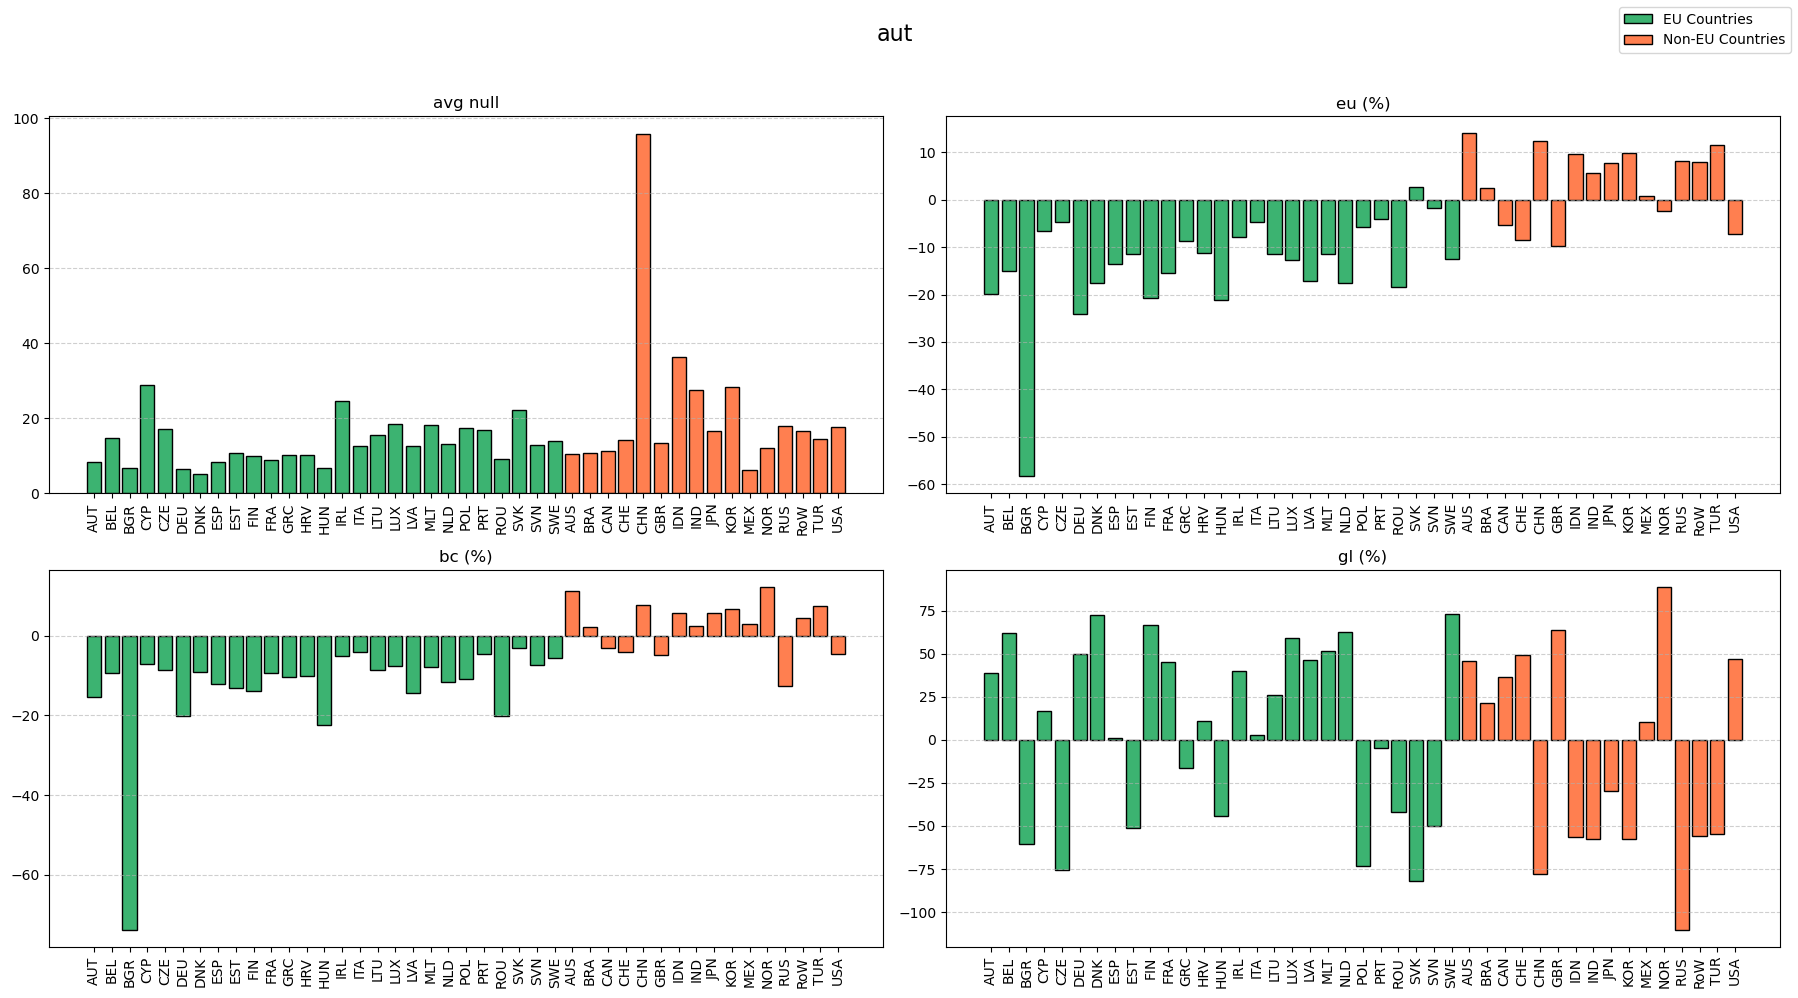

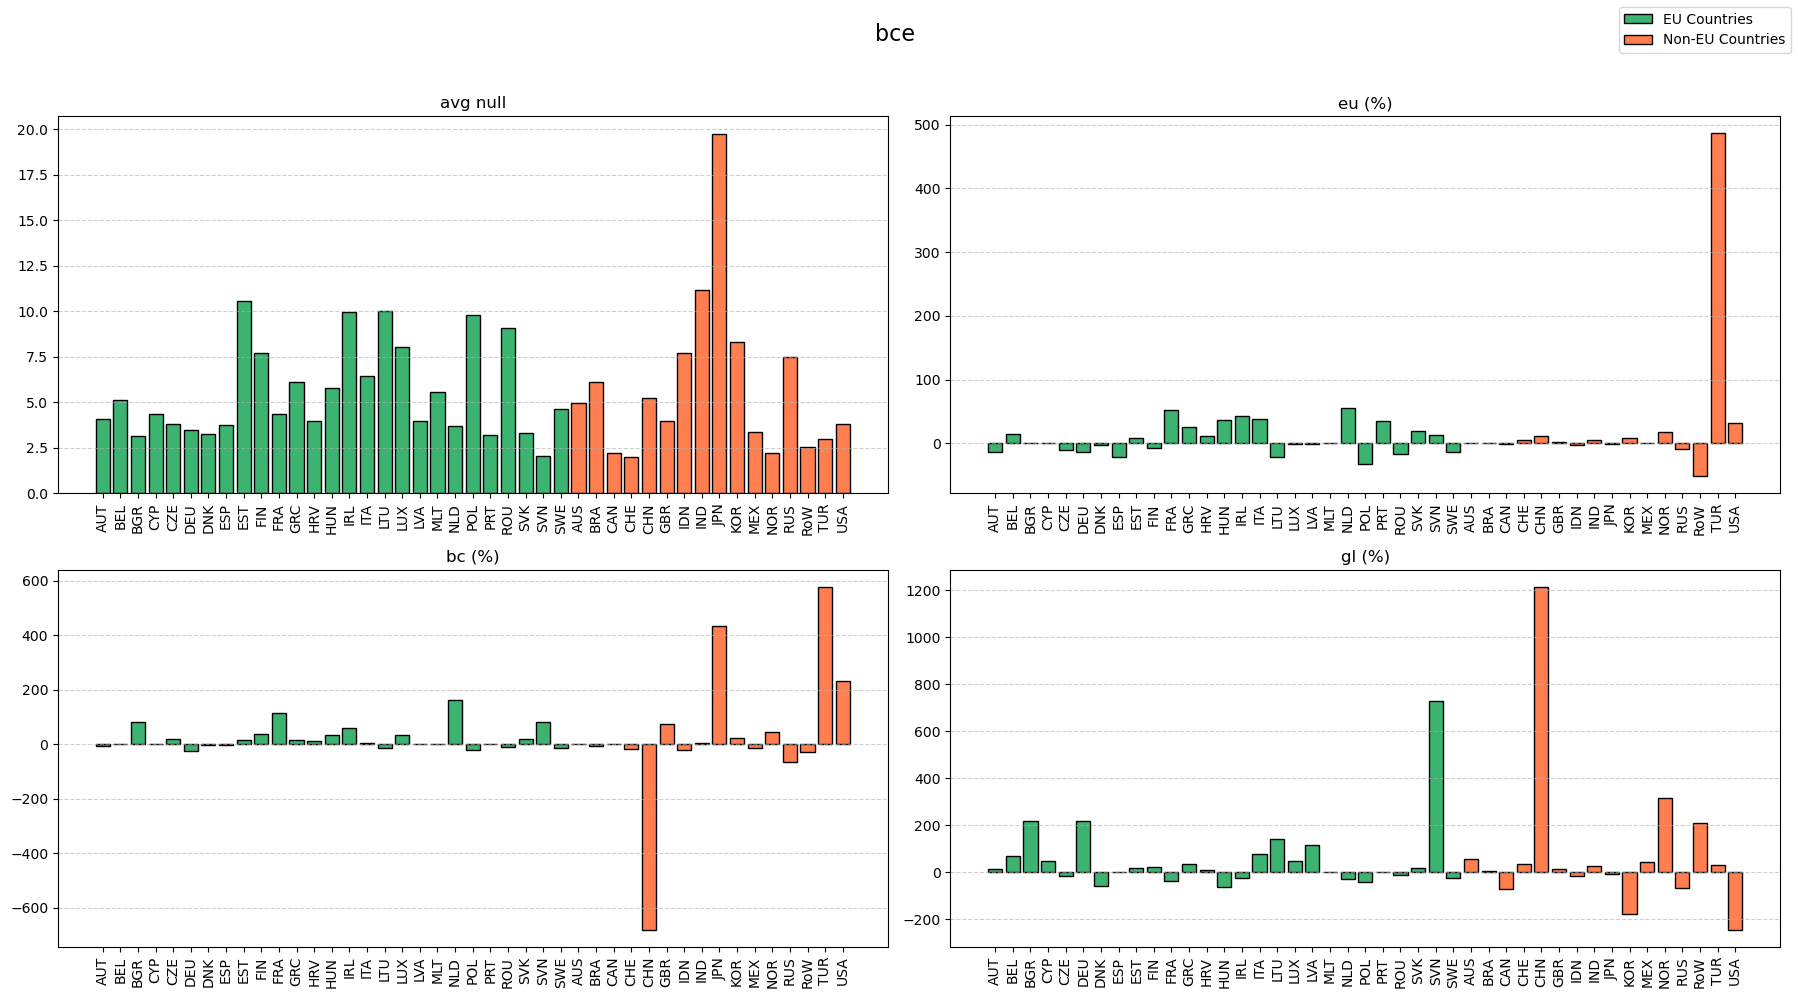

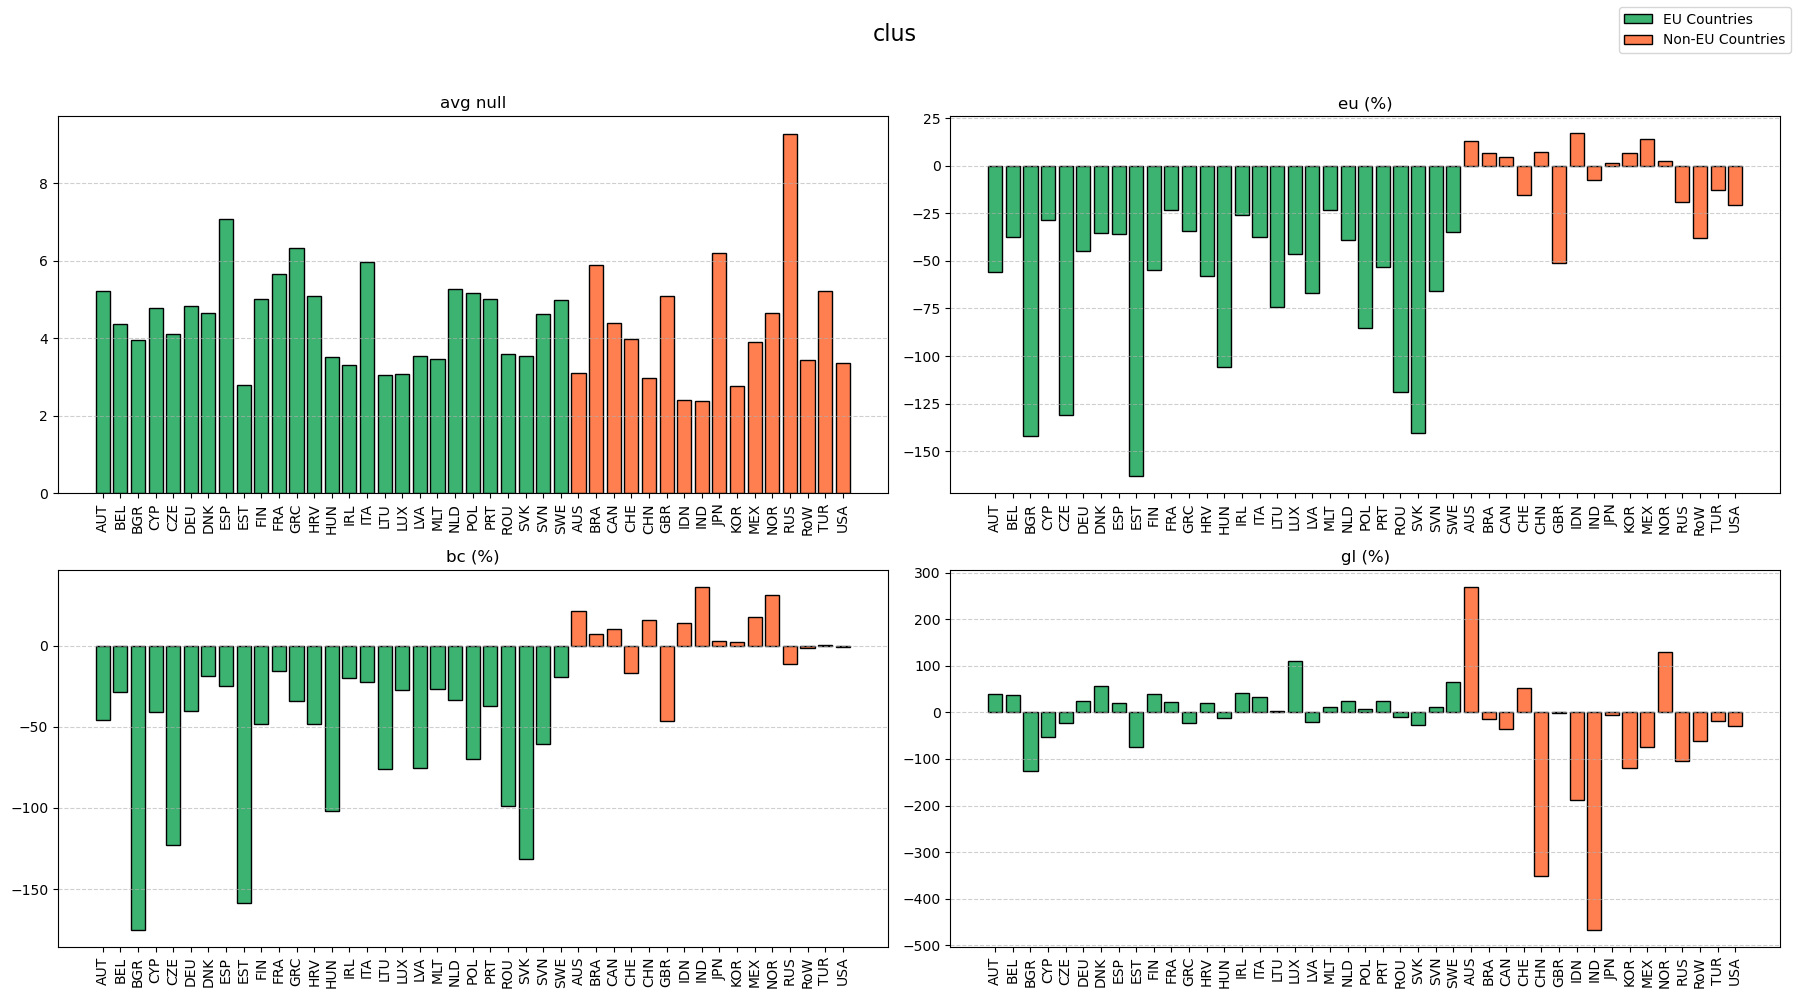

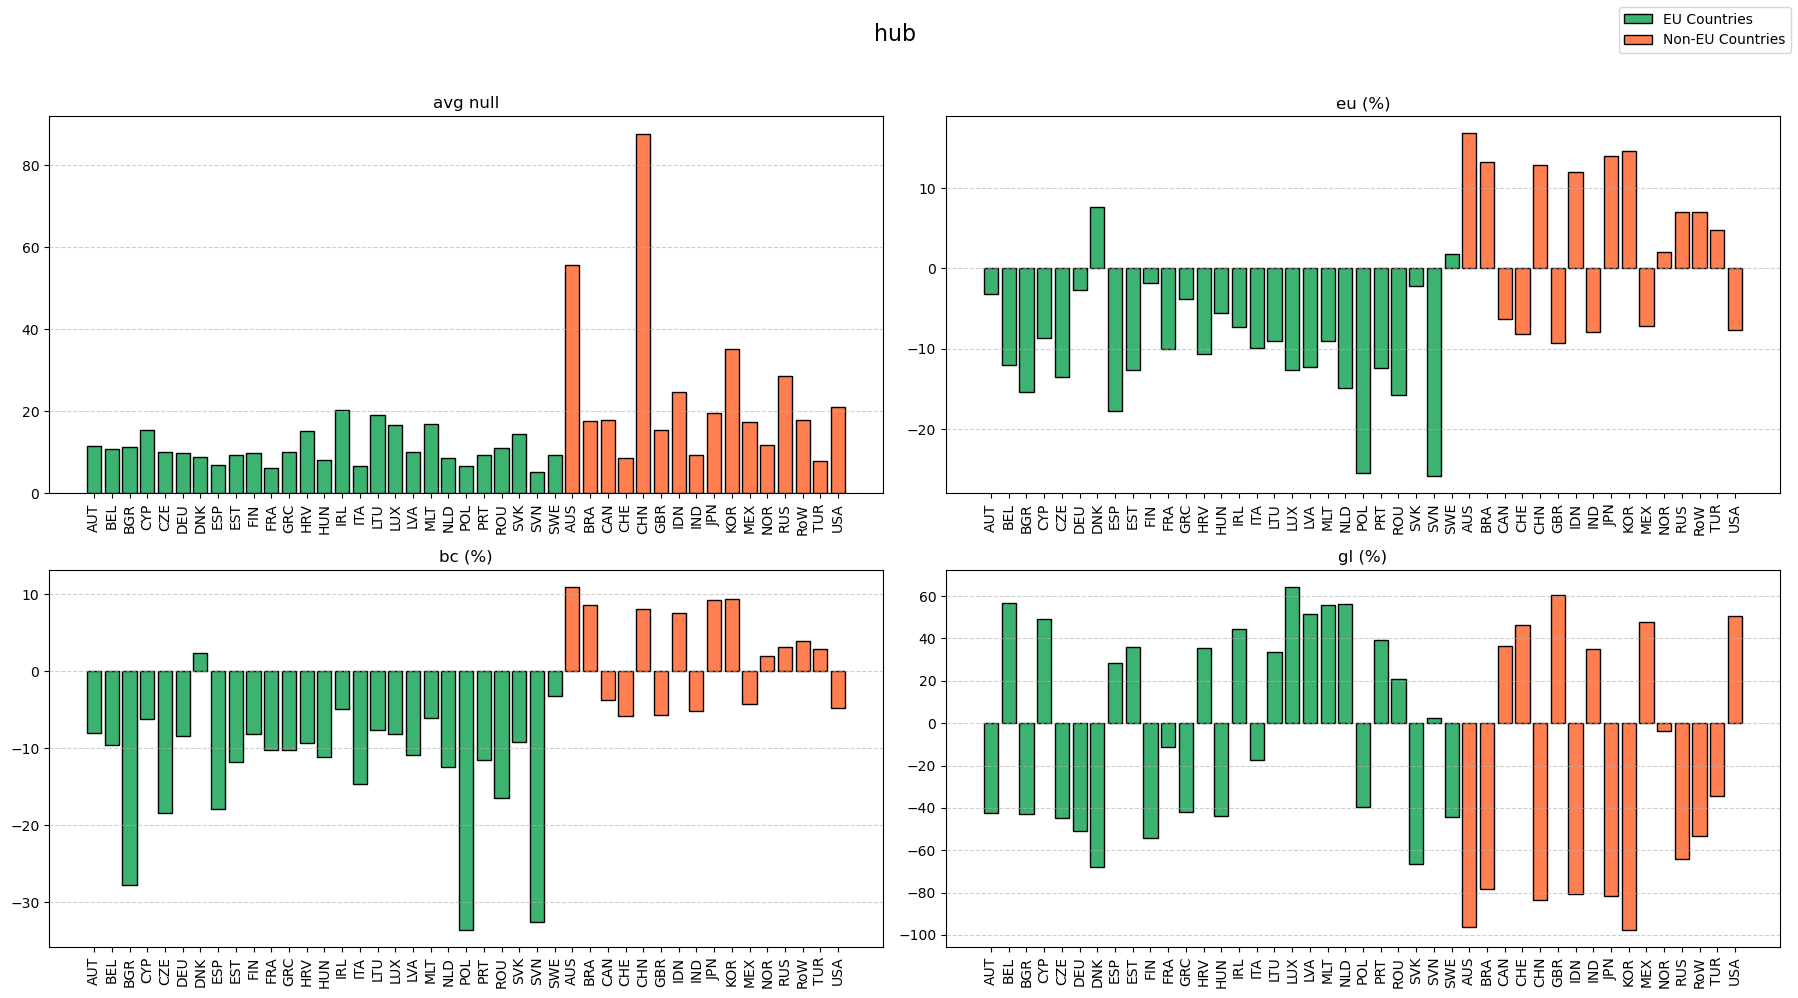

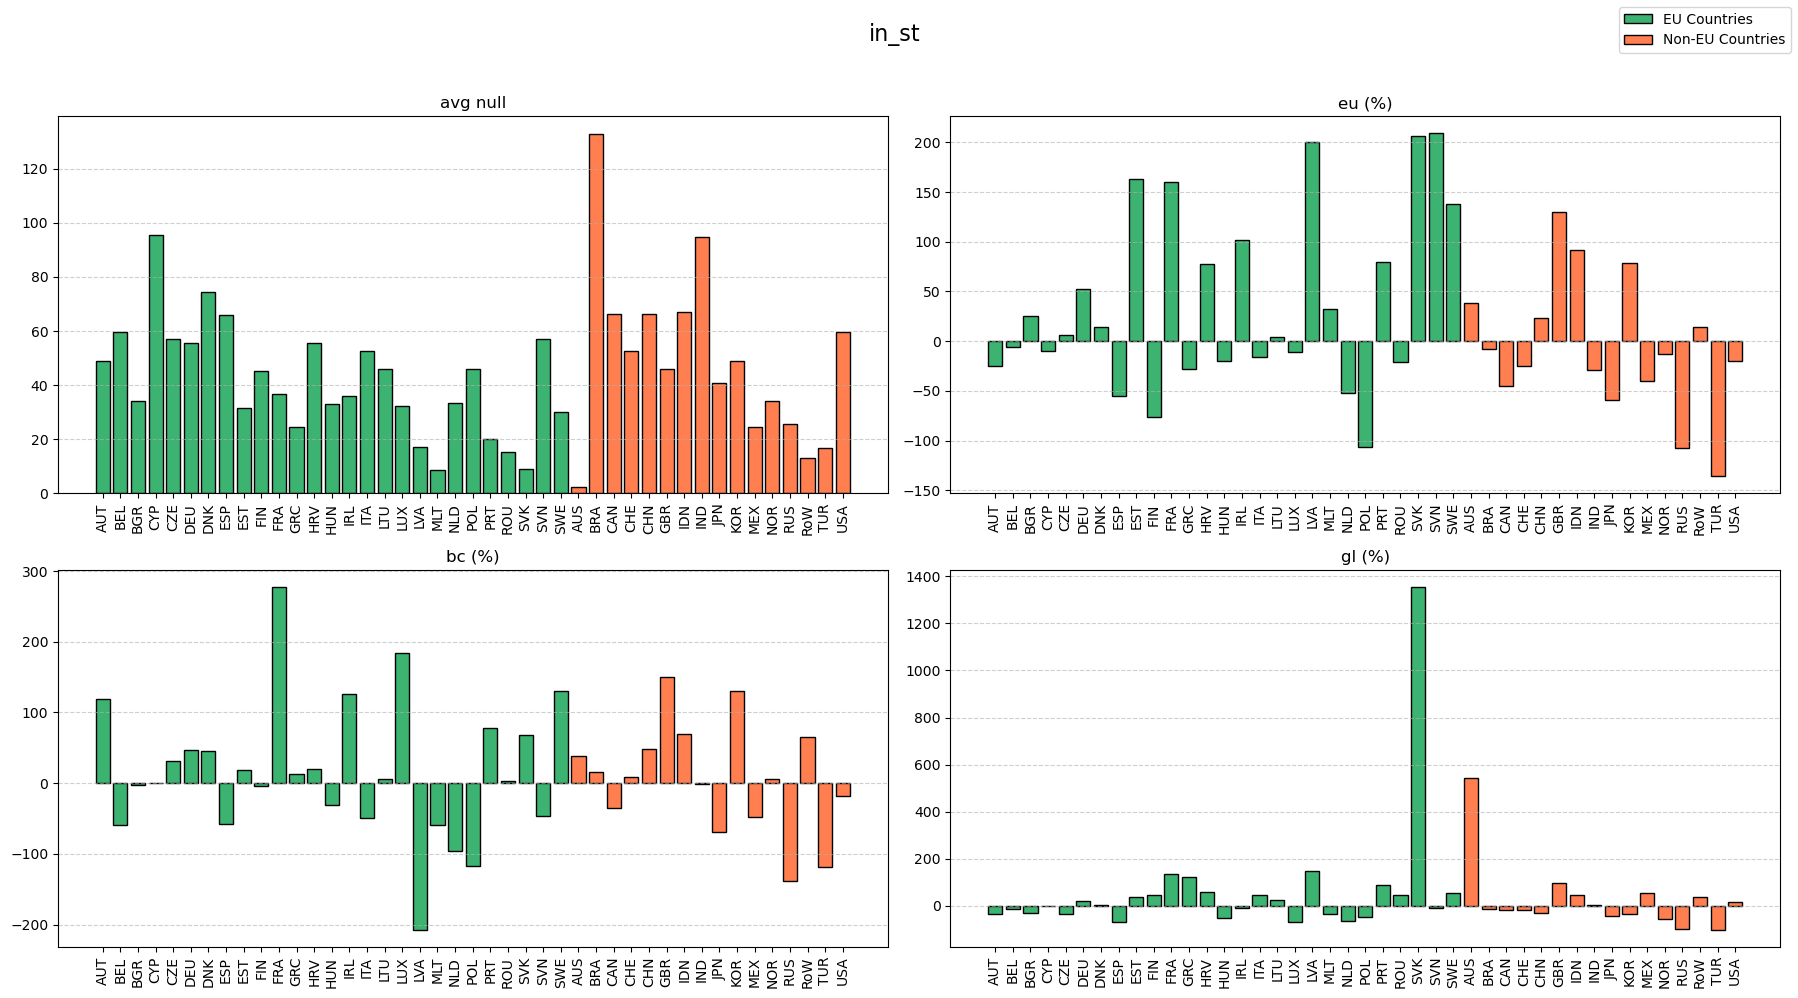

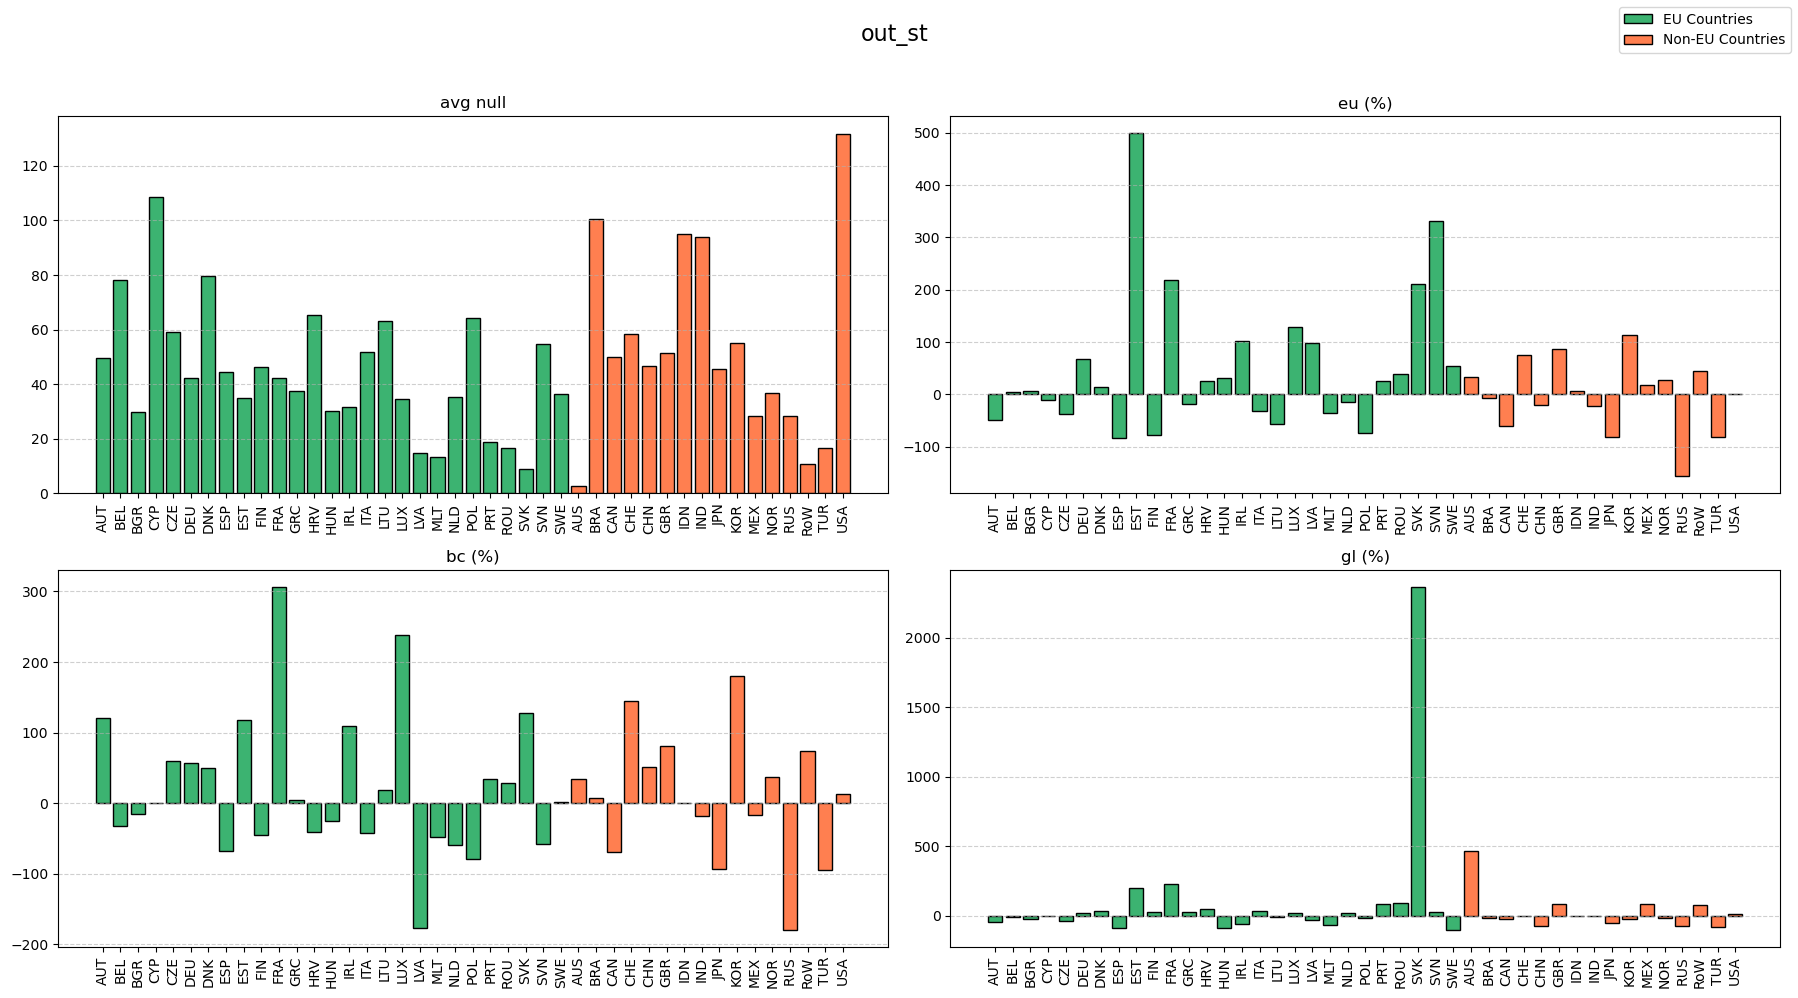

In [222]:

#compute the diff between the node measures of each country between 2020 and policy, divided by average relative increment in the null model (for country)

for metric_name, metric_data in metrics.items():
    # Build full year DataFrame (2010–2020)
    df_years = pd.DataFrame({year: metric_data[year] for year in range(2010, 2021)})
    val_2020 = df_years[2020].replace(0, pd.NA)

    # Compute avg_null per country
    year_diffs = []
    for y1, y2 in zip(range(2010, 2020), range(2011, 2021)):
        rel_diff = (df_years[y2] - df_years[y1]).abs() / df_years[y1].replace(0, pd.NA)
        year_diffs.append(rel_diff)
    avg_null = pd.concat(year_diffs, axis=1).mean(axis=1)

    # Compute normalized scenario diffs
    def rel_change(scenario_series):
        return ((scenario_series - val_2020) / val_2020) / avg_null

    rel_bc = rel_change(metric_data['bc'])
    rel_eu = rel_change(metric_data['eu'])
    rel_gl = rel_change(metric_data['gl'])

    # Construct DataFrame with MultiIndex columns
    df_metric = pd.DataFrame({
        (metric_name, 'avg_null'): avg_null,
        (metric_name, 'bc'): rel_bc,
        (metric_name, 'eu'): rel_eu,
        (metric_name, 'gl'): rel_gl,
    })

    results[metric_name] = df_metric

# Merge all into one DataFrame
final_df = pd.concat(results.values(), axis=1)
final_df.columns = pd.MultiIndex.from_tuples(final_df.columns)
Rel_diff_avg = final_df.sort_index(axis=1, level=0)





# Custom colors
eu_color = 'mediumseagreen'
non_eu_color = 'coral'

# Loop over each metric (e.g., 'Clustering', 'Betweenness', etc.)
for metric in Rel_diff_avg.columns.levels[0]:
    fig, axs = plt.subplots(2,2, figsize=(18, 10))
    fig.suptitle(f"{metric}", fontsize=16)

    # Flatten axes for easy iteration
    axs = axs.flatten()


    for i, sub_measure in enumerate(['avg_null','eu', 'bc', 'gl']):
        ax = axs[i]
        values = Rel_diff_avg[(metric, sub_measure)] * 100  # scale to percentage

        # Reorder: EU first, then non-EU
        eu_vals = values[values.index.isin(eu_countries)].sort_index()
        non_eu_vals = values[~values.index.isin(eu_countries)].sort_index()
        ordered = pd.concat([eu_vals, non_eu_vals])
        colors = [eu_color]*len(eu_vals) + [non_eu_color]*len(non_eu_vals)

        # Plot
        ax.bar(ordered.index, ordered.values, color=colors, edgecolor='black')
        title = sub_measure.replace('_', ' ')
        if sub_measure != 'avg_null':
            title += ' (%)'
        ax.set_title(title)
        ax.tick_params(axis='x', rotation=90)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        

    # Add a shared legend
    legend_elements = [
        mpatches.Patch(facecolor=eu_color, edgecolor='black', label='EU Countries'),
        mpatches.Patch(facecolor=non_eu_color, edgecolor='black', label='Non-EU Countries')
    ]
    fig.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # Clean metric name (remove special characters and spaces)
    safe_metric = re.sub(r'[^\w\-]', '_', metric)

    # Then use it in the filename
    plt.savefig(f"{safe_metric}_wrt_avgnull.png", dpi=300)
    plt.show()

In [ ]:
Rel_diff_std.index =Rel_diff_std.index.astype(str)
Rel_diff_avg.index = Rel_diff_avg.index.astype(str)
Rel_diff_std.to_parquet('Rel_diff_std.parquet', index=True)
Rel_diff_avg.to_parquet('Rel_diff_avg.parquet', index=True)

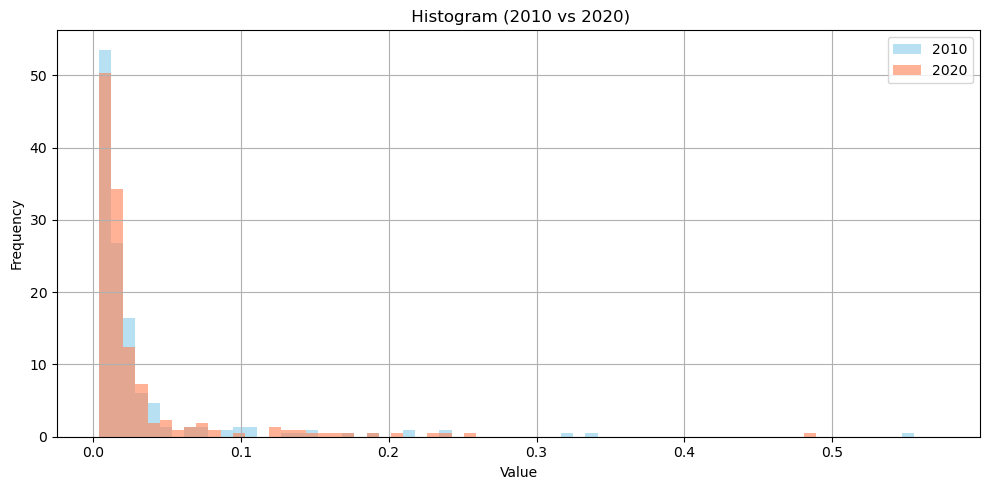

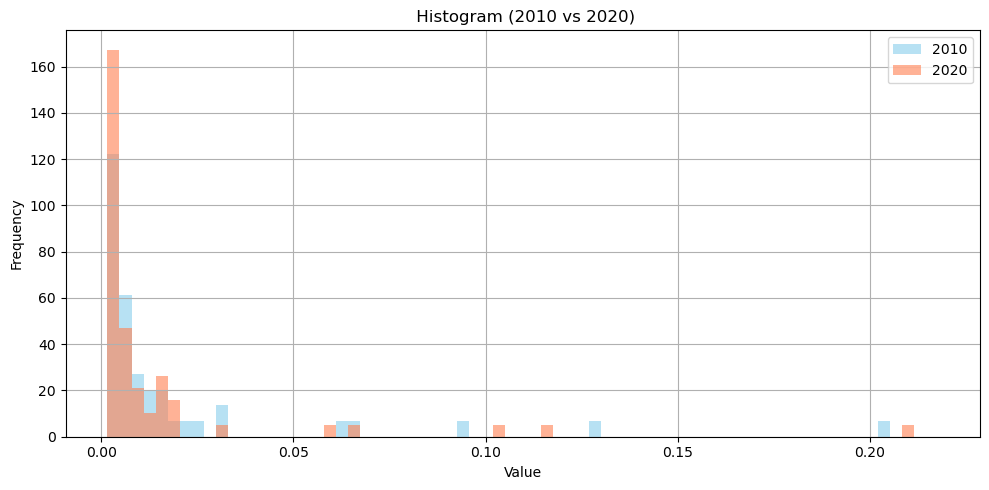

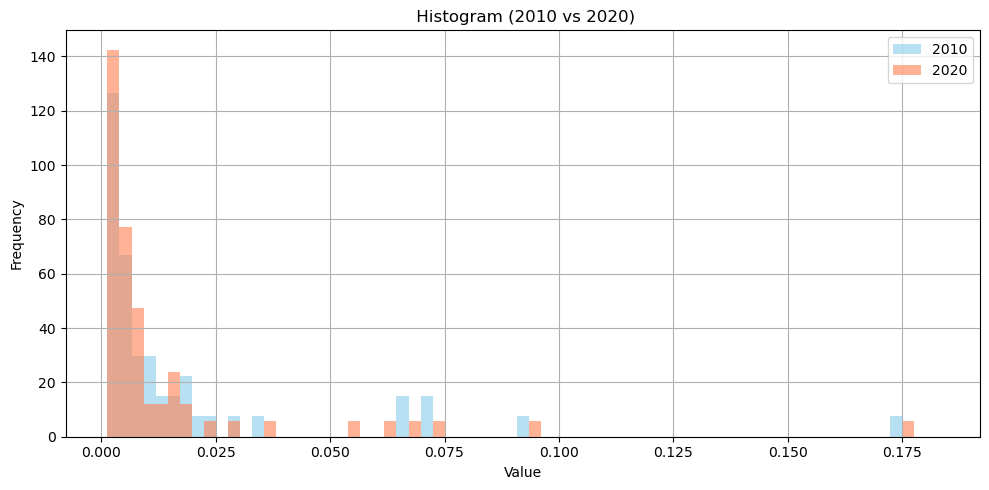

In [15]:
# Input dictionaries (e.g., clus, hub, etc.)
input_dicts = {
    'bce': bce,
    'hub': hub,
    'aut': aut }

avg_condit_dict = {
    'bce': avg_condit_bce,
    'hub': avg_condit_hub,
    'aut': avg_condit_aut}

value_columns = {
    'bce': 'betweenness',
    'hub': 'hub_score',
    'aut': 'authority_score'}

for name, data in input_dicts.items():
    col = value_columns[name]
    bins = avg_condit_dict[name].index.to_numpy()
    
    df_2010 = data[2010]
    df_2020 = data[2020]

    # If 'Node' is index, reset to use as column
    #if df_2010.index.name == 'Node' or 'Node' not in df_2010.columns:
        #df_2010 = df_2010.reset_index()
        #df_2020 = df_2020.reset_index()

    # Sort to align both
    #df_2010 = df_2010.sort_values('Node')
    #df_2020 = df_2020.sort_values('Node')

    values_2010 = df_2010[col].values
    values_2020 = df_2020[col].values
    
    
     # Plot histograms
    plt.figure(figsize=(10, 5))
    plt.hist(values_2010, bins=bins, alpha=0.6, label='2010', density=True, color='skyblue')
    plt.hist(values_2020, bins=bins, alpha=0.6, label='2020', density=True, color='coral')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(' Histogram (2010 vs 2020)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name}_histogram_comparison_2010-20.png", dpi=300)
    plt.show()
    plt.close()


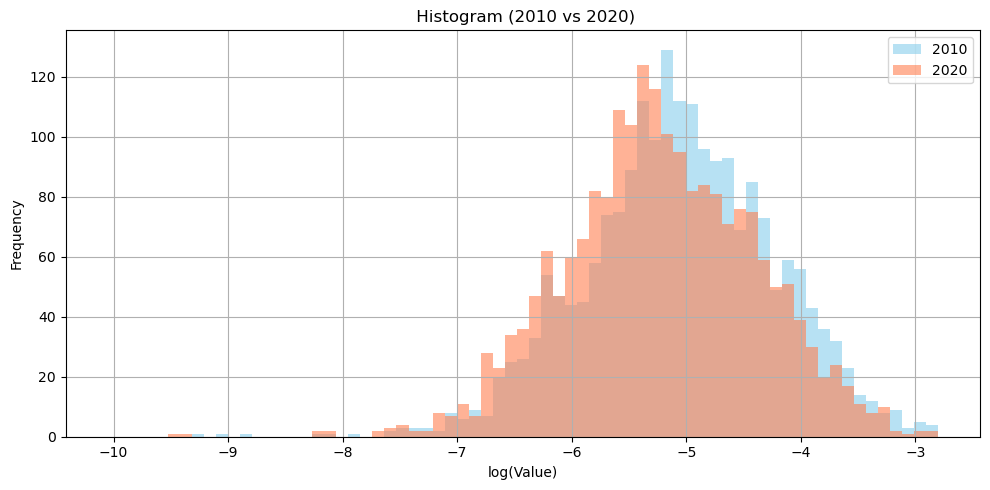

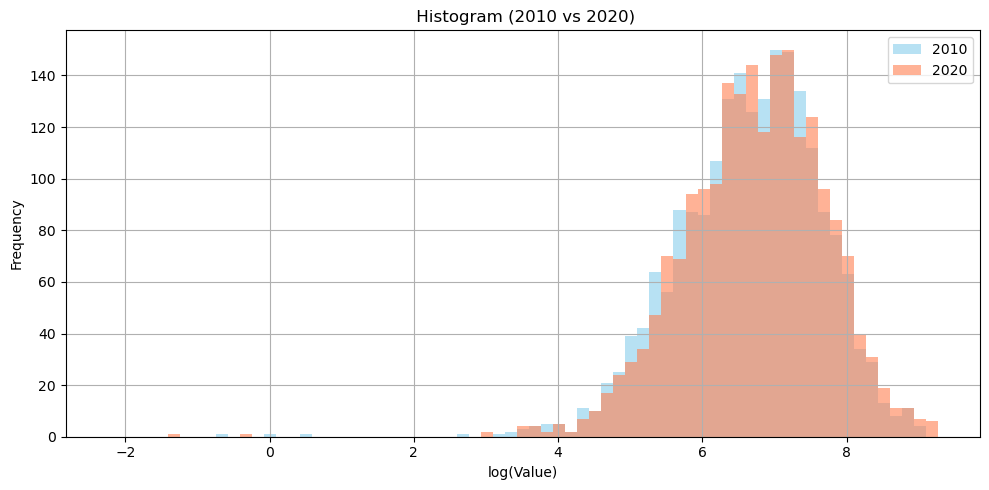

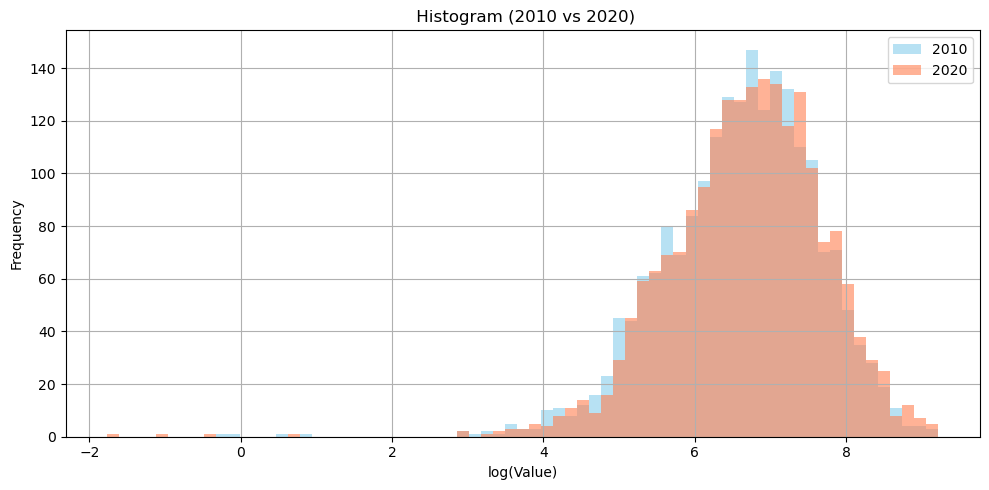

In [150]:
# Input dictionaries (e.g., clus, hub, etc.)
input_log_dicts = {
    'clus': clus,
    'In_strength': In_strength,
    'Out_strength': Out_strength }

avg_condit_dict = {
    'clus': avg_condit_clus,
    'In_strength': avg_condit_in,
    'Out_strength': avg_condit_out}

value_columns = {
    'clus': 'Clustering_Coefficient',
    'In_strength': 'In_Strength',
    'Out_strength': 'Out_strength'}

for name, data in input_log_dicts.items():
    col = value_columns[name]
    bins = avg_condit_dict[name].index.to_numpy()
    
    df_2010 = data[2010]
    df_2020 = data[2020]

    # If 'Node' is index, reset to use as column
    #if df_2010.index.name == 'Node' or 'Node' not in df_2010.columns:
        #df_2010 = df_2010.reset_index()
        #df_2020 = df_2020.reset_index()

    # Sort to align both
    #df_2010 = df_2010.sort_values('Node')
    #df_2020 = df_2020.sort_values('Node')

    values_2010 = df_2010[col].values
    values_2020 = df_2020[col].values

    values_2010 = np.log10(values_2010)
    values_2020 = np.log10(values_2020)
    

     # Plot histograms
    plt.figure(figsize=(10, 5))
    plt.hist(values_2010, bins=bins, alpha=0.6, label='2010', color='skyblue')
    plt.hist(values_2020, bins=bins, alpha=0.6, label='2020', color='coral')
    plt.xlabel('log(Value)')
    plt.ylabel('Frequency')
    plt.title(' Histogram (2010 vs 2020)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name}_histogram_comparison_2010-20.png", dpi=300)
    plt.show()
    plt.close()


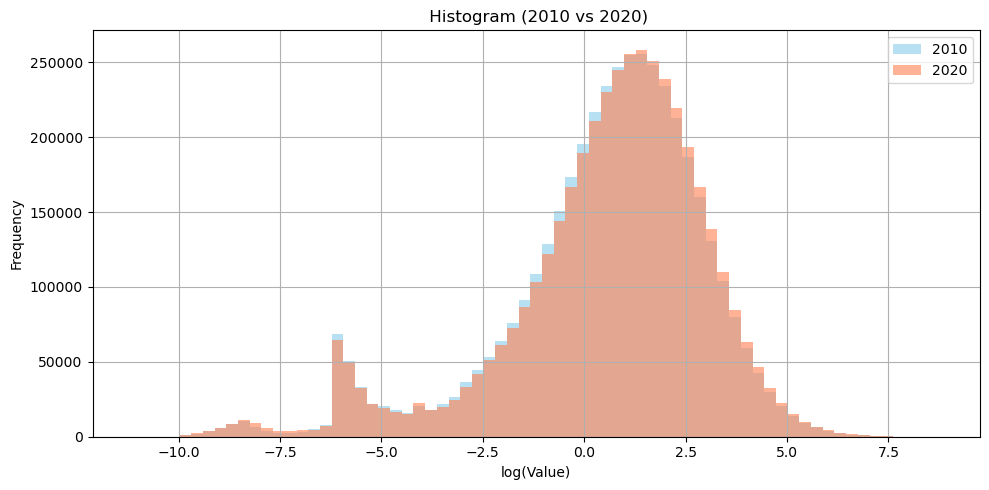

In [152]:
avg_condit_weights = pd.read_parquet('avg_condit_weights.parquet')
bins = avg_condit_weights.index.to_numpy()

values_2010 = weights[2010]
values_2020 = weights[2020]

values_2010 = np.log10(values_2010)
values_2020 = np.log10(values_2020)
    

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(values_2010, bins=bins, alpha=0.6, label='2010', color='skyblue')
plt.hist(values_2020, bins=bins, alpha=0.6, label='2020', color='coral')
plt.xlabel('log(Value)')
plt.ylabel('Frequency')
plt.title(' Histogram (2010 vs 2020)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("weights_histogram_comparison_2010-20.png", dpi=300)
plt.show()
plt.close()

In [ ]:
from PIL import Image

# Open your two images
img1 = Image.open('avg_condit_weights.png')
img2 = Image.open('weights_histogram_comparison_2010-20.png')

# Ensure same height by padding the shorter one (optional: skip if heights match)
if img1.height != img2.height:
    max_height = max(img1.height, img2.height)
    
    def pad_image(img, target_height):
        result = Image.new("RGB", (img.width, target_height), (255, 255, 255))
        result.paste(img, (0, (target_height - img.height) // 2))
        return result

    img1 = pad_image(img1, max_height)
    img2 = pad_image(img2, max_height)

# Create new image wide enough to fit both at full resolution
total_width = img1.width + img2.width
merged_img = Image.new("RGB", (total_width, img1.height))

# Paste images side by side
merged_img.paste(img1, (0, 0))                  # Left
merged_img.paste(img2, (img1.width, 0))         # Right
# Save or show
merged_img.save('avg_condit_weights_1.png')
merged_img.show()


# Open your two images
img1 = Image.open('avg_condit_clus.png')
img2 = Image.open('clus_histogram_comparison_2010-20.png')

# Ensure same height by padding the shorter one (optional: skip if heights match)
if img1.height != img2.height:
    max_height = max(img1.height, img2.height)
    
    def pad_image(img, target_height):
        result = Image.new("RGB", (img.width, target_height), (255, 255, 255))
        result.paste(img, (0, (target_height - img.height) // 2))
        return result

    img1 = pad_image(img1, max_height)
    img2 = pad_image(img2, max_height)

# Create new image wide enough to fit both at full resolution
total_width = img1.width + img2.width
merged_img = Image.new("RGB", (total_width, img1.height))

# Paste images side by side
merged_img.paste(img1, (0, 0))                  # Left
merged_img.paste(img2, (img1.width, 0))         # Right
# Save or show
merged_img.save('avg_condit_clus_1.png')
merged_img.show()



# Open your two images
img1 = Image.open('avg_condit_bc.png')
img2 = Image.open('bce_histogram_comparison_2010-20.png')

# Ensure same height by padding the shorter one (optional: skip if heights match)
if img1.height != img2.height:
    max_height = max(img1.height, img2.height)
    
    def pad_image(img, target_height):
        result = Image.new("RGB", (img.width, target_height), (255, 255, 255))
        result.paste(img, (0, (target_height - img.height) // 2))
        return result

    img1 = pad_image(img1, max_height)
    img2 = pad_image(img2, max_height)

# Create new image wide enough to fit both at full resolution
total_width = img1.width + img2.width
merged_img = Image.new("RGB", (total_width, img1.height))

# Paste images side by side
merged_img.paste(img1, (0, 0))                  # Left
merged_img.paste(img2, (img1.width, 0))         # Right
# Save or show
merged_img.save('avg_condit_bce_1.png')
merged_img.show()




In [55]:
# Open your two images
img1 = Image.open('avg_condit_in.png')
img2 = Image.open('In_strength_histogram_comparison_2010-20.png')

# Ensure same height by padding the shorter one (optional: skip if heights match)
if img1.height != img2.height:
    max_height = max(img1.height, img2.height)
    
    def pad_image(img, target_height):
        result = Image.new("RGB", (img.width, target_height), (255, 255, 255))
        result.paste(img, (0, (target_height - img.height) // 2))
        return result

    img1 = pad_image(img1, max_height)
    img2 = pad_image(img2, max_height)

# Create new image wide enough to fit both at full resolution
total_width = img1.width + img2.width
merged_img = Image.new("RGB", (total_width, img1.height))

# Paste images side by side
merged_img.paste(img1, (0, 0))                  # Left
merged_img.paste(img2, (img1.width, 0))         # Right
# Save or show
merged_img.save('avg_condit_in_1.png')
merged_img.show()


# Open your two images
img1 = Image.open('avg_condit_out.png')
img2 = Image.open('Out_strength_histogram_comparison_2010-20.png')

# Ensure same height by padding the shorter one (optional: skip if heights match)
if img1.height != img2.height:
    max_height = max(img1.height, img2.height)
    
    def pad_image(img, target_height):
        result = Image.new("RGB", (img.width, target_height), (255, 255, 255))
        result.paste(img, (0, (target_height - img.height) // 2))
        return result

    img1 = pad_image(img1, max_height)
    img2 = pad_image(img2, max_height)

# Create new image wide enough to fit both at full resolution
total_width = img1.width + img2.width
merged_img = Image.new("RGB", (total_width, img1.height))

# Paste images side by side
merged_img.paste(img1, (0, 0))                  # Left
merged_img.paste(img2, (img1.width, 0))         # Right
# Save or show
merged_img.save('avg_condit_out_1.png')
merged_img.show()

In [56]:
# Open your two images
img1 = Image.open('avg_condit_hub.png')
img2 = Image.open('hub_histogram_comparison_2010-20.png')

# Ensure same height by padding the shorter one (optional: skip if heights match)
if img1.height != img2.height:
    max_height = max(img1.height, img2.height)
    
    def pad_image(img, target_height):
        result = Image.new("RGB", (img.width, target_height), (255, 255, 255))
        result.paste(img, (0, (target_height - img.height) // 2))
        return result

    img1 = pad_image(img1, max_height)
    img2 = pad_image(img2, max_height)

# Create new image wide enough to fit both at full resolution
total_width = img1.width + img2.width
merged_img = Image.new("RGB", (total_width, img1.height))

# Paste images side by side
merged_img.paste(img1, (0, 0))                  # Left
merged_img.paste(img2, (img1.width, 0))         # Right
# Save or show
merged_img.save('avg_condit_hub_1.png')
merged_img.show()


# Open your two images
img1 = Image.open('avg_condit_aut.png')
img2 = Image.open('aut_histogram_comparison_2010-20.png')

# Ensure same height by padding the shorter one (optional: skip if heights match)
if img1.height != img2.height:
    max_height = max(img1.height, img2.height)
    
    def pad_image(img, target_height):
        result = Image.new("RGB", (img.width, target_height), (255, 255, 255))
        result.paste(img, (0, (target_height - img.height) // 2))
        return result

    img1 = pad_image(img1, max_height)
    img2 = pad_image(img2, max_height)

# Create new image wide enough to fit both at full resolution
total_width = img1.width + img2.width
merged_img = Image.new("RGB", (total_width, img1.height))

# Paste images side by side
merged_img.paste(img1, (0, 0))                  # Left
merged_img.paste(img2, (img1.width, 0))         # Right
# Save or show
merged_img.save('avg_condit_aut_1.png')
merged_img.show()

In [70]:
def correl_coeff(my_dict1, my_dict2, values1='', values2='', title=''):
    results = {
        'year': [],
        title: []
    }

    for label in all_labels:
        dict_values1 = np.array(my_dict1[label][values1])
        dict_values2 = np.array(my_dict2[label][values2])
        
        correlation = np.corrcoef(dict_values1,dict_values2)[0, 1]
        results['year'].append(label)
        results[title].append(correlation)

    return pd.DataFrame(results)

In [125]:

#compute correl coeff for measure obtained from the sparse graph involving the degree
correl_instr_indeg = correl_coeff(In_strength, Spars_degree_measures, 'In_Strength', 'in_degree', 'INS vs IND')
correl_outstr_outdeg = correl_coeff(Out_strength, Spars_degree_measures, 'Out_strength', 'out_degree', 'OUTS vs OUTD')
correl_an_ins_an_ind = correl_coeff(Aver_in_nn_in, Spars_degree_measures, 'Average_NN_In_Strength', 'avg_neigh_in_deg', 'ANN_INS vs ANN_IND')
correl_an_outs_an_outd = correl_coeff(Aver_out_nn_out, Spars_degree_measures, 'Average_NN_Out_Strength', 'avg_neigh_out_deg', 'ANN_OUTS vs ANN_OUTD')
correl_bce_indeg = correl_coeff(bce, Spars_degree_measures, 'betweenness', 'in_degree', 'Bce vs IND')
correl_bce_outdeg = correl_coeff(bce, Spars_degree_measures, 'betweenness', 'out_degree', 'Bce vs OUTD')

# Only do this if 'year' is a column
for df in [correl_instr_indeg, correl_outstr_outdeg, correl_an_ins_an_ind,
           correl_an_outs_an_outd, correl_bce_indeg, correl_bce_outdeg]:
    if 'year' in df.columns:
        df.set_index('year', inplace=True)


correlation_degree_spar = pd.concat([correl_instr_indeg, correl_outstr_outdeg, correl_an_ins_an_ind, correl_an_outs_an_outd, correl_bce_indeg, correl_bce_outdeg], axis=1)
print(correlation_degree_spar)
correlation_degree_spar.index = correlation_degree_spar.index.astype(str)
correlation_degree_spar.to_parquet('Correlation_degree_spar.parquet')

      INS vs IND  OUTS vs OUTD  ANN_INS vs ANN_IND  ANN_OUTS vs ANN_OUTD  \
year                                                                       
2010    0.034701     -0.005389            0.848374              0.570333   
2011    0.046863      0.005264            0.852050              0.567610   
2012    0.046237     -0.030115            0.850490              0.563328   
2013    0.052152     -0.015978            0.850273              0.574233   
2014    0.023923     -0.027937            0.853636              0.569777   
2015    0.027276     -0.037265            0.851248              0.568327   
2016    0.015880     -0.023140            0.858305              0.564939   
2017    0.048625     -0.021244            0.859456              0.565621   
2018    0.034718     -0.001879            0.863857              0.574175   
2019    0.019187     -0.020520            0.866475              0.575907   
2020    0.028910     -0.016833            0.861179              0.572606   
eu      0.05

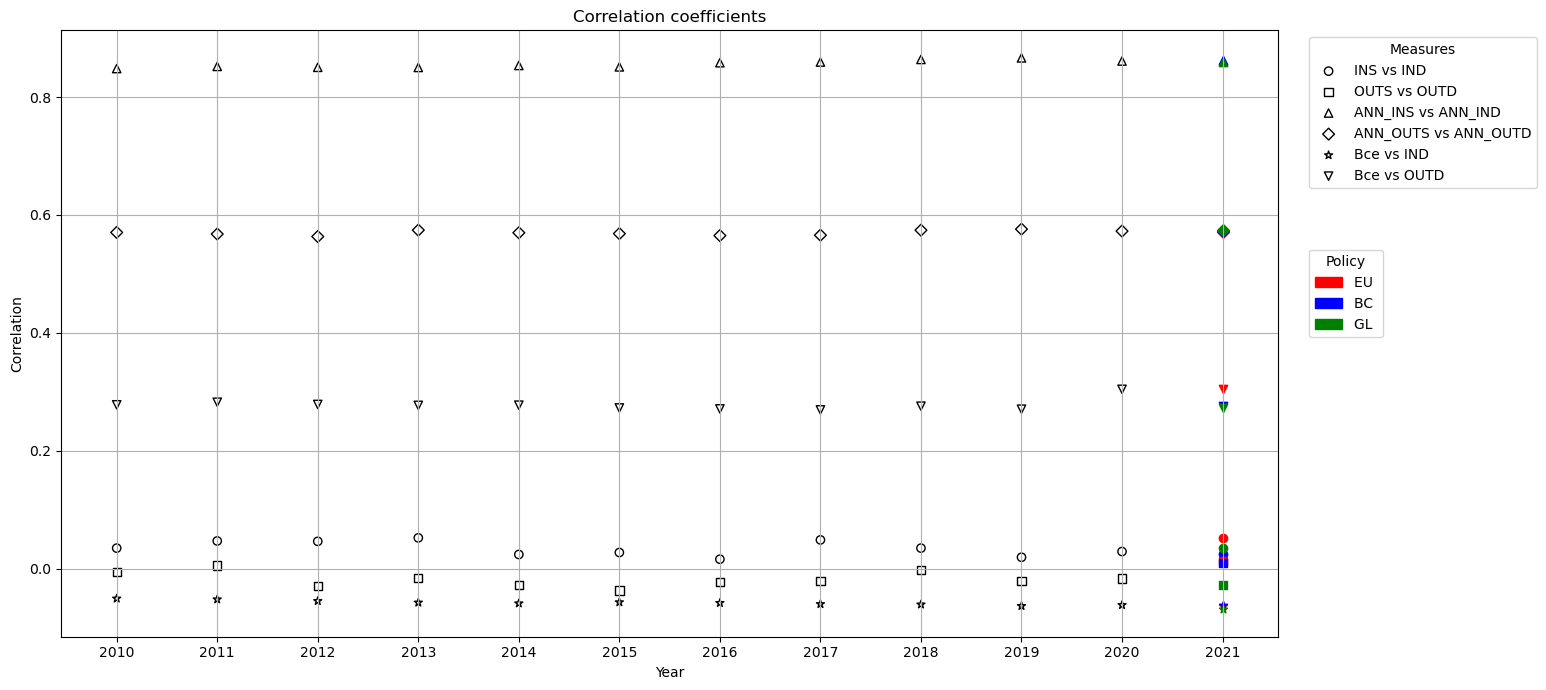

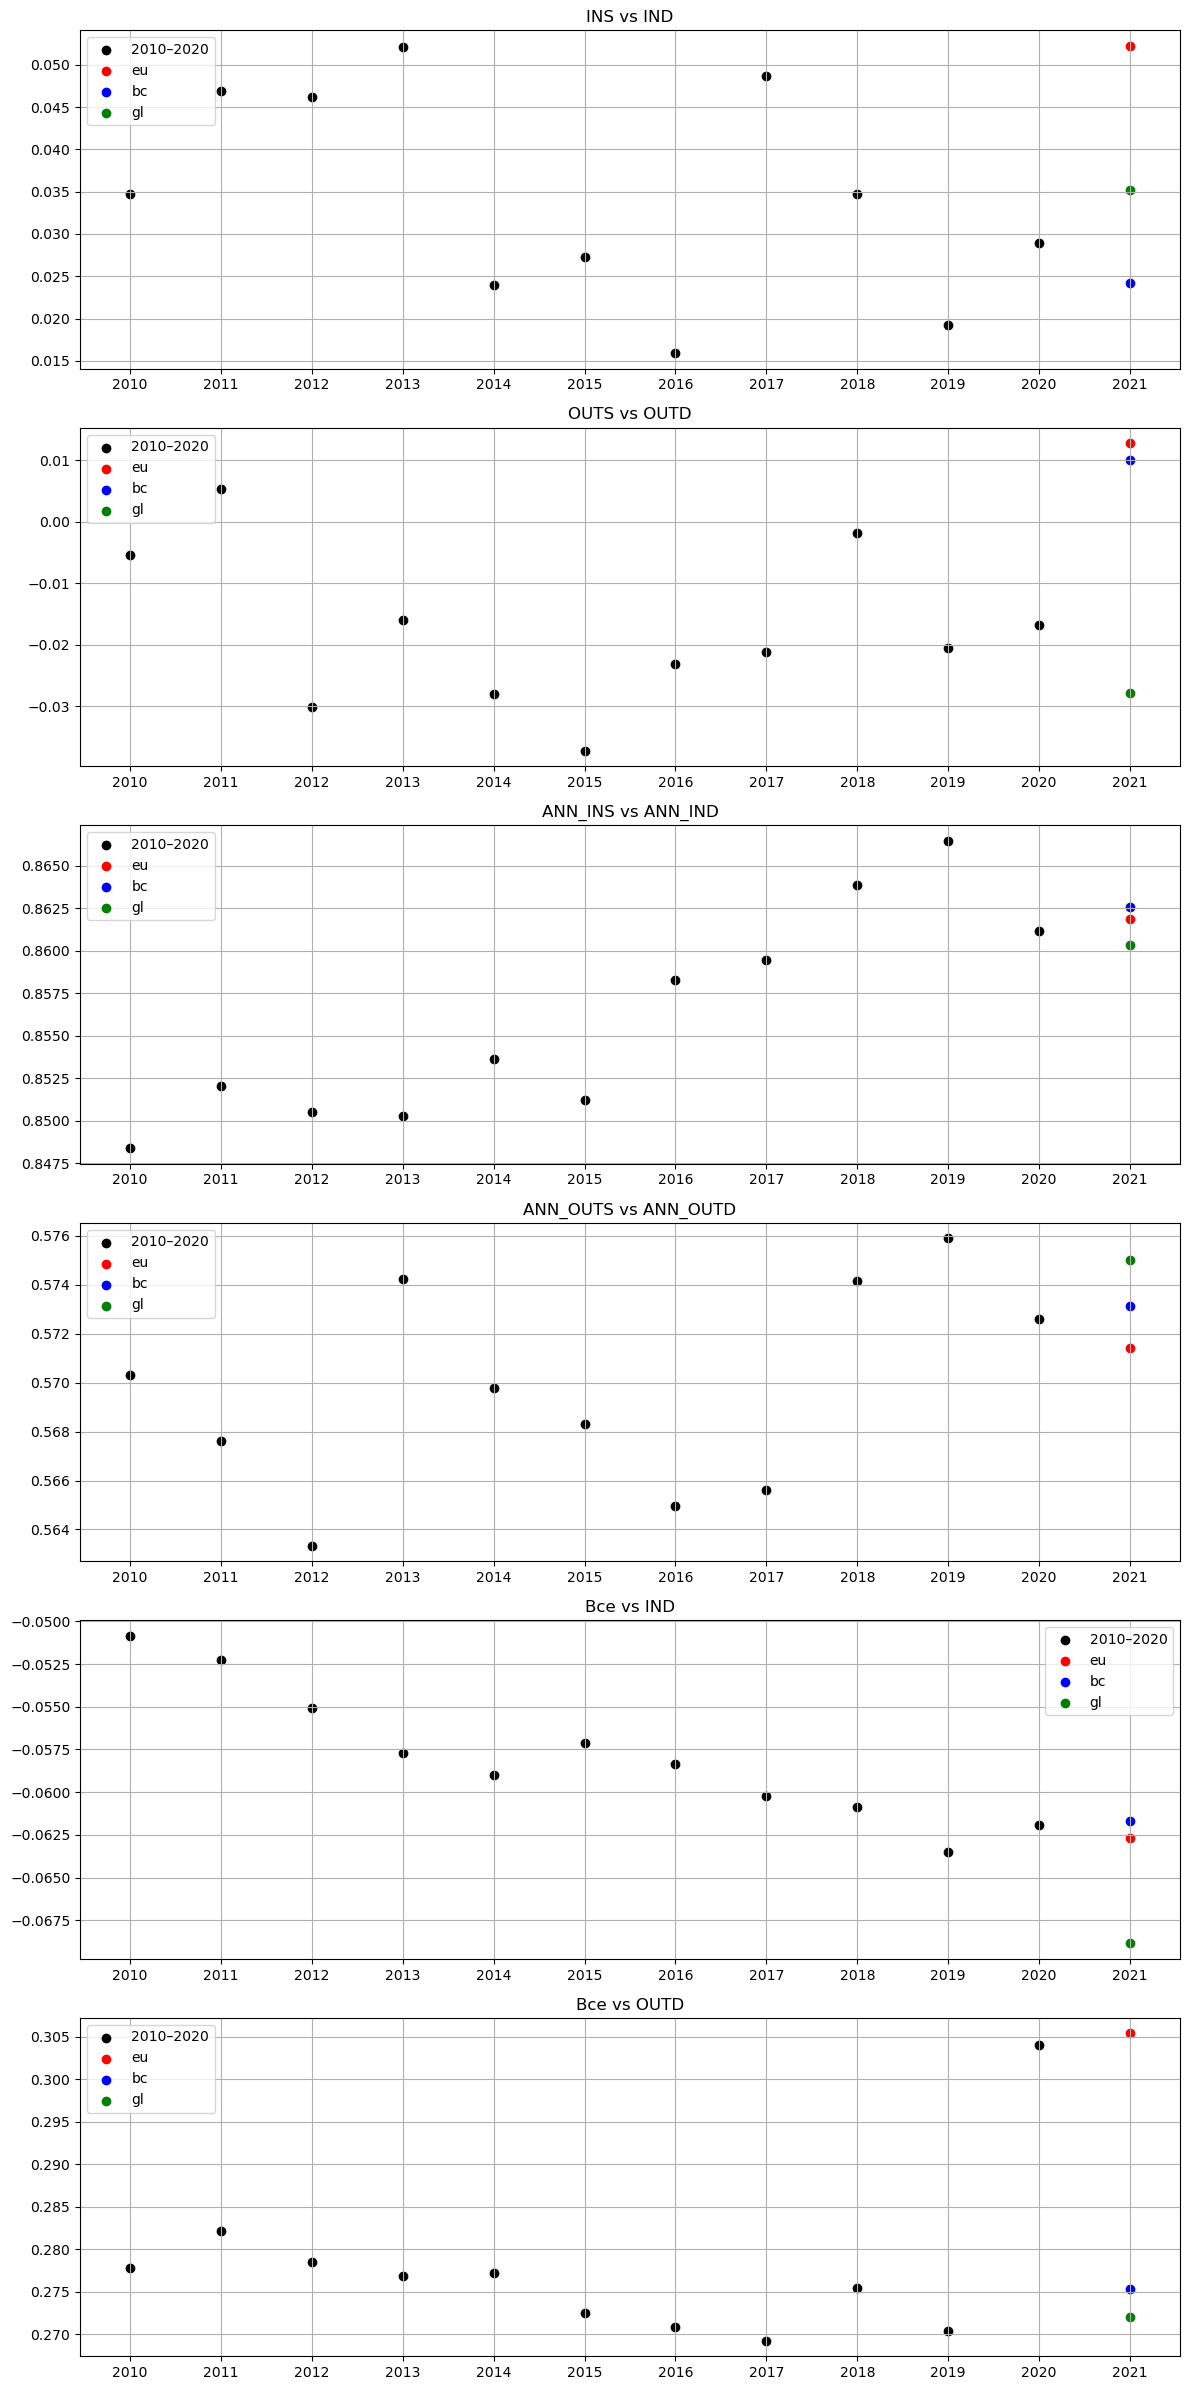

In [56]:
#correlation_degree_spar.index = correlation_degree_spar.index.astype(str)
# Setup
years = [str(y) for y in range(2010, 2021)]
special_cases = ['eu', 'bc', 'gl']
colors = {'eu': 'red', 'bc': 'blue', 'gl': 'green'}
markers = ['o', 's', '^', 'D', '*', 'v', 'p', 'P']  # Avoid unfilled markers like 'x', '+'

# Function to clean column labels for legend
def clean_label(label):
    return label.replace('(spar) ', '').split(' vs ')[0].split()[0] + ' vs ' + label.split(' vs ')[1]

# === Plot 1 ===
fig = plt.figure(figsize=(14, 7))
plotted_labels = set()

for i, column in enumerate(correlation_degree_spar.columns):
    marker = markers[i % len(markers)]
    base_label = clean_label(column)

    # Plot main data (2010–2020)
    plt.scatter(
        [int(y) for y in years],
        correlation_degree_spar.loc[years, column],
        marker=marker,
        edgecolors='black',
        facecolors='none'
    )

    # Add legend entry for measure
    if base_label not in plotted_labels:
        plt.scatter([], [], label=base_label, marker=marker, edgecolors='black', facecolors='none')
        plotted_labels.add(base_label)

    # Plot special cases (2021)
    for case in special_cases:
        plt.scatter(
            2021,
            correlation_degree_spar.loc[case, column],
            color=colors[case],
            marker=marker
        )

# === Legends ===

# Legend for measures (marker styles)
handles1, labels1 = plt.gca().get_legend_handles_labels()
legend1 = plt.legend(handles=handles1, title="Measures", loc='upper left', bbox_to_anchor=(1.02, 1.0))

# Legend for special cases (color patches)
color_patches = [
    mpatches.Patch(color=color, label=f"{case.upper()} ")
    for case, color in colors.items()
]
legend2 = plt.legend(handles=color_patches, title="Policy", loc='upper left', bbox_to_anchor=(1.02, 0.65))

# Add both legends to the plot
plt.gca().add_artist(legend1)

# Final formatting
plt.title("Correlation coefficients")
plt.xlabel("Year")
plt.ylabel("Correlation")
plt.xticks(list(range(2010, 2022)))
plt.grid(True)
plt.tight_layout()
fig.savefig("correlations_degree_all.png", bbox_inches='tight')
plt.show()





# === Plot 2: One subplot per measure ===
n_measures = len(correlation_degree_spar.columns)
fig, axs = plt.subplots(n_measures, 1, figsize=(12, 4 * n_measures))

# Ensure axs is always iterable
if n_measures == 1:
    axs = [axs]

for i, (column, ax) in enumerate(zip(correlation_degree_spar.columns, axs)):
    # Regular years
    ax.scatter(
        [int(y) for y in years],
        correlation_degree_spar.loc[years, column],
        marker='o',
        color='black',
        label='2010–2020'
    )
    # Special cases
    for case in special_cases:
        ax.scatter(
            2021,
            correlation_degree_spar.loc[case, column],
            color=colors[case],
            marker='o',
            label=case
        )

    ax.set_title(column)
    ax.set_xticks(list(range(2010, 2022)))
    ax.grid(True)
    ax.legend()

fig.tight_layout()
fig.savefig('correlations_degree_single.png')
plt.show()

In [ ]:
#SRCC Clus (null model)
from scipy.stats import spearmanr

years = sorted(clus.keys())
spearman_values = []
p_values = []
for y1, y2 in zip(years[:-1], years[1:]):
    s1 = np.array(clus[y1]['Clustering_Coefficient'])
    s2 = np.array(clus[y2]['Clustering_Coefficient'])

    coeff, p_value = spearmanr(s1, s2)
    spearman_values.append(coeff)
    p_values.append(p_value)
    print(f"{y1} → {y2}: Spearman ρ = {coeff:.4f}, p-value = {p_value:.2e}")

# Compute average
average_spearman = sum(spearman_values) / len(spearman_values)
average_p = sum(p_values) / len(p_values)
print(f"\nAverage Spearman ρ across years: {average_spearman:.4f}, Average p-values: {average_p:.2e}")




In [ ]:
#SRRC BCE (null model)
spearman_values = []
p_values = []
for y1, y2 in zip(years[:-1], years[1:]):
    s1 = np.array(bce[y1]['betweenness'])
    s2 = np.array(bce[y2]['betweenness'])

    coeff, p_value = spearmanr(s1, s2)
    spearman_values.append(coeff)
    p_values.append(p_value)
    print(f"{y1} → {y2}: Spearman ρ = {coeff:.4f},  p-value = {p_value:.2e}")

# Compute average
average_spearman = sum(spearman_values) / len(spearman_values)
average_p = sum(p_values) / len(p_values)
print(f"\nAverage Spearman ρ across years: {average_spearman:.4f}, Average p-values: {average_p:.2e}")

In [ ]:
#SRCC HUB (null model)
spearman_values = []

for y1, y2 in zip(years[:-1], years[1:]):
    s1 = np.array(hub_aut[y1]['hub_score'])
    s2 = np.array(hub_aut[y2]['hub_score'])

    coeff, _ = spearmanr(s1, s2)
    spearman_values.append(coeff)
    print(f"{y1} → {y2}: Spearman ρ = {coeff:.4f}")

# Compute average
average_spearman = sum(spearman_values) / len(spearman_values)
print(f"\nAverage Spearman ρ across years: {average_spearman:.4f}")

In [ ]:
#SRCC AUT (null model)
years = sorted(clus.keys())
spearman_values = []

for y1, y2 in zip(years[:-1], years[1:]):
    s1 = np.array(hub_aut[y1]['authority_score'])
    s2 = np.array(hub_aut[y2]['authority_score'])

    coeff, _ = spearmanr(s1, s2)
    spearman_values.append(coeff)
    print(f"{y1} → {y2}: Spearman ρ = {coeff:.4f}")

# Compute average
average_spearman = sum(spearman_values) / len(spearman_values)
print(f"\nAverage Spearman ρ across years: {average_spearman:.4f}")

In [ ]:
#SRCC INS (null model)
spearman_values = []

for y1, y2 in zip(years[:-1], years[1:]):
    s1 = np.array(in_strength[y1])
    s2 = np.array(in_strength[y2])

    coeff, _ = spearmanr(s1, s2)
    spearman_values.append(coeff)
    print(f"{y1} → {y2}: Spearman ρ = {coeff:.4f}")

# Compute average
average_spearman = sum(spearman_values) / len(spearman_values)
print(f"\nAverage Spearman ρ across years: {average_spearman:.4f}")

In [ ]:
#SRCC OUTS (null model)
spearman_values = []

for y1, y2 in zip(years[:-1], years[1:]):
    s1 = np.array(out_strength[y1])
    s2 = np.array(out_strength[y2])

    coeff, _ = spearmanr(s1, s2)
    spearman_values.append(coeff)
    print(f"{y1} → {y2}: Spearman ρ = {coeff:.4f}")

# Compute average
average_spearman = sum(spearman_values) / len(spearman_values)
print(f"\nAverage Spearman ρ across years: {average_spearman:.4f}")

In [ ]:
#SRCC all measure (between 2020 and policy)
for model in labels:
    s1 = np.array(bce[2020]['betweenness'])
    s2 = np.array(bce[model]['betweenness'])

    coeff, _ = spearmanr(s1, s2)
    print(f"Betweenness: 2020 → {model}: Spearman ρ   = {coeff:.4f}")

for model in labels:
    s1 = np.array(clus[2020]['Clustering_Coefficient'])
    s2 = np.array(clus[model]['Clustering_Coefficient'])

    coeff, _ = spearmanr(s1, s2)
    print(f"Clustering: 2020 → {model}: Spearman ρ   = {coeff:.4f}")

for model in labels:
    s1 = np.array(hub_aut[2020]['hub_score'])
    s2 = np.array(hub_aut[model]['hub_score'])

    coeff, _ = spearmanr(s1, s2)
    print(f"Hubness: 2020 → {model}: Spearman ρ   = {coeff:.4f}")

for model in labels:
    s1 = np.array(hub_aut[2020]['authority_score'])
    s2 = np.array(hub_aut[model]['authority_score'])

    coeff, _ = spearmanr(s1, s2)
    print(f"Authority: 2020 → {model}: Spearman ρ   = {coeff:.4f}")

for model in labels:
    s1 = np.array(in_strength[2020])
    s2 = np.array(in_strength[model])

    coeff, _ = spearmanr(s1, s2)
    print(f"In-strenght: 2020 → {model}: Spearman ρ   = {coeff:.4f}")

for model in labels:
    s1 = np.array(out_strength[2020])
    s2 = np.array(out_strength[model])

    coeff, _ = spearmanr(s1, s2)
    print(f"Out-strenght: 2020 → {model}: Spearman ρ   = {coeff:.4f}")
    